___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___

<h1 style="text-align: center;">Deep Learning<br><br>Assignment-1 (ANN)<br><br>Churn Prediction for Bank Customer<br><h1>

# Dataset Info

We have a dataset in which there are details of a bank's customers and the target variable is a binary variable reflecting the fact whether the customer left the bank (closed his account) or he continues to be a customer.

The features in the given dataset are:
- **rownumber:** Row Numbers from 1 to 10000.
- **customerid:** A unique ID that identifies each customer.
- **surname:** The customer’s surname.
- **creditscore:** A credit score is a number between 300–850 that depicts a consumer's creditworthiness.
- **geography:** The country from which the customer belongs to.
- **Gender:** The customer’s gender: Male, Female
- **Age:** The customer’s current age, in years, at the time of being customer.
- **tenure:** The number of years for which the customer has been with the bank.
- **balance:** Bank balance of the customer.
- **numofproducts:** the number of bank products the customer is utilising.
- **hascrcard:** The number of credit cards given to the customer by the bank.
- **isactivemember:** Binary Flag for indicating if the client is active or not with the bank before the moment where the client exits the company (recorded in the variable "exited")
- **exited:** Binary flag 1 if the customer closed account with bank and 0 if the customer is retained.

# Improt Libraries & Data

In [6]:
!pip install tensorflow

In [7]:
!pip install optuna

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation
from sklearn.metrics import RocCurveDisplay, roc_curve, mean_squared_error, mean_absolute_error, r2_score, accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, make_scorer, precision_score, recall_score, f1_score, average_precision_score, roc_auc_score
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import Adam, Adadelta, RMSprop, Nadam
import optuna
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import load_model
import pickle

plt.rcParams["figure.figsize"] = (10, 6)

sns.set_style("whitegrid")
pd.set_option("display.float_format", lambda x: "%.3f" % x)
pd.set_option("display.max_columns", None)

import os

# Set TF log level to ignore INFOs.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [9]:
SEED = 42
import random
os.environ["TF_DETERMINISTIC_OPS"] = "1"
tf.keras.utils.set_random_seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [11]:
df = pd.read_csv("/content/drive/MyDrive/SDA/Churn_Modelling.csv")

### Required Checks

In [12]:
# Check python version
!python --version

Python 3.10.12


In [13]:
# Check tensorflow version
import tensorflow as tf
print(tf.__version__)

2.14.0


In [14]:
try:
    import jupyter_black
    jupyter_black.load()
except ImportError:
    print("You can safely ignore this.")

You can safely ignore this.


In [15]:
# Set tensorflow log level to ignore INFOs.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [16]:
# List cuda-capable gpu's that are attached to this session
if tf.config.list_physical_devices("GPU"):
    print("GPU support is enabled for this session.")
else:
    print("CPU will be used for this session.")

CPU will be used for this session.


In [17]:
# Get more information about the GPU
if tf.config.list_physical_devices("GPU"):
    !nvidia-smi

# Exploratory Data Analysis and Visualization

1. Implement basic steps to see how is your data looks like
2. Check for missing values
3. Drop the features that not suitable for modelling
4. Implement basic visualization steps such as histogram, countplot, heatmap
5. Convert categorical variables to dummy variables

In [18]:
df.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2      0.000              1          1               1   
1       1  83807.860              1          0               1   
2       8 159660.800              3          1               0   
3       1      0.000              2          0               0   
4       2 125510.820              1          1               1   

   EstimatedSalary  Exited  
0       101348.880       1  
1       112542.580       0  
2       113931.570       1  
3        93826.630       0  
4        79084.100       0

In [19]:
df.shape

(10000, 14)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [21]:
df.describe().T

count         mean       std          min          25%  \
RowNumber       10000.000     5000.500  2886.896        1.000     2500.750   
CustomerId      10000.000 15690940.569 71936.186 15565701.000 15628528.250   
CreditScore     10000.000      650.529    96.653      350.000      584.000   
Age             10000.000       38.922    10.488       18.000       32.000   
Tenure          10000.000        5.013     2.892        0.000        3.000   
Balance         10000.000    76485.889 62397.405        0.000        0.000   
NumOfProducts   10000.000        1.530     0.582        1.000        1.000   
HasCrCard       10000.000        0.706     0.456        0.000        0.000   
IsActiveMember  10000.000        0.515     0.500        0.000        0.000   
EstimatedSalary 10000.000   100090.240 57510.493       11.580    51002.110   
Exited          10000.000        0.204     0.403        0.000        0.000   

                         50%          75%          max  
RowNumber           5000.500     7500.250    10000.000  
CustomerId      15690738.000 15753233.750 15815690.000  
CreditScore          652.000      718.000      850.000  
Age                   37.000       44.000       92.000  
Tenure                 5.000        7.000       10.000  
Balance            97198.540   127644.240   250898.090  
NumOfProducts          1.000        2.000        4.000  
HasCrCard              1.000        1.000        1.000  
IsActiveMember         1.000        1.000        1.000  
EstimatedSalary   100193.915   149388.247   199992.480  
Exited                 0.000        0.000        1.000

In [22]:
df.isnull().sum().any()

False

In [23]:
df.duplicated().sum()

0

In [24]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [25]:
drop_cols = ['RowNumber','CustomerId','Surname' ]
df.drop(columns=drop_cols, axis=1, inplace=True)
# Dropped because it isn't suitable for modelling

In [26]:
df.shape

(10000, 11)

In [27]:
df.tail()

CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
9995          771    France    Male   39       5      0.000              2   
9996          516    France    Male   35      10  57369.610              1   
9997          709    France  Female   36       7      0.000              1   
9998          772   Germany    Male   42       3  75075.310              2   
9999          792    France  Female   28       4 130142.790              1   

      HasCrCard  IsActiveMember  EstimatedSalary  Exited  
9995          1               0        96270.640       0  
9996          1               1       101699.770       0  
9997          0               1        42085.580       1  
9998          1               0        92888.520       1  
9999          1               0        38190.780       0

In [28]:
df_object = df.select_dtypes(include ="object").head()
df_object

Geography  Gender
0    France  Female
1     Spain  Female
2    France  Female
3    France  Female
4     Spain  Female

In [29]:
for col in df_object:
    print(f"{col:<10}: {df[col].nunique():<5}unique values")

Geography : 3    unique values
Gender    : 2    unique values


In [30]:
df.Geography.unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [31]:
df.Geography.value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

<Axes: ylabel='Geography'>

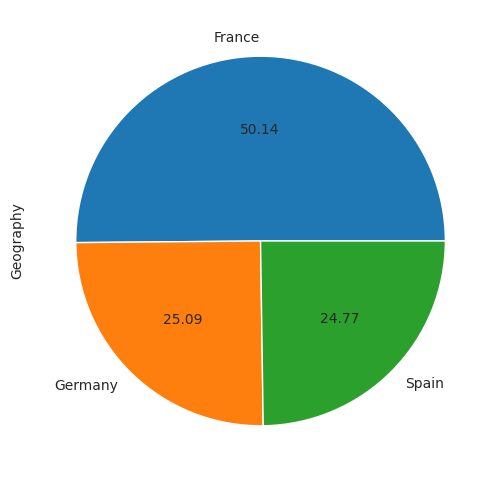

In [32]:
df.Geography.value_counts().plot.pie(autopct='%.2f')
# France     50%
# Germany    26%
# Spain      24%

[Text(0, 0, '5014'), Text(0, 0, '2477'), Text(0, 0, '2509')]

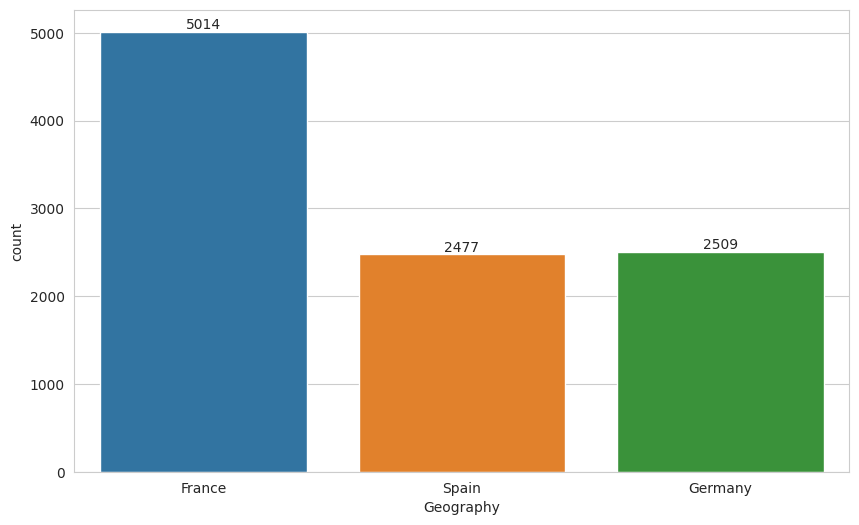

In [33]:
ax = sns.countplot(x='Geography', data=df)
ax.bar_label(ax.containers[0])

In [34]:
df.Gender.value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

<Axes: ylabel='Gender'>

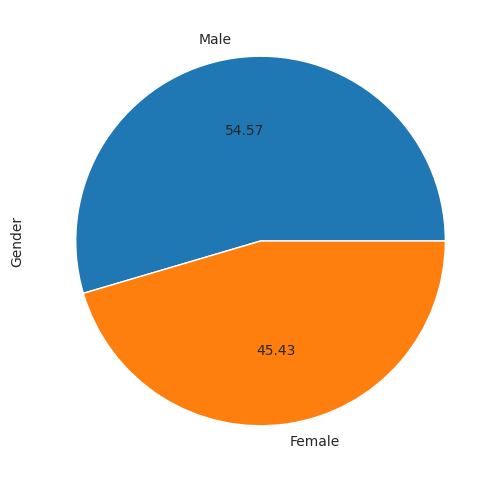

In [35]:
df.Gender.value_counts().plot.pie(autopct='%.2f')
# Male and Female are almost slimier, there is no big difference

[Text(0, 0, '4543'), Text(0, 0, '5457')]

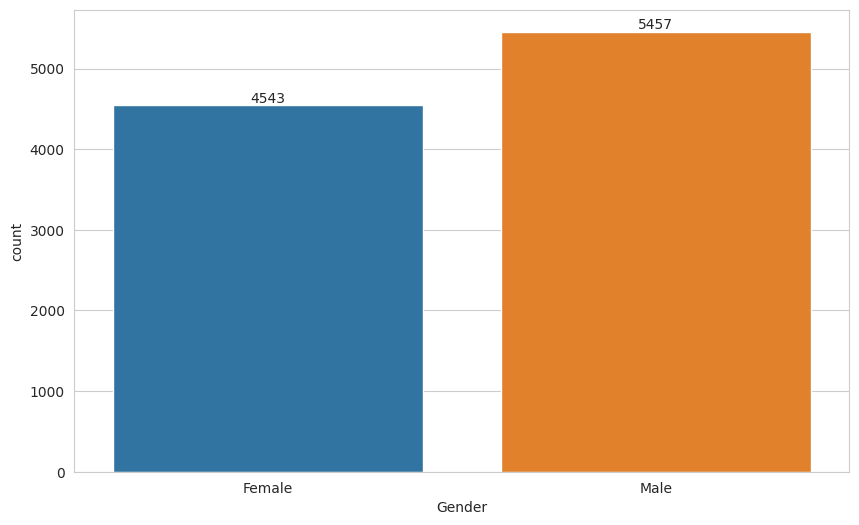

In [36]:
ax = sns.countplot(x='Gender', data=df)
ax.bar_label(ax.containers[0])

In [37]:
df.Exited.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

<Axes: ylabel='Exited'>

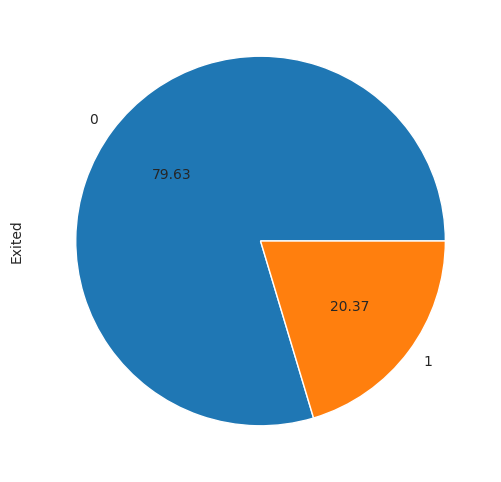

In [38]:
df.Exited.value_counts().plot.pie(autopct='%.2f')

[Text(0, 0, '7963'), Text(0, 0, '2037')]

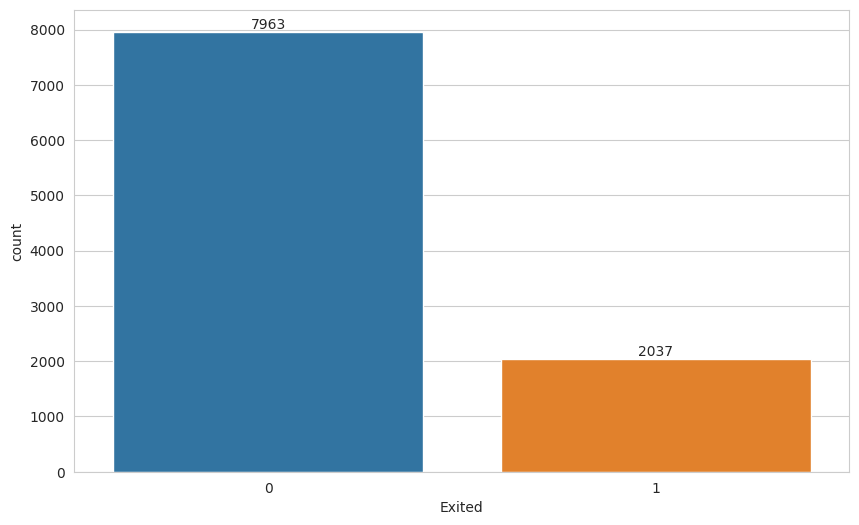

In [39]:
ax = sns.countplot(x='Exited', data=df)
ax.bar_label(ax.containers[0])

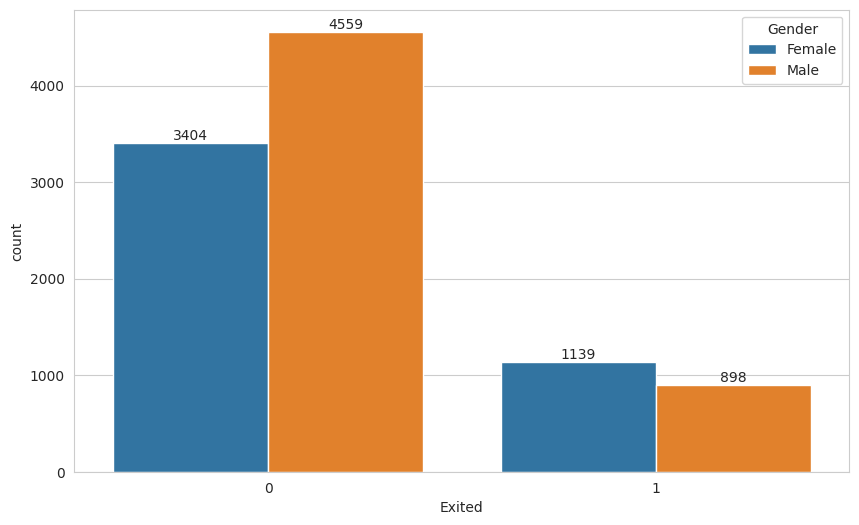

In [40]:
ax = sns.countplot(x="Exited", data = df, hue = "Gender")
for p in ax.containers:
    ax.bar_label(p)

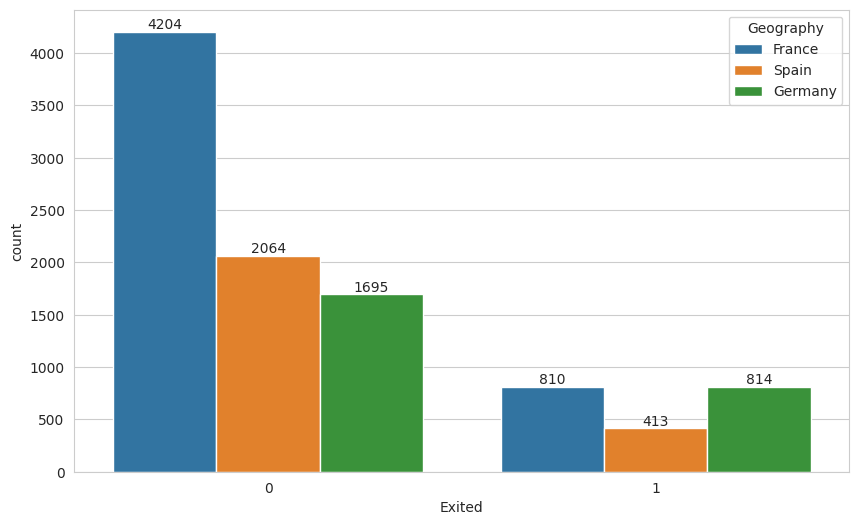

In [41]:
ax = sns.countplot(x="Exited", data = df, hue = "Geography")
for p in ax.containers:
    ax.bar_label(p)

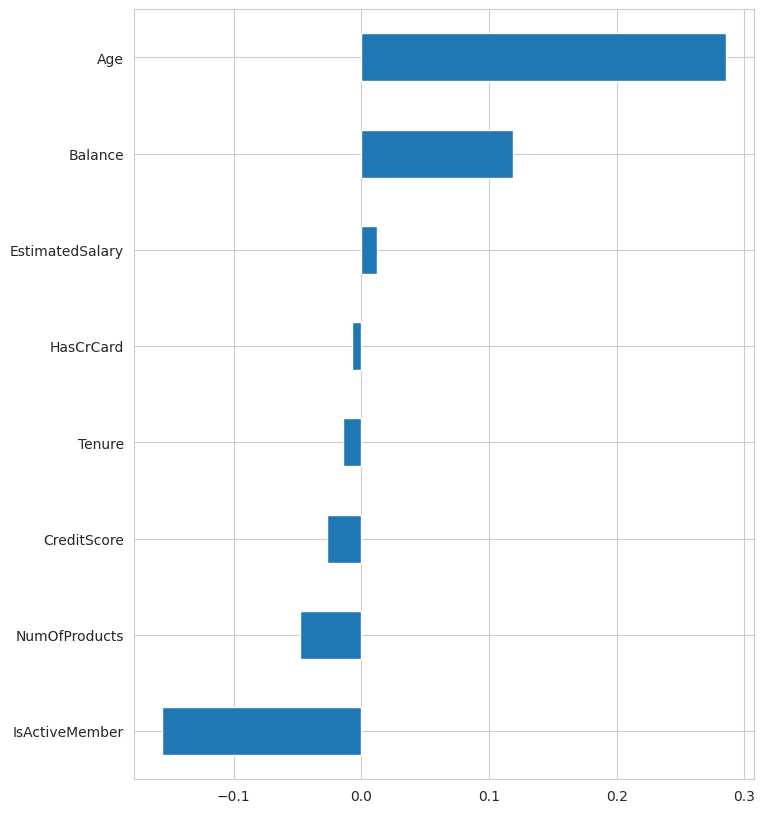

In [42]:
plt.figure(figsize=(8, 10))
(df.corr(numeric_only=True)["Exited"].sort_values().drop("Exited").plot(kind="barh"))
plt.show()

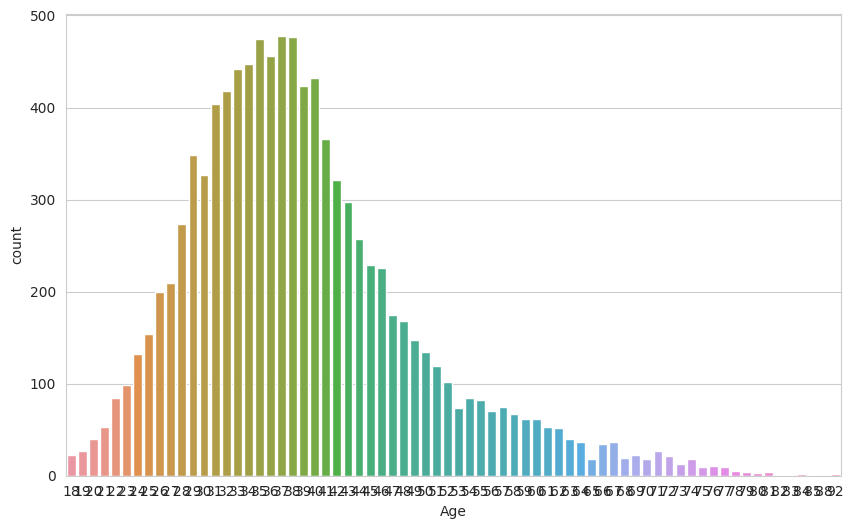

In [43]:
sns.countplot(x=df["Age"])
plt.show()

In [44]:
df.Balance.value_counts(dropna=False)

0.000         3617
130170.820       2
105473.740       2
85304.270        1
159397.750       1
              ... 
81556.890        1
112687.690       1
108698.960       1
238387.560       1
130142.790       1
Name: Balance, Length: 6382, dtype: int64

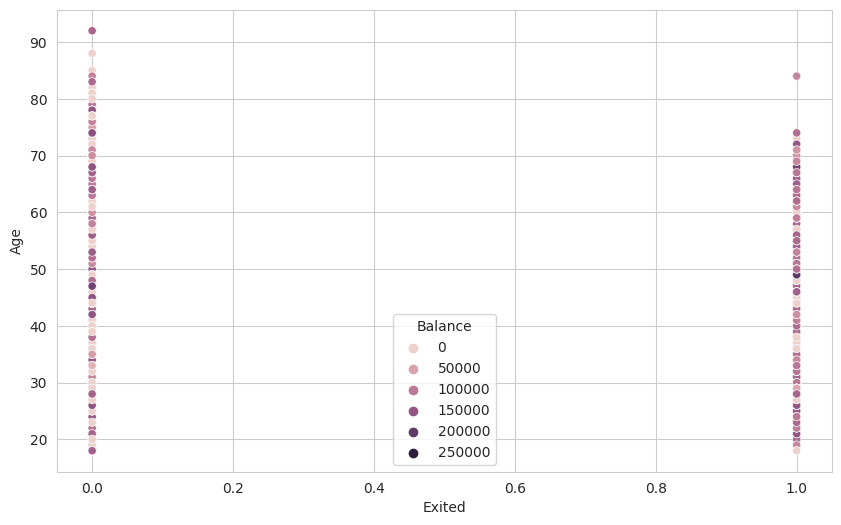

In [45]:
sns.scatterplot(x="Exited", y="Age", data=df, hue="Balance")
plt.show()

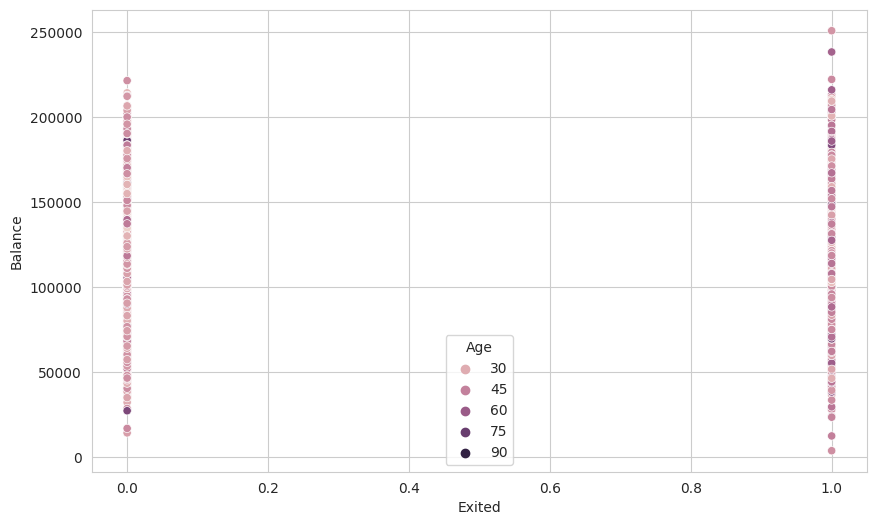

In [46]:
sns.scatterplot(x="Exited", y="Balance", data=df[df.Balance != 0], hue="Age")
plt.show()

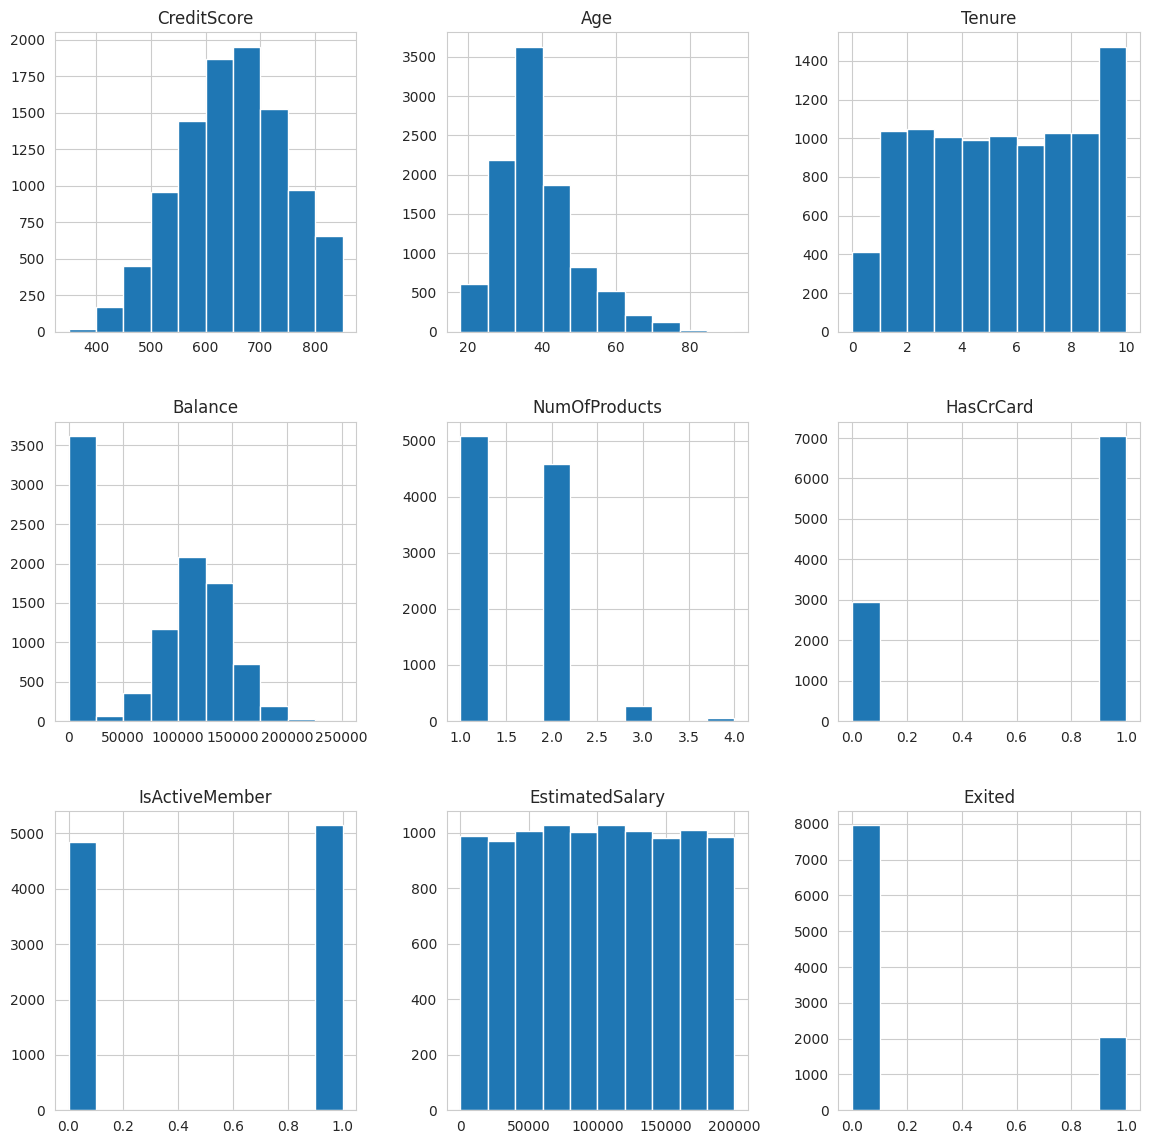

In [47]:
# Plot histogram
df.hist(figsize=(14,14))
plt.show()

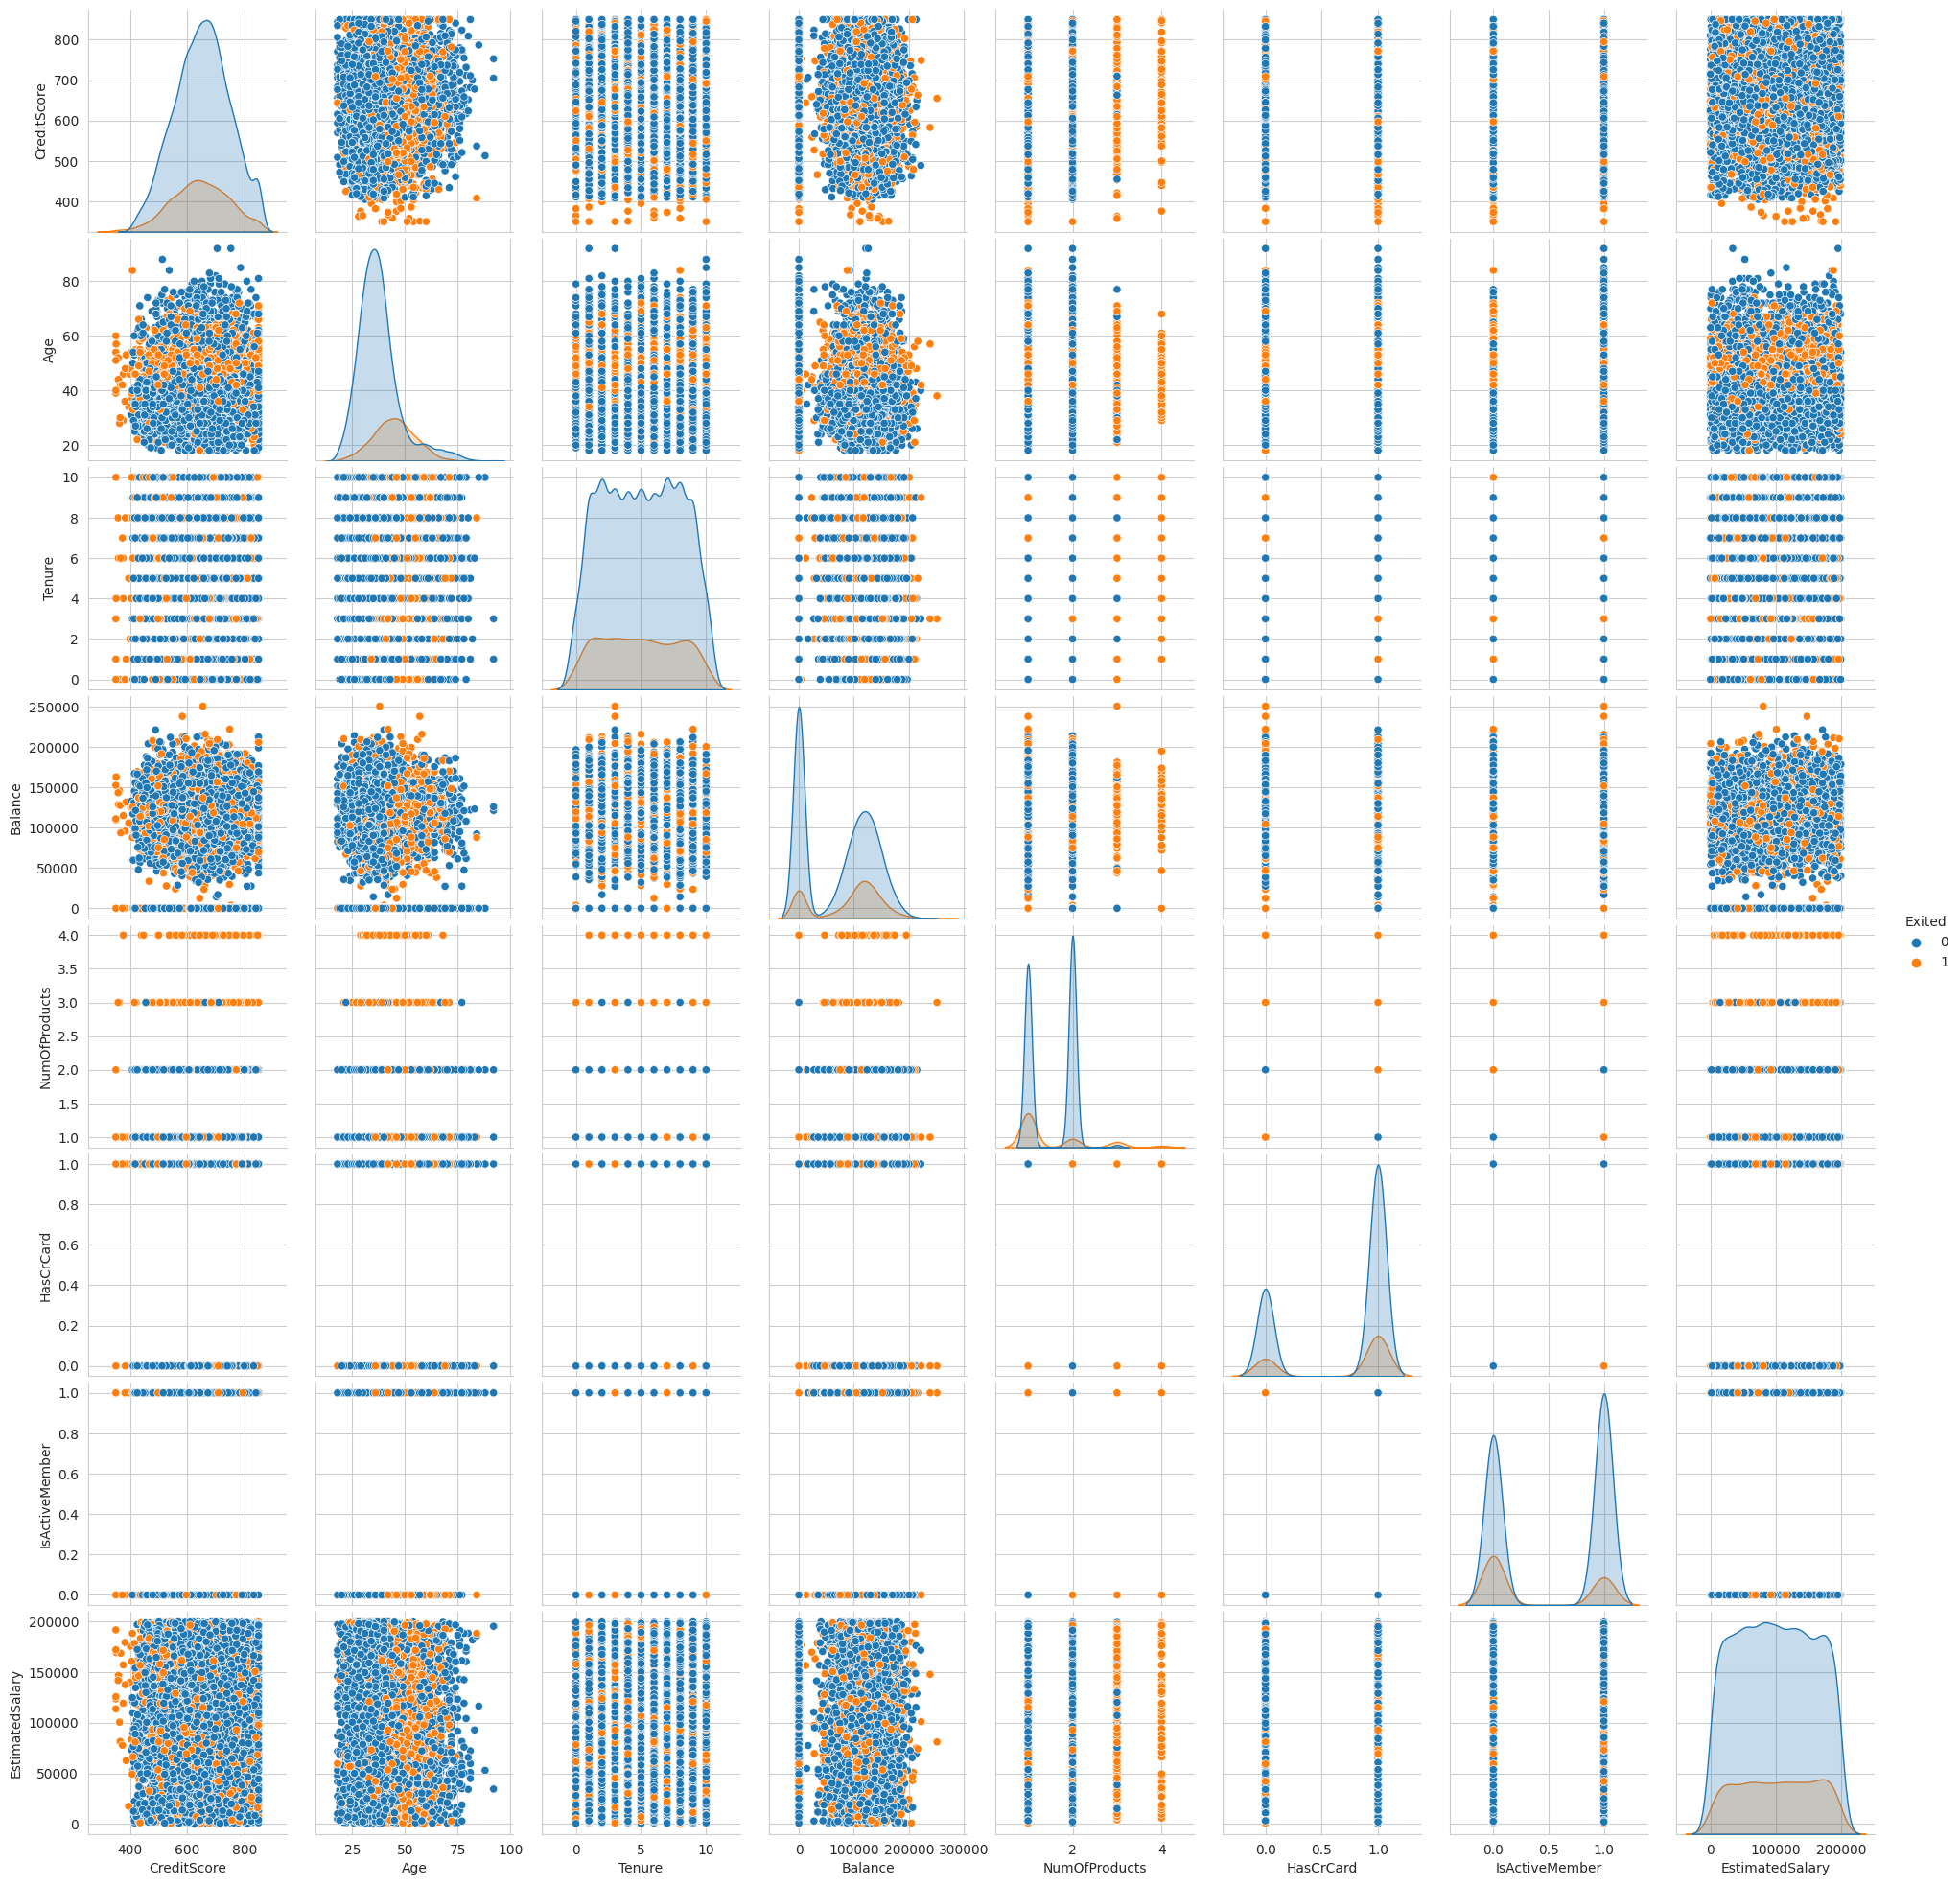

In [48]:
sns.pairplot(df, hue='Exited')
plt.show()

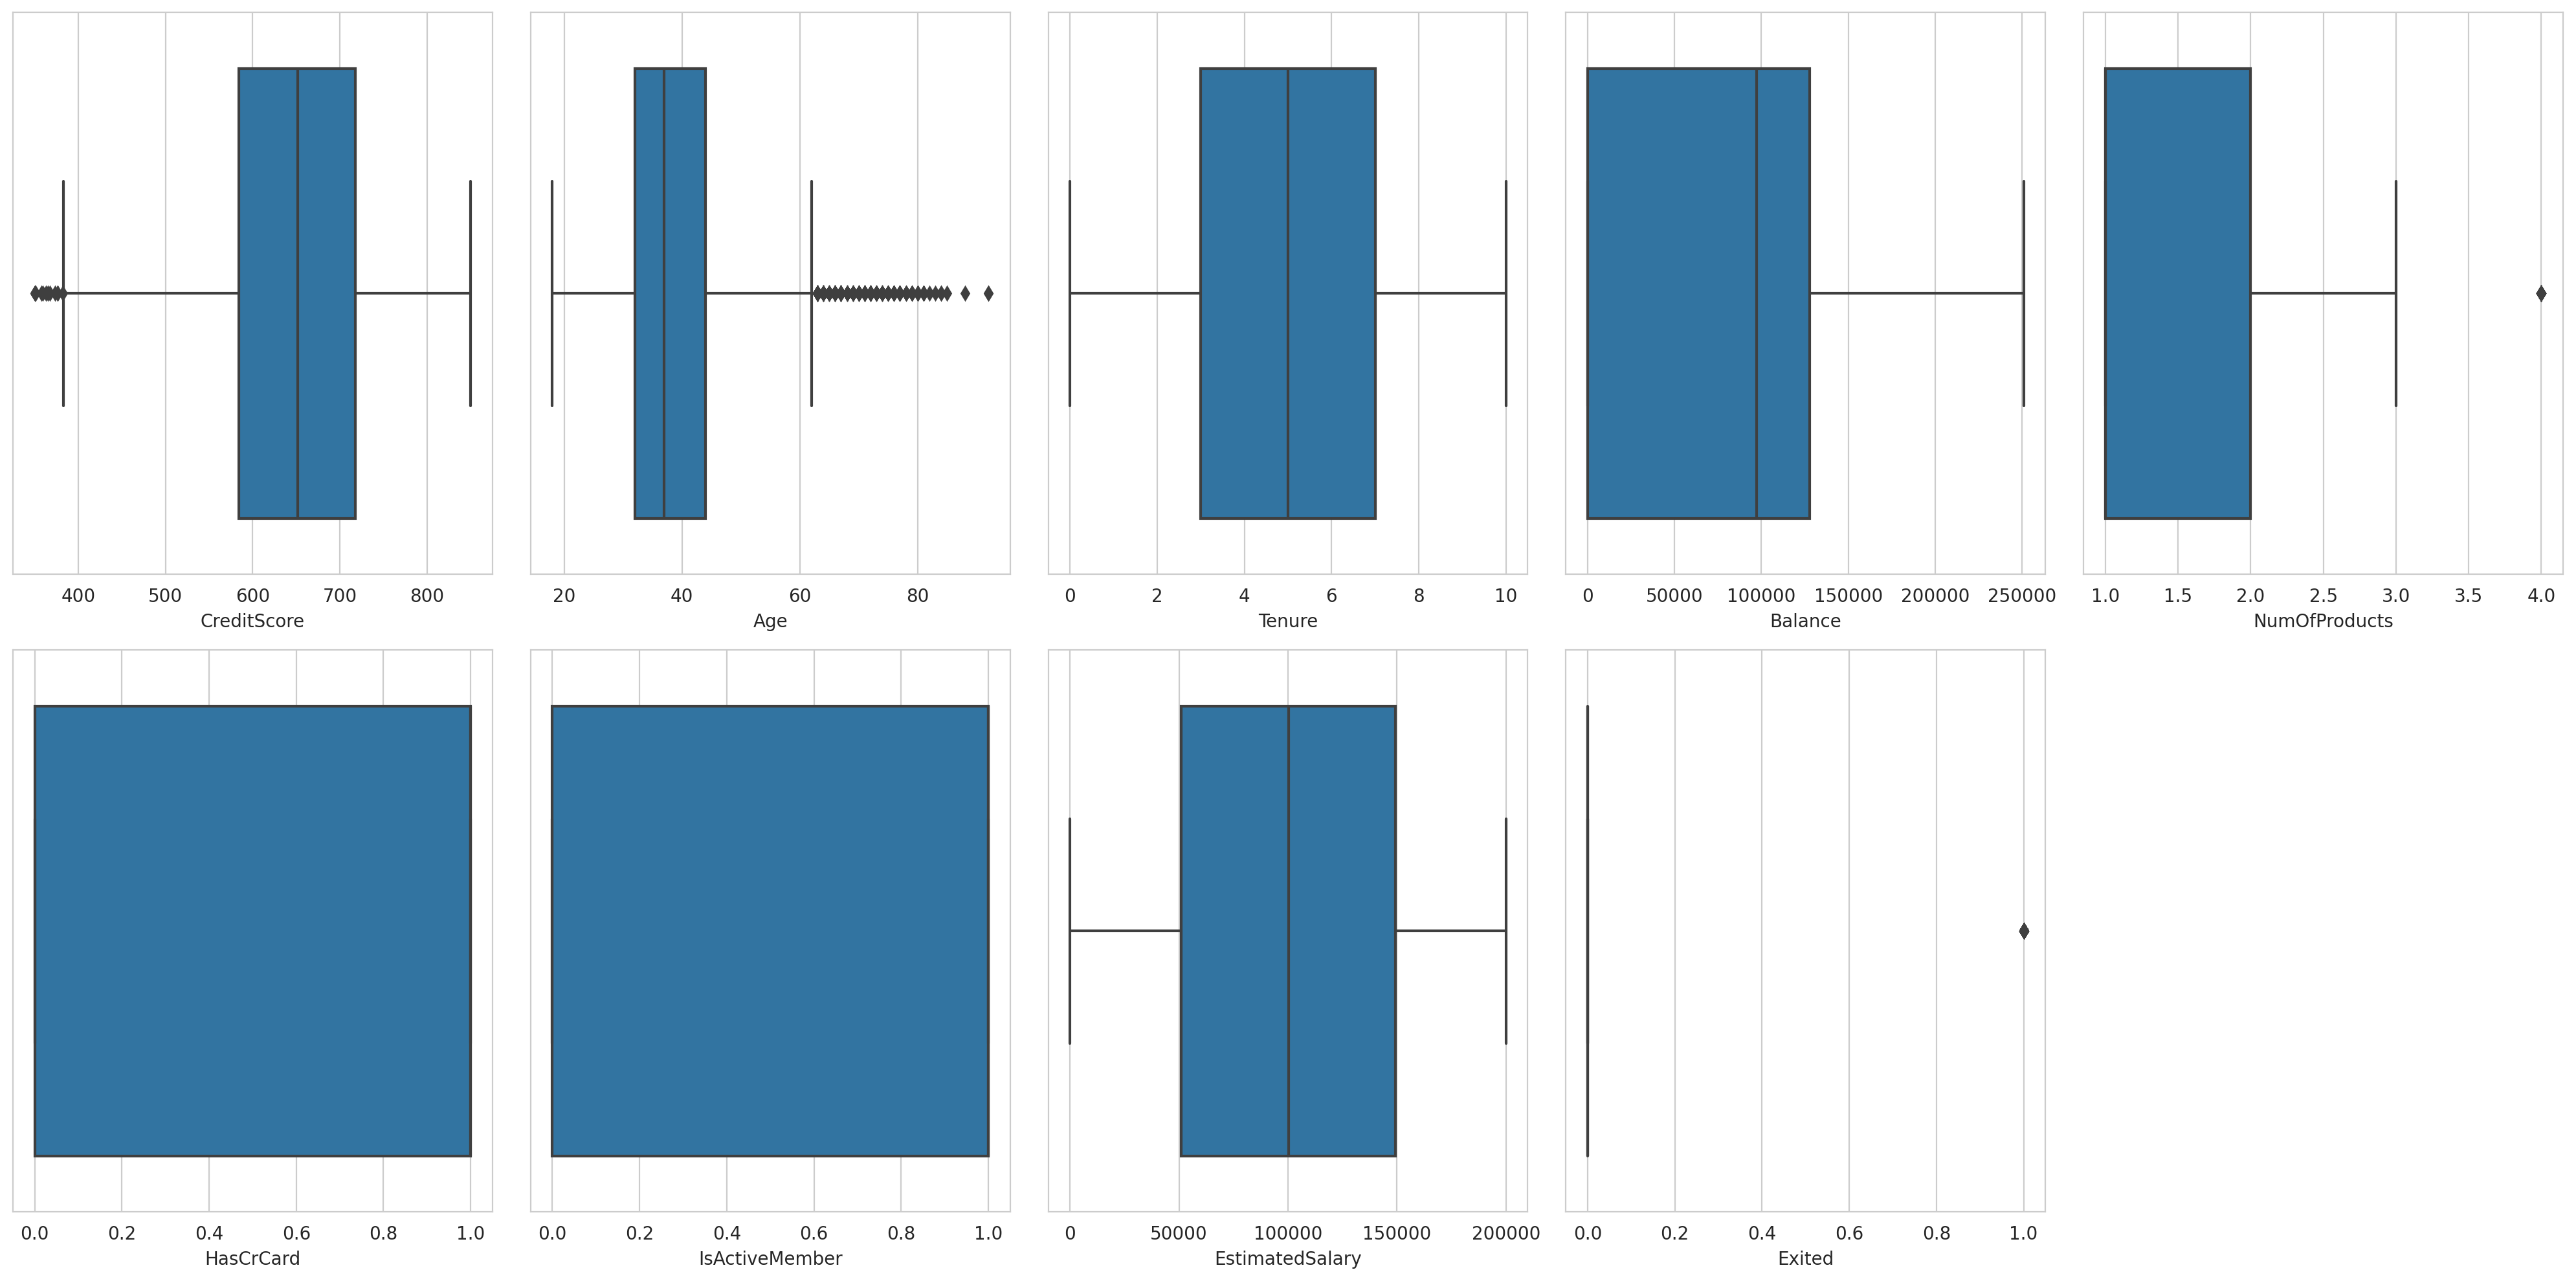

In [49]:
fig = plt.figure(figsize=(20,10), dpi=200)

for i, col in enumerate(df.select_dtypes(["float", "int"]).columns):
        plt.subplot(2,5,i+1)
        ax = sns.boxplot(x=df[col])

plt.tight_layout();

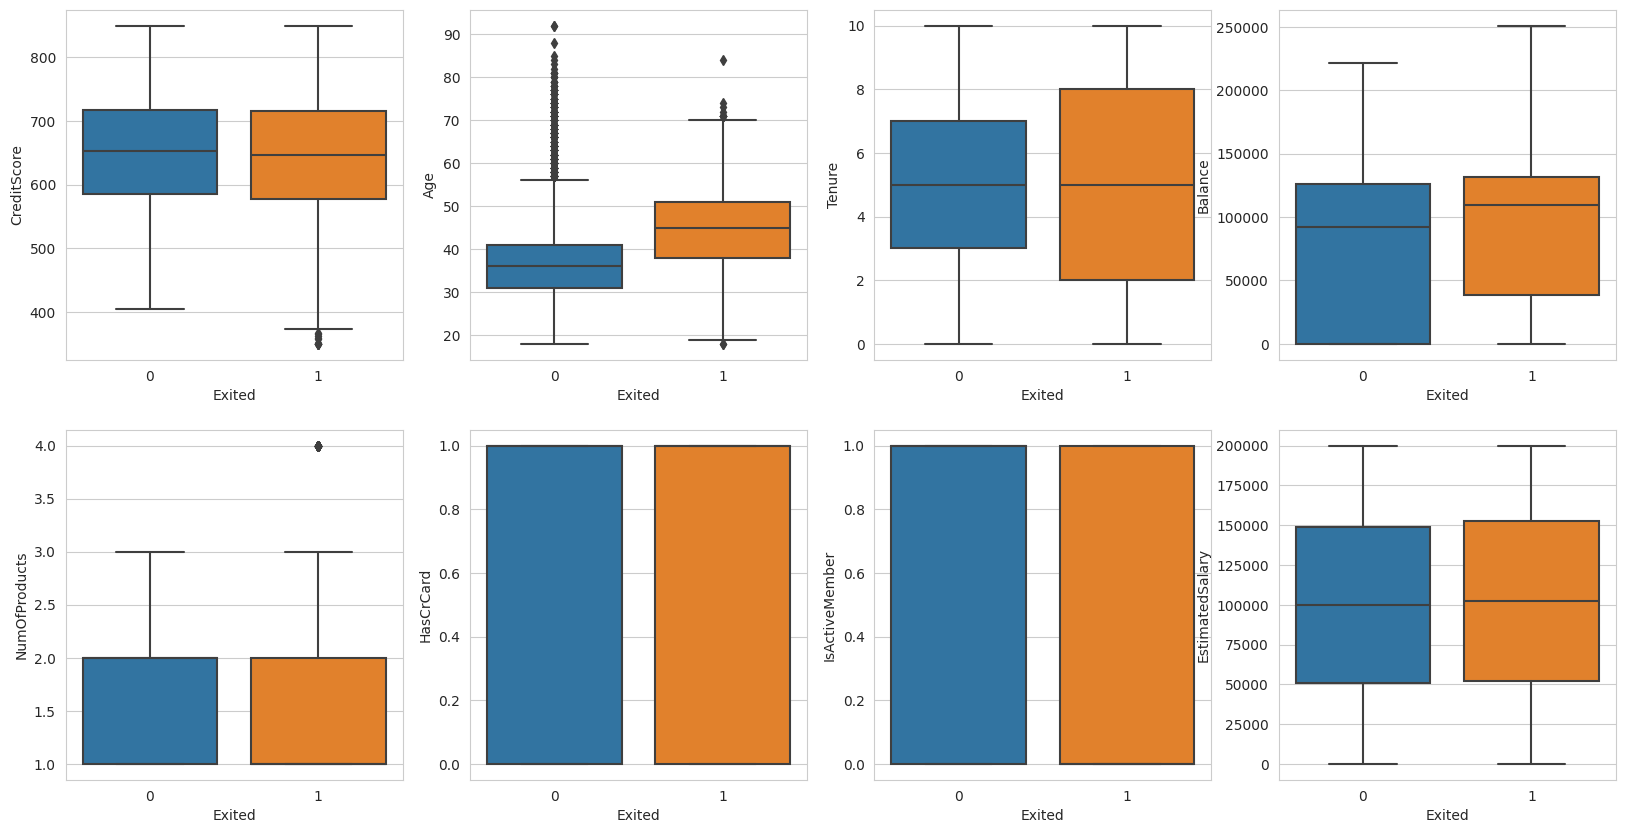

In [50]:
index = 0
plt.figure(figsize=(20,10))
for feature in df.select_dtypes("number"):
    if feature != "Exited":
        index += 1
        plt.subplot(2,4,index)
        sns.boxplot(x='Exited',y=feature,data=df)

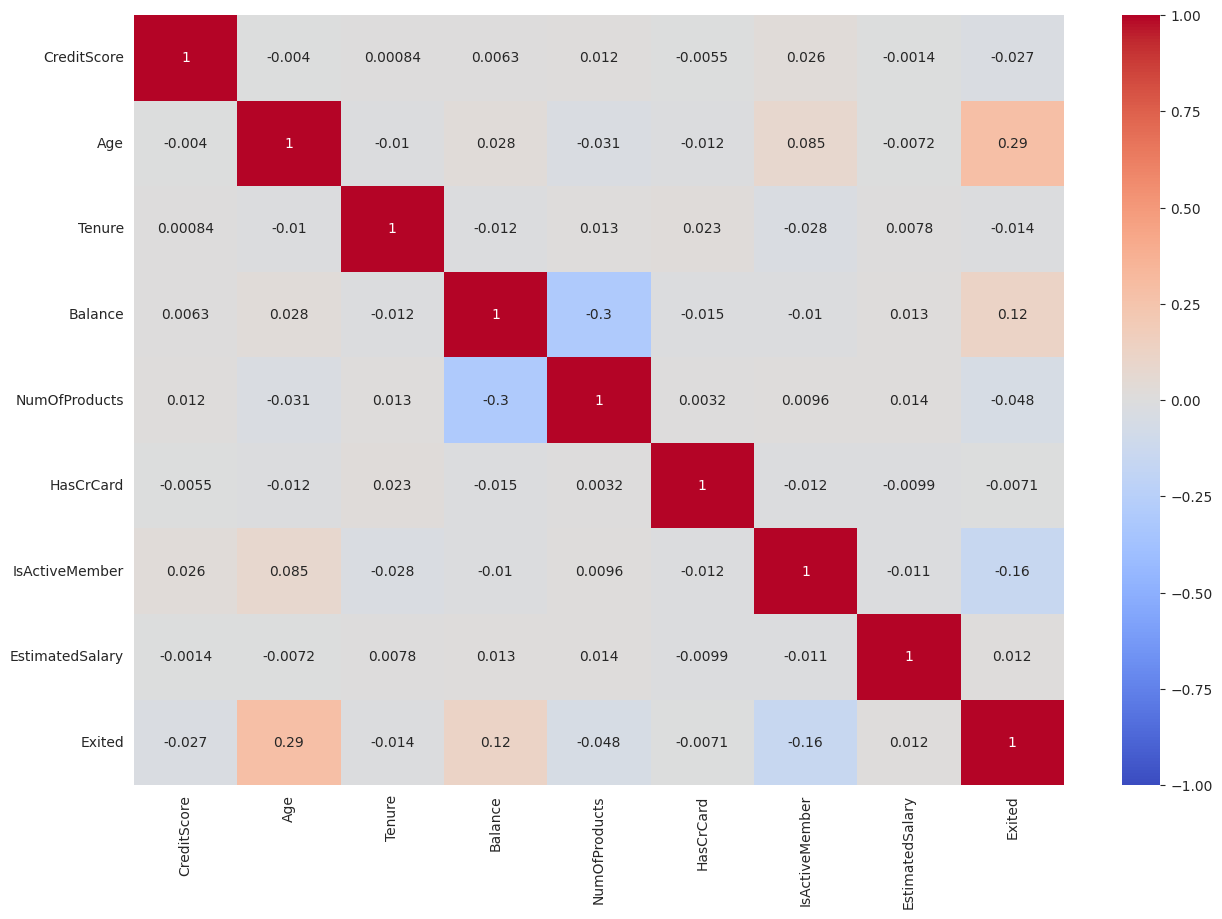

In [51]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(numeric_only=True),vmin = -1, vmax =1,annot=True, cmap="coolwarm");

In [53]:
df.head(10)

CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42       2      0.000              1   
1          608     Spain  Female   41       1  83807.860              1   
2          502    France  Female   42       8 159660.800              3   
3          699    France  Female   39       1      0.000              2   
4          850     Spain  Female   43       2 125510.820              1   
5          645     Spain    Male   44       8 113755.780              2   
6          822    France    Male   50       7      0.000              2   
7          376   Germany  Female   29       4 115046.740              4   
8          501    France    Male   44       4 142051.070              2   
9          684    France    Male   27       2 134603.880              1   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0          1               1       101348.880       1  
1          0               1       112542.580       0  
2          1               0       113931.570       1  
3          0               0        93826.630       0  
4          1               1        79084.100       0  
5          1               0       149756.710       1  
6          1               1        10062.800       0  
7          1               0       119346.880       1  
8          0               1        74940.500       0  
9          1               1        71725.730       0

# Preprocessing of Data
- Train | Test Split, Scalling

In [54]:
X = df.drop(columns ='Exited', axis =1)
y = df.Exited

In [55]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=SEED
)

In [56]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train, random_state=SEED
)

In [57]:
print("Train features shape : ", X_train.shape)
print("Train target shape   : ", y_train.shape)
print("Validation features shape : ", X_val.shape)
print("Validation target shape   : ", y_val.shape)
print("Test features shape  : ", X_test.shape)
print("Test target shape    : ", y_test.shape)

Train features shape :  (7650, 10)
Train target shape   :  (7650,)
Validation features shape :  (850, 10)
Validation target shape   :  (850,)
Test features shape  :  (1500, 10)
Test target shape    :  (1500,)


In [58]:
print(y.value_counts(normalize=True))
print()
print(y_train.value_counts(normalize=True))
print()
print(y_val.value_counts(normalize=True))
print()
print(y_test.value_counts(normalize=True))

0   0.796
1   0.204
Name: Exited, dtype: float64

0   0.796
1   0.204
Name: Exited, dtype: float64

0   0.796
1   0.204
Name: Exited, dtype: float64

0   0.796
1   0.204
Name: Exited, dtype: float64


In [59]:
categorical_cols = X_train.select_dtypes(include=['object','bool']).columns

In [60]:
oneHencoder = OneHotEncoder(categories = "auto", sparse= False, handle_unknown="ignore")

In [61]:
trans = [("categorical",oneHencoder,categorical_cols)]
column_trans= ColumnTransformer (transformers = trans, remainder='passthrough')

In [62]:
X_train = column_trans.fit_transform(X_train)
X_val = column_trans.transform(X_val)
X_test = column_trans.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [63]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Modelling & Model Performance

## without class_weigth

### Create The Model

In [134]:
tf.random.set_seed(SEED)

model_noCW= Sequential()

model_noCW.add(Dense(units=8, activation="relu", input_dim=X_train.shape[1]))
model_noCW.add(Dense(units=6, activation="relu"))
model_noCW.add(Dense(units=4, activation="relu"))
model_noCW.add(Dense(units=1, activation="sigmoid"))

model_noCW.compile(optimizer="adam", loss="binary_crossentropy", metrics = ['accuracy'])

In [132]:
model_noCW.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 112       
                                                                 
 dense_1 (Dense)             (None, 6)                 54        
                                                                 
 dense_2 (Dense)             (None, 4)                 28        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 199 (796.00 Byte)
Trainable params: 199 (796.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [133]:
model_noCW.weights

[<tf.Variable 'dense/kernel:0' shape=(13, 8) dtype=float32, numpy=
 array([[ 0.38292027,  0.17385721, -0.15104455,  0.481059  , -0.45107165,
          0.16285008,  0.50298554, -0.35501686],
        [ 0.02543181,  0.13978791, -0.44213745, -0.05734625,  0.49821097,
         -0.03170669,  0.00314981,  0.28400892],
        [-0.51439244, -0.32885864,  0.01522487, -0.46351147, -0.4942783 ,
          0.37199187,  0.4441111 , -0.25385454],
        [ 0.38435572, -0.39824647, -0.04031861,  0.06705248,  0.07129663,
         -0.32054025, -0.31035155,  0.5229382 ],
        [-0.41704196, -0.06027994, -0.25113088, -0.4051453 ,  0.24924034,
         -0.33959216,  0.19381332,  0.16080469],
        [-0.48894823,  0.06802958, -0.17733136, -0.12096587,  0.4859038 ,
         -0.09579277,  0.03364301, -0.2615742 ],
        [-0.40322542,  0.23073196,  0.12445152,  0.00850487, -0.5048437 ,
         -0.4065804 ,  0.31151122,  0.39146203],
        [-0.07285559, -0.1990999 , -0.49918157, -0.49315822,  0.27695078

In [135]:
model_noCW.fit(x=X_train, y=y_train, validation_data=(X_val,y_val), batch_size=128, epochs=1000)

Epoch 1/1000
60/60 [==============================] - 7s 11ms/step - loss: 0.7591 - accuracy: 0.3275 - val_loss: 0.6933 - val_accuracy: 0.5706
Epoch 2/1000
60/60 [==============================] - 0s 6ms/step - loss: 0.6689 - accuracy: 0.7218 - val_loss: 0.6495 - val_accuracy: 0.7953
Epoch 3/1000
60/60 [==============================] - 0s 6ms/step - loss: 0.6313 - accuracy: 0.7979 - val_loss: 0.6146 - val_accuracy: 0.7965
Epoch 4/1000
60/60 [==============================] - 0s 6ms/step - loss: 0.5979 - accuracy: 0.7963 - val_loss: 0.5818 - val_accuracy: 0.7965
Epoch 5/1000
60/60 [==============================] - 0s 6ms/step - loss: 0.5664 - accuracy: 0.7963 - val_loss: 0.5509 - val_accuracy: 0.7965
Epoch 6/1000
60/60 [==============================] - 0s 6ms/step - loss: 0.5330 - accuracy: 0.7963 - val_loss: 0.5166 - val_accuracy: 0.7965
Epoch 7/1000
60/60 [==============================] - 1s 9ms/step - loss: 0.5086 - accuracy: 0.7963 - val_loss: 0.4996 - val_accuracy: 0.7965
Epoch

In [136]:
pd.DataFrame(model_noCW.history.history)

loss  accuracy  val_loss  val_accuracy
0   0.759     0.327     0.693         0.571
1   0.669     0.722     0.649         0.795
2   0.631     0.798     0.615         0.796
3   0.598     0.796     0.582         0.796
4   0.566     0.796     0.551         0.796
..    ...       ...       ...           ...
995 0.333     0.859     0.360         0.866
996 0.334     0.859     0.364         0.861
997 0.335     0.858     0.361         0.865
998 0.334     0.861     0.359         0.867
999 0.334     0.859     0.359         0.866

[1000 rows x 4 columns]

### Evaluate The Model

- Plot the model history to observe the changing of metrics
- Make prediction to see "confusion matrix" and "classification report"
- Check ROC (Receiver Operating Curve) and AUC (Area Under Curve) for the model

In [137]:
loss_df = pd.DataFrame(model_noCW.history.history)
loss_df.head()

loss  accuracy  val_loss  val_accuracy
0 0.759     0.327     0.693         0.571
1 0.669     0.722     0.649         0.795
2 0.631     0.798     0.615         0.796
3 0.598     0.796     0.582         0.796
4 0.566     0.796     0.551         0.796

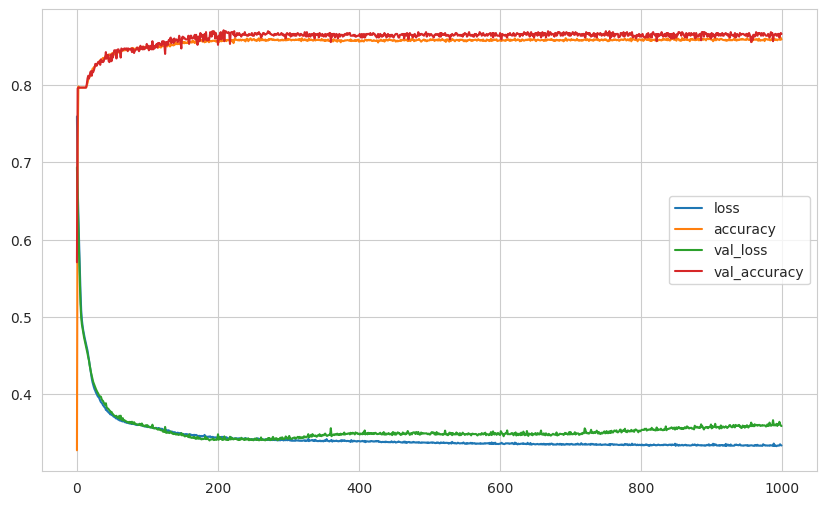

In [138]:
loss_df.plot()
plt.show()

In [140]:
loss, accuracy = model_noCW.evaluate(X_test, y_test, verbose=0)
print("loss: ", loss)
print("accuracy: ", accuracy)

loss:  0.38626477122306824
accuracy:  0.8506666421890259


In [141]:
y_train_pred = model_noCW.predict(X_train) > 0.5
print("Train Results-------------------------------------------------------")
print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

240/240 [==============================] - 1s 2ms/step
Train Results-------------------------------------------------------
[[5886  206]
 [ 872  686]]
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      6092
           1       0.77      0.44      0.56      1558

    accuracy                           0.86      7650
   macro avg       0.82      0.70      0.74      7650
weighted avg       0.85      0.86      0.84      7650



In [142]:
y_pred = model_noCW.predict(X_test) > 0.5
print("Test Results-------------------------------------------------------")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

47/47 [==============================] - 0s 2ms/step
Test Results-------------------------------------------------------
[[1141   53]
 [ 171  135]]
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1194
           1       0.72      0.44      0.55       306

    accuracy                           0.85      1500
   macro avg       0.79      0.70      0.73      1500
weighted avg       0.84      0.85      0.84      1500



47/47 [==============================] - 0s 2ms/step


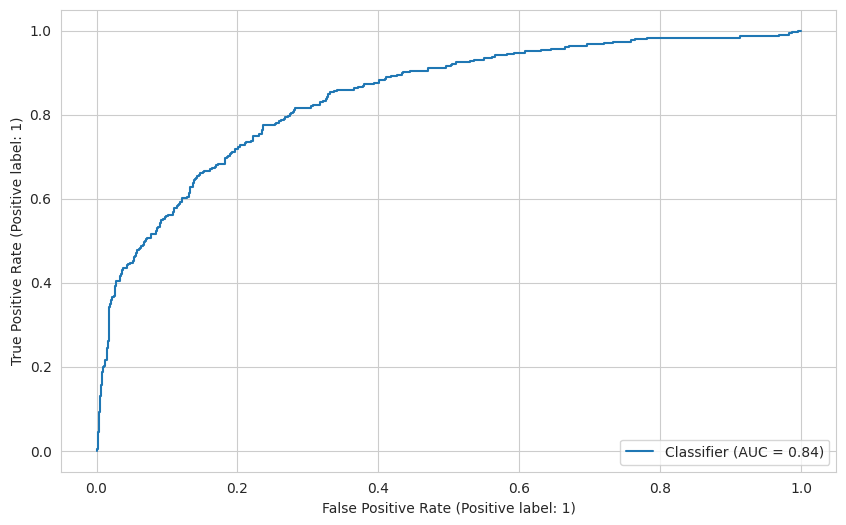

In [143]:
y_pred_proba = model_noCW.predict(X_test)
RocCurveDisplay.from_predictions(y_test, y_pred_proba)

In [ ]:
model_noCW.save("model_noCW.h5")

In [147]:
model_noCW_auc = roc_auc_score(y_test, y_pred_proba)
model_noCW_acc = accuracy
model_noCW_loss = loss
print("Results of the Model without class weight:")
print(f"AUC: {model_noCW_auc}, accuracy: {model_noCW_acc}, loss: {model_noCW_loss}")


Results of the Model without class weight:
AUC: 0.8425159566897669, accuracy: 0.8506666421890259, loss: 0.38626477122306824


## with class_weigth

Investigate how the "class_weight" hyper-parameter is used in a Neural Network.

### Create The Model

In [148]:
C_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {0: C_weights[0], 1: C_weights[1]}

In [149]:
class_weights

{0: 0.6278726198292843, 1: 2.4550706033376124}

In [150]:
tf.random.set_seed(SEED)

model_CW = Sequential()

model_CW.add(Dense(units=8, activation="relu", input_dim=X_train.shape[1]))
model_CW.add(Dense(units=6, activation="relu"))
model_CW.add(Dense(units=4, activation="relu"))
model_CW.add(Dense(units=1, activation="sigmoid"))

model_CW.compile(optimizer="adam", loss="binary_crossentropy", metrics = ['accuracy'])

In [151]:
model_CW.fit(x=X_train, y=y_train, validation_data=(X_val,y_val), batch_size=128, epochs=1000, class_weight=class_weights)

Epoch 1/1000
60/60 [==============================] - 1s 7ms/step - loss: 0.6916 - accuracy: 0.3780 - val_loss: 0.6945 - val_accuracy: 0.5447
Epoch 2/1000
60/60 [==============================] - 0s 4ms/step - loss: 0.6796 - accuracy: 0.5571 - val_loss: 0.6321 - val_accuracy: 0.6494
Epoch 3/1000
60/60 [==============================] - 0s 5ms/step - loss: 0.6616 - accuracy: 0.6152 - val_loss: 0.6393 - val_accuracy: 0.6294
Epoch 4/1000
60/60 [==============================] - 0s 4ms/step - loss: 0.6448 - accuracy: 0.6557 - val_loss: 0.6282 - val_accuracy: 0.6612
Epoch 5/1000
60/60 [==============================] - 0s 4ms/step - loss: 0.6301 - accuracy: 0.6539 - val_loss: 0.6253 - val_accuracy: 0.6459
Epoch 6/1000
60/60 [==============================] - 0s 4ms/step - loss: 0.6212 - accuracy: 0.6480 - val_loss: 0.6052 - val_accuracy: 0.6682
Epoch 7/1000
60/60 [==============================] - 0s 4ms/step - loss: 0.6130 - accuracy: 0.6641 - val_loss: 0.6629 - val_accuracy: 0.6200
Epoch 

In [152]:
model_CW.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 8)                 112       
                                                                 
 dense_9 (Dense)             (None, 6)                 54        
                                                                 
 dense_10 (Dense)            (None, 4)                 28        
                                                                 
 dense_11 (Dense)            (None, 1)                 5         
                                                                 
Total params: 199 (796.00 Byte)
Trainable params: 199 (796.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Evaluate The Model

- Plot the model history to observe the changing of metrics
- Make prediction to see "confusion matrix" and "classification report"
- Check ROC (Receiver Operating Curve) and AUC (Area Under Curve) for the model

In [153]:
loss_df = pd.DataFrame(model_CW.history.history)
loss_df.head()

loss  accuracy  val_loss  val_accuracy
0 0.692     0.378     0.695         0.545
1 0.680     0.557     0.632         0.649
2 0.662     0.615     0.639         0.629
3 0.645     0.656     0.628         0.661
4 0.630     0.654     0.625         0.646

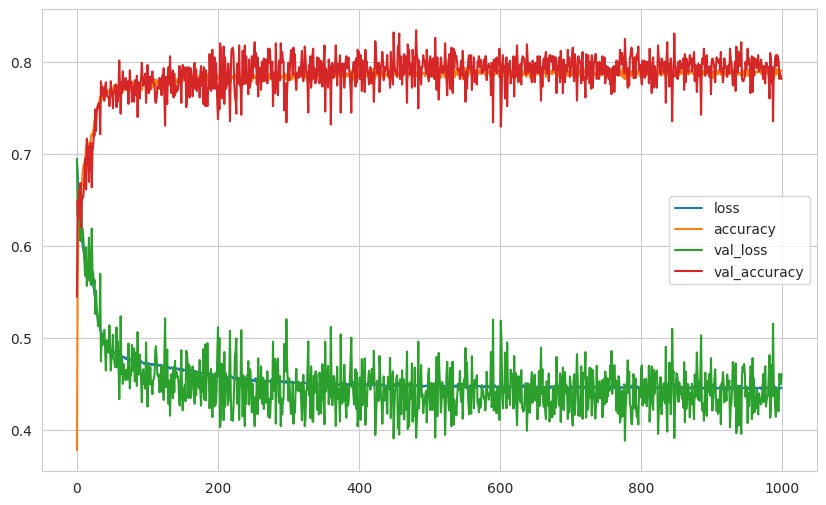

In [154]:
loss_df.plot()
plt.show()

In [155]:
loss, accuracy = model_CW.evaluate(X_test, y_test, verbose=0)
print("loss: ", loss)
print("accuracy: ", accuracy)

loss:  0.4731208384037018
accuracy:  0.762666642665863


In [156]:
y_train_pred = model_CW.predict(X_train) > 0.5
print("Train Result------------------------------------------")
print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

240/240 [==============================] - 1s 3ms/step
Train Result------------------------------------------
[[4692 1400]
 [ 318 1240]]
              precision    recall  f1-score   support

           0       0.94      0.77      0.85      6092
           1       0.47      0.80      0.59      1558

    accuracy                           0.78      7650
   macro avg       0.70      0.78      0.72      7650
weighted avg       0.84      0.78      0.79      7650



In [157]:
y_pred = model_CW.predict(X_test) > 0.5
print("Test Result------------------------------------------")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

47/47 [==============================] - 0s 2ms/step
Test Result------------------------------------------
[[897 297]
 [ 59 247]]
              precision    recall  f1-score   support

           0       0.94      0.75      0.83      1194
           1       0.45      0.81      0.58       306

    accuracy                           0.76      1500
   macro avg       0.70      0.78      0.71      1500
weighted avg       0.84      0.76      0.78      1500



47/47 [==============================] - 0s 2ms/step


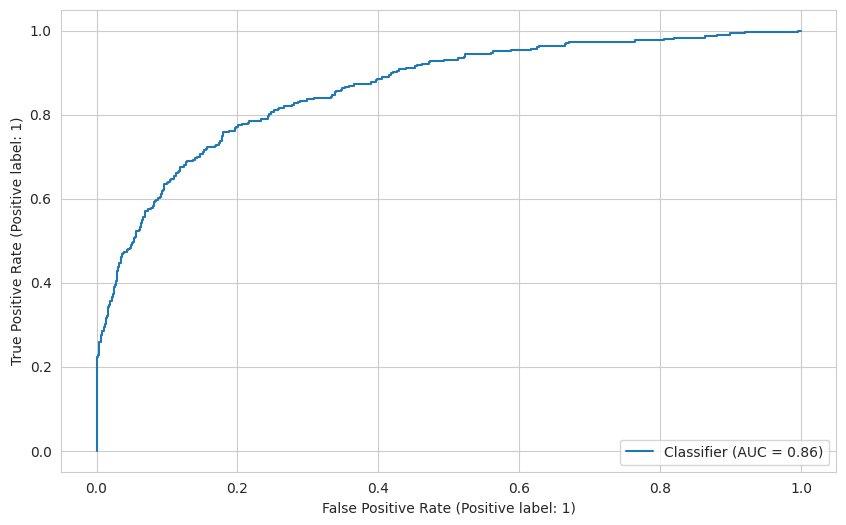

In [158]:
y_pred_proba = model_CW.predict(X_test)
RocCurveDisplay.from_predictions(y_test, y_pred_proba)

In [159]:
model_CW.save("model_CW.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [173]:
model_CW_auc = roc_auc_score(y_test, y_pred_proba)
model_CW_acc = accuracy
model_CW_loss = loss
print("Results of the Model with class weight:")
print(f"AUC: {model_CW_auc}, accuracy: {model_CW_acc}, loss: {model_CW_loss}")


Results of the Model with class weight:
AUC: 0.8462902749039315, accuracy: 0.7846666574478149, loss: 0.4576256573200226


## Implementation Different Methods to Develop The Model

- Implement the following methods on model creating with "class_weight" parameter
- Create and evaluate model for each method

### Increase The Learning Rate and Observe The Results

In [161]:
C_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {0: C_weights[0], 1: C_weights[1]}

In [162]:
tf.random.set_seed(SEED)

model_CW_lr = Sequential()

model_CW_lr.add(Dense(units=8, activation="relu", input_dim=X_train.shape[1]))
model_CW_lr.add(Dense(units=6, activation="relu"))
model_CW_lr.add(Dense(units=4, activation="relu"))
model_CW_lr.add(Dense(units=1, activation="sigmoid"))

opt = Adam(learning_rate=0.005)
model_CW_lr.compile(optimizer=opt, loss="binary_crossentropy", metrics = ['accuracy'])

In [163]:
model_CW_lr.fit(x=X_train, y=y_train, validation_data=(X_val,y_val), batch_size=128, epochs=1000, class_weight=class_weights)

Epoch 1/1000
60/60 [==============================] - 2s 7ms/step - loss: 0.6893 - accuracy: 0.4804 - val_loss: 0.6865 - val_accuracy: 0.5847
Epoch 2/1000
60/60 [==============================] - 0s 4ms/step - loss: 0.6443 - accuracy: 0.6397 - val_loss: 0.6385 - val_accuracy: 0.6741
Epoch 3/1000
60/60 [==============================] - 0s 4ms/step - loss: 0.6079 - accuracy: 0.6697 - val_loss: 0.5339 - val_accuracy: 0.7459
Epoch 4/1000
60/60 [==============================] - 0s 4ms/step - loss: 0.5898 - accuracy: 0.6987 - val_loss: 0.6559 - val_accuracy: 0.6341
Epoch 5/1000
60/60 [==============================] - 0s 4ms/step - loss: 0.5773 - accuracy: 0.7132 - val_loss: 0.6949 - val_accuracy: 0.6106
Epoch 6/1000
60/60 [==============================] - 0s 5ms/step - loss: 0.5673 - accuracy: 0.7242 - val_loss: 0.5219 - val_accuracy: 0.7576
Epoch 7/1000
60/60 [==============================] - 0s 5ms/step - loss: 0.5338 - accuracy: 0.7477 - val_loss: 0.6608 - val_accuracy: 0.6671
Epoch 

In [164]:
model_CW_lr.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 8)                 112       
                                                                 
 dense_13 (Dense)            (None, 6)                 54        
                                                                 
 dense_14 (Dense)            (None, 4)                 28        
                                                                 
 dense_15 (Dense)            (None, 1)                 5         
                                                                 
Total params: 199 (796.00 Byte)
Trainable params: 199 (796.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [165]:
loss_df = pd.DataFrame(model_CW_lr.history.history)
loss_df.head()

loss  accuracy  val_loss  val_accuracy
0 0.689     0.480     0.686         0.585
1 0.644     0.640     0.638         0.674
2 0.608     0.670     0.534         0.746
3 0.590     0.699     0.656         0.634
4 0.577     0.713     0.695         0.611

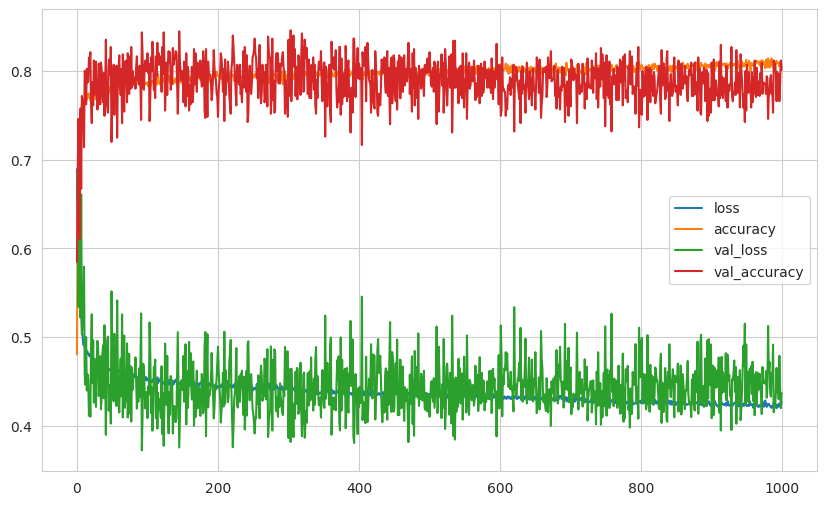

In [166]:
loss_df.plot()
plt.show()

In [189]:
loss, accuracy = model_CW_lr.evaluate(X_test, y_test, verbose=0)
print("loss: ", loss)
print("accuracy: ", accuracy)

loss:  0.4576256573200226
accuracy:  0.7846666574478149


In [168]:
y_train_pred = model_CW_lr.predict(X_train) > 0.5
print("Train Result: ---------------------------------")
print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

240/240 [==============================] - 1s 3ms/step
Train Result: ---------------------------------
[[5023 1069]
 [ 341 1217]]
              precision    recall  f1-score   support

           0       0.94      0.82      0.88      6092
           1       0.53      0.78      0.63      1558

    accuracy                           0.82      7650
   macro avg       0.73      0.80      0.76      7650
weighted avg       0.85      0.82      0.83      7650



In [186]:
y_pred = model_CW_lr.predict(X_test) > 0.5
print("Test Result: ---------------------------------")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

47/47 [==============================] - 0s 3ms/step
Test Result: ---------------------------------
[[957 237]
 [ 86 220]]
              precision    recall  f1-score   support

           0       0.92      0.80      0.86      1194
           1       0.48      0.72      0.58       306

    accuracy                           0.78      1500
   macro avg       0.70      0.76      0.72      1500
weighted avg       0.83      0.78      0.80      1500



47/47 [==============================] - 0s 2ms/step


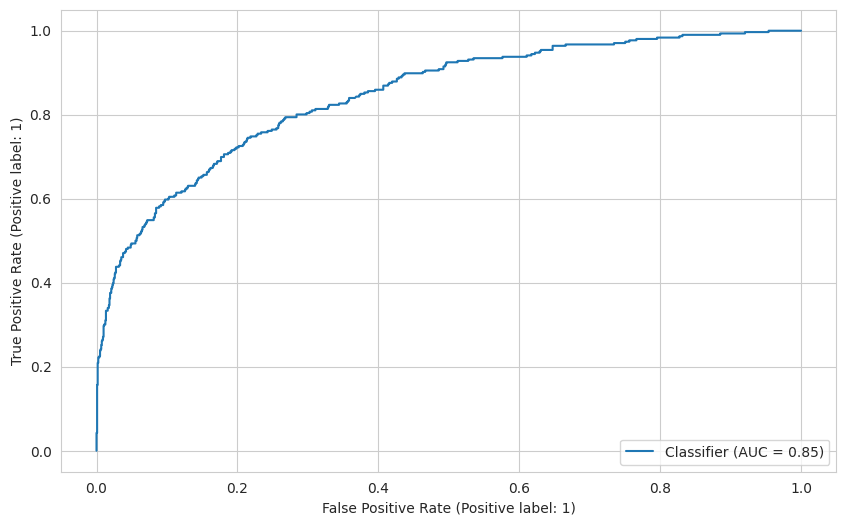

In [190]:
y_pred_proba = model_CW_lr.predict(X_test)
RocCurveDisplay.from_predictions(y_test, y_pred_proba)

In [171]:
model_CW_lr.save("model_CW_lr.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [191]:
model_CW_lr_auc = roc_auc_score(y_test, y_pred_proba)
model_CW_lr_acc = accuracy
model_CW_lr_loss = loss
print("Results of the Model with class weight and increasing the learning rate:")
print(f"AUC: {model_CW_lr_auc}, accuracy: {model_CW_lr_acc}, loss: {model_CW_lr_loss}")


Results of the Model with class weight and increasing the learning rate:
AUC: 0.8462902749039315, accuracy: 0.7846666574478149, loss: 0.4576256573200226


### Add Dropout Layer

In [174]:
tf.random.set_seed(SEED)

model_CW_lr_DO = Sequential()

model_CW_lr_DO.add(Dense(units=8, activation="relu", input_dim=X_train.shape[1]))
model_CW_lr_DO.add(Dropout(0.5))

model_CW_lr_DO.add(Dense(units=6, activation="relu"))
model_CW_lr_DO.add(Dropout(0.5))

model_CW_lr_DO.add(Dense(units=4, activation="relu"))
model_CW_lr_DO.add(Dropout(0.5))

model_CW_lr_DO.add(Dense(units=1, activation="sigmoid"))

opt = Adam(learning_rate=0.005)
model_CW_lr_DO.compile(optimizer=opt, loss="binary_crossentropy", metrics = ['accuracy'])

In [175]:
model_CW_lr_DO.fit(x=X_train, y=y_train, validation_data=(X_val,y_val), batch_size=128, epochs=1000, class_weight=class_weights)

Epoch 1/1000
60/60 [==============================] - 3s 7ms/step - loss: 0.7192 - accuracy: 0.3073 - val_loss: 0.6988 - val_accuracy: 0.2118
Epoch 2/1000
60/60 [==============================] - 0s 5ms/step - loss: 0.6916 - accuracy: 0.4174 - val_loss: 0.6873 - val_accuracy: 0.7412
Epoch 3/1000
60/60 [==============================] - 0s 5ms/step - loss: 0.6885 - accuracy: 0.7452 - val_loss: 0.6887 - val_accuracy: 0.7282
Epoch 4/1000
60/60 [==============================] - 0s 5ms/step - loss: 0.6874 - accuracy: 0.7342 - val_loss: 0.6785 - val_accuracy: 0.7612
Epoch 5/1000
60/60 [==============================] - 0s 5ms/step - loss: 0.6880 - accuracy: 0.7426 - val_loss: 0.6766 - val_accuracy: 0.7847
Epoch 6/1000
60/60 [==============================] - 0s 5ms/step - loss: 0.6843 - accuracy: 0.7418 - val_loss: 0.6699 - val_accuracy: 0.7671
Epoch 7/1000
60/60 [==============================] - 0s 5ms/step - loss: 0.6805 - accuracy: 0.7384 - val_loss: 0.6724 - val_accuracy: 0.6671
Epoch 

In [192]:
model_CW_lr_DO.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 8)                 112       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_17 (Dense)            (None, 6)                 54        
                                                                 
 dropout_1 (Dropout)         (None, 6)                 0         
                                                                 
 dense_18 (Dense)            (None, 4)                 28        
                                                                 
 dropout_2 (Dropout)         (None, 4)                 0         
                                                                 
 dense_19 (Dense)            (None, 1)                

In [176]:
loss_df = pd.DataFrame(model_CW_lr_DO.history.history)
loss_df.head()

loss  accuracy  val_loss  val_accuracy
0 0.719     0.307     0.699         0.212
1 0.692     0.417     0.687         0.741
2 0.689     0.745     0.689         0.728
3 0.687     0.734     0.678         0.761
4 0.688     0.743     0.677         0.785

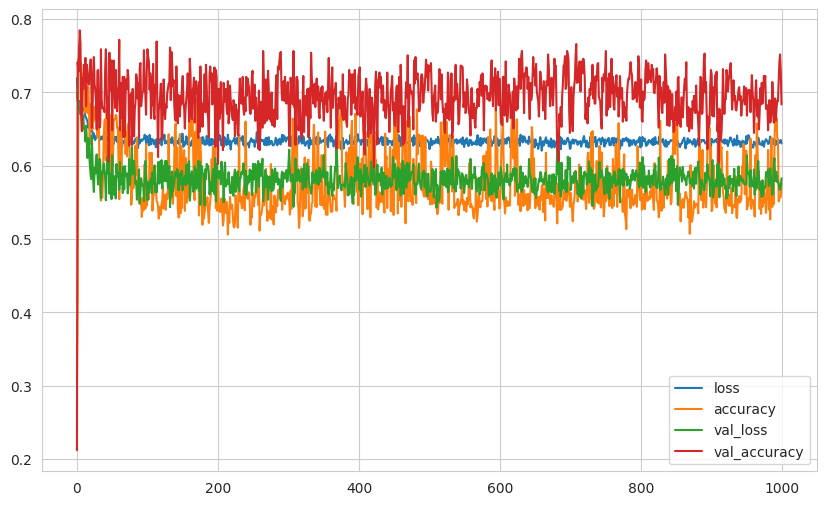

In [178]:
loss_df.plot()
plt.show()

In [193]:
loss, accuracy = model_CW_lr_DO.evaluate(X_test, y_test, verbose=0)
print("loss: ", loss)
print("accuracy: ", accuracy)

loss:  0.5844212770462036
accuracy:  0.6986666917800903


In [180]:
y_train_pred = model_CW_lr_DO.predict(X_train) > 0.5
print("Train Result: ---------------------------------")
print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

240/240 [==============================] - 0s 2ms/step
Train Result: ---------------------------------
[[4249 1843]
 [ 355 1203]]
              precision    recall  f1-score   support

           0       0.92      0.70      0.79      6092
           1       0.39      0.77      0.52      1558

    accuracy                           0.71      7650
   macro avg       0.66      0.73      0.66      7650
weighted avg       0.82      0.71      0.74      7650



In [181]:
y_pred = model_CW_lr_DO.predict(X_test) > 0.5
print("Test Result: ----------------------------------------")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

47/47 [==============================] - 0s 2ms/step
Test Result: ----------------------------------------
[[816 378]
 [ 74 232]]
              precision    recall  f1-score   support

           0       0.92      0.68      0.78      1194
           1       0.38      0.76      0.51       306

    accuracy                           0.70      1500
   macro avg       0.65      0.72      0.64      1500
weighted avg       0.81      0.70      0.73      1500



47/47 [==============================] - 0s 2ms/step


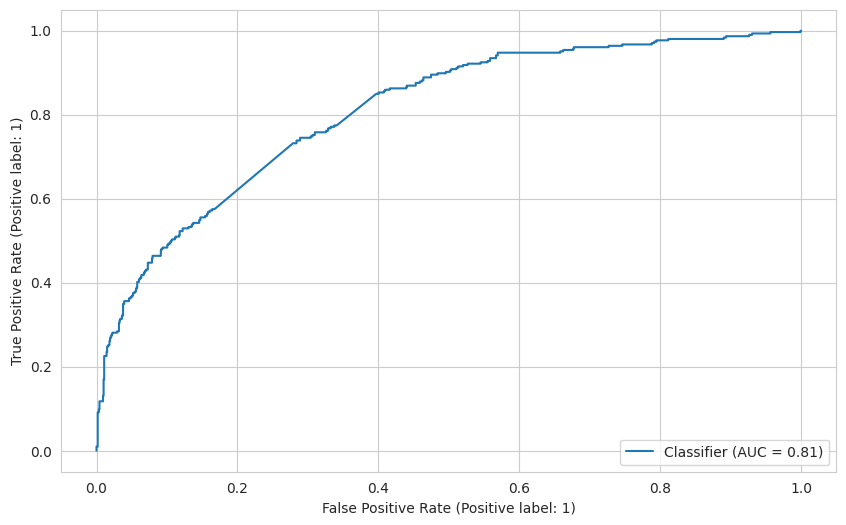

In [182]:
y_pred_proba = model_CW_lr_DO.predict(X_test)
RocCurveDisplay.from_predictions(y_test, y_pred_proba)

In [183]:
model_CW_lr_DO.save("model_CW_lr_DO.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [184]:
model_CW_lr_DO_auc = roc_auc_score(y_test, y_pred_proba)
model_CW_lr_DO_acc = accuracy
model_CW_lr_DO_loss = loss
print("Results of the Model with class weight, increasing the learning rate and dropout layer:")
print(f"AUC: {model_CW_lr_DO_auc}, accuracy: {model_CW_lr_DO_acc}, loss: {model_CW_lr_DO_loss}")


Results of the Model with class weight, increasing the learning rate and dropout layer:
AUC: 0.8080749608609497, accuracy: 0.6986666917800903, loss: 0.5844212770462036


### Add Early Stop

#### Monitor the "val_loss" as metric

In [194]:
tf.random.set_seed(SEED)

model_CW_lr_DO_lossES = Sequential()

model_CW_lr_DO_lossES.add(Dense(units=8, activation="relu", input_dim=X_train.shape[1]))
model_CW_lr_DO_lossES.add(Dropout(0.5))

model_CW_lr_DO_lossES.add(Dense(units=6, activation="relu"))
model_CW_lr_DO_lossES.add(Dropout(0.5))

model_CW_lr_DO_lossES.add(Dense(units=4, activation="relu"))
model_CW_lr_DO_lossES.add(Dropout(0.5))

model_CW_lr_DO_lossES.add(Dense(units=1, activation="sigmoid"))

opt = Adam(learning_rate=0.005)
model_CW_lr_DO_lossES.compile(optimizer=opt, loss="binary_crossentropy", metrics = ['accuracy'])

In [196]:
early_stop_vloss = EarlyStopping( monitor="val_loss", mode="min", verbose=1, patience=15, restore_best_weights=True)

In [197]:
model_CW_lr_DO_lossES.fit(x=X_train, y=y_train, validation_data=(X_val,y_val), batch_size=128, epochs=1000, callbacks=[early_stop_vloss], class_weight=class_weights)

Epoch 1/1000
60/60 [==============================] - 2s 8ms/step - loss: 0.7025 - accuracy: 0.5898 - val_loss: 0.6834 - val_accuracy: 0.7694
Epoch 2/1000
60/60 [==============================] - 0s 5ms/step - loss: 0.6898 - accuracy: 0.7231 - val_loss: 0.6840 - val_accuracy: 0.7518
Epoch 3/1000
60/60 [==============================] - 0s 5ms/step - loss: 0.6878 - accuracy: 0.7165 - val_loss: 0.6849 - val_accuracy: 0.7200
Epoch 4/1000
60/60 [==============================] - 0s 5ms/step - loss: 0.6843 - accuracy: 0.7248 - val_loss: 0.6704 - val_accuracy: 0.7176
Epoch 5/1000
60/60 [==============================] - 0s 5ms/step - loss: 0.6753 - accuracy: 0.7227 - val_loss: 0.6532 - val_accuracy: 0.7200
Epoch 6/1000
60/60 [==============================] - 0s 5ms/step - loss: 0.6771 - accuracy: 0.7251 - val_loss: 0.6614 - val_accuracy: 0.7141
Epoch 7/1000
60/60 [==============================] - 0s 4ms/step - loss: 0.6719 - accuracy: 0.7324 - val_loss: 0.6794 - val_accuracy: 0.6612
Epoch 

In [199]:
model_CW_lr_DO_lossES.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 8)                 112       
                                                                 
 dropout_3 (Dropout)         (None, 8)                 0         
                                                                 
 dense_21 (Dense)            (None, 6)                 54        
                                                                 
 dropout_4 (Dropout)         (None, 6)                 0         
                                                                 
 dense_22 (Dense)            (None, 4)                 28        
                                                                 
 dropout_5 (Dropout)         (None, 4)                 0         
                                                                 
 dense_23 (Dense)            (None, 1)                

In [200]:
loss_df = pd.DataFrame(model_CW_lr_DO_lossES.history.history)
loss_df.head()

loss  accuracy  val_loss  val_accuracy
0 0.703     0.590     0.683         0.769
1 0.690     0.723     0.684         0.752
2 0.688     0.716     0.685         0.720
3 0.684     0.725     0.670         0.718
4 0.675     0.723     0.653         0.720

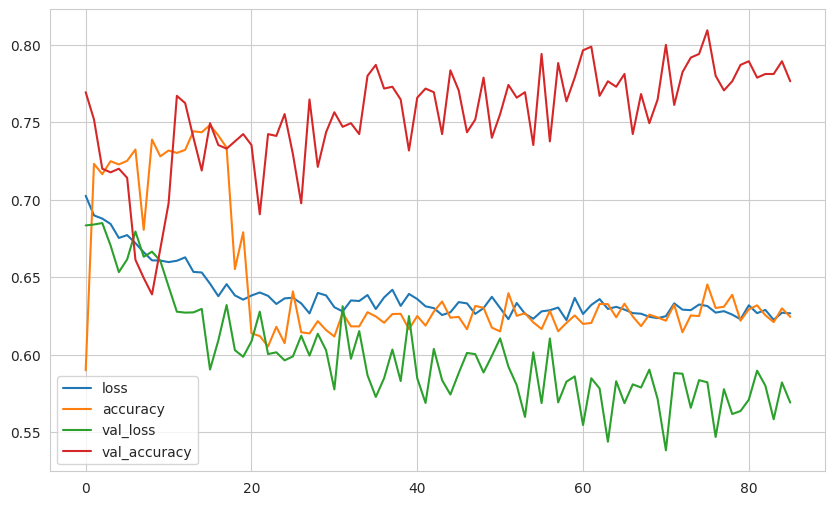

In [201]:
loss_df.plot()
plt.show()

In [208]:
loss, accuracy = model_CW_lr_DO_lossES.evaluate(X_test, y_test, verbose=0)
print("loss: ", loss)
print("accuracy: ", accuracy)

loss:  0.5476378202438354
accuracy:  0.7913333177566528


In [203]:
y_train_pred = model_CW_lr_DO_lossES.predict(X_train) > 0.5
print("Train Result: -------------------------")
print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

240/240 [==============================] - 1s 3ms/step
Train Result: -------------------------
[[5049 1043]
 [ 489 1069]]
              precision    recall  f1-score   support

           0       0.91      0.83      0.87      6092
           1       0.51      0.69      0.58      1558

    accuracy                           0.80      7650
   macro avg       0.71      0.76      0.73      7650
weighted avg       0.83      0.80      0.81      7650



In [204]:
y_pred = model_CW_lr_DO_lossES.predict(X_test) > 0.5
print("Test Result: -------------------------")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

47/47 [==============================] - 0s 2ms/step
Test Result: -------------------------
[[979 215]
 [ 98 208]]
              precision    recall  f1-score   support

           0       0.91      0.82      0.86      1194
           1       0.49      0.68      0.57       306

    accuracy                           0.79      1500
   macro avg       0.70      0.75      0.72      1500
weighted avg       0.82      0.79      0.80      1500



47/47 [==============================] - 0s 3ms/step


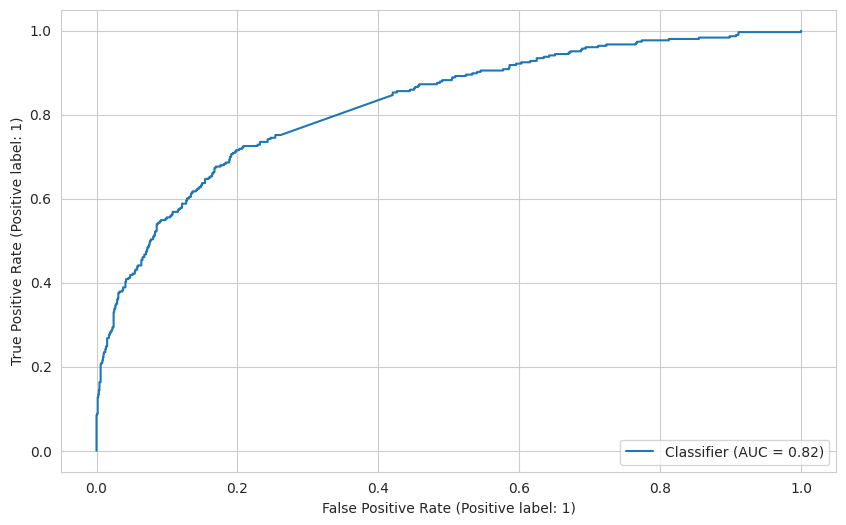

In [209]:
y_pred_proba = model_CW_lr_DO_lossES.predict(X_test)
RocCurveDisplay.from_predictions(y_test, y_pred_proba)

In [205]:
model_CW_lr_DO_lossES.save("model_CW_lr_DO_lossES.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [210]:
model_CW_lr_DO_lossES_auc = roc_auc_score(y_test, y_pred_proba)
model_CW_lr_DO_lossES_acc = accuracy
model_CW_lr_DO_lossES_loss = loss
print("Results of the Model with class weight, increasing the learning rate, dropout layer and early stopping(val_loss):")
print(f"AUC: {model_CW_lr_DO_lossES_auc}, accuracy: {model_CW_lr_DO_lossES_acc}, loss: {model_CW_lr_DO_lossES_loss}")

Results of the Model with class weight, increasing the learning rate, dropout layer and early stopping(val_loss):
AUC: 0.8232023406794321, accuracy: 0.7913333177566528, loss: 0.5476378202438354


#### Monitor the "val_recall" as metric

In [211]:
tf.random.set_seed(SEED)

model_CW_lr_DO_recallES = Sequential()

model_CW_lr_DO_recallES.add(Dense(units=8, activation="relu", input_dim=X_train.shape[1]))
model_CW_lr_DO_recallES.add(Dropout(0.5))

model_CW_lr_DO_recallES.add(Dense(units=6, activation="relu"))
model_CW_lr_DO_recallES.add(Dropout(0.5))

model_CW_lr_DO_recallES.add(Dense(units=4, activation="relu"))
model_CW_lr_DO_recallES.add(Dropout(0.5))

model_CW_lr_DO_recallES.add(Dense(units=1, activation="sigmoid"))

opt = Adam(learning_rate=0.005)
model_CW_lr_DO_recallES.compile(optimizer=opt, loss="binary_crossentropy", metrics = ['accuracy'])

In [212]:
early_stop_vRecall= EarlyStopping( monitor="val_recall", mode="min", verbose=1, patience=15, restore_best_weights=True)

In [213]:
model_CW_lr_DO_recallES.fit(x=X_train, y=y_train, validation_data=(X_val,y_val), batch_size=128, epochs=1000, callbacks=[early_stop_vRecall], class_weight=class_weights)

Epoch 1/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.7088 - accuracy: 0.2855

60/60 [==============================] - 2s 7ms/step - loss: 0.7084 - accuracy: 0.2820 - val_loss: 0.7040 - val_accuracy: 0.2035
Epoch 2/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6906 - accuracy: 0.3003

60/60 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.3353 - val_loss: 0.6916 - val_accuracy: 0.7259
Epoch 3/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6920 - accuracy: 0.7580

60/60 [==============================] - 0s 4ms/step - loss: 0.6903 - accuracy: 0.7600 - val_loss: 0.6924 - val_accuracy: 0.6412
Epoch 4/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6871 - accuracy: 0.7631

60/60 [==============================] - 0s 5ms/step - loss: 0.6899 - accuracy: 0.7626 - val_loss: 0.6846 - val_accuracy: 0.7965
Epoch 5/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6865 - accuracy: 0.7725

60/60 [==============================] - 0s 5ms/step - loss: 0.6901 - accuracy: 0.7706 - val_loss: 0.6882 - val_accuracy: 0.7788
Epoch 6/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6851 - accuracy: 0.6828

60/60 [==============================] - 0s 5ms/step - loss: 0.6874 - accuracy: 0.6533 - val_loss: 0.6862 - val_accuracy: 0.5176
Epoch 7/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6841 - accuracy: 0.5848

60/60 [==============================] - 0s 5ms/step - loss: 0.6889 - accuracy: 0.5735 - val_loss: 0.6948 - val_accuracy: 0.3788
Epoch 8/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6855 - accuracy: 0.2998

60/60 [==============================] - 0s 7ms/step - loss: 0.6849 - accuracy: 0.2999 - val_loss: 0.6870 - val_accuracy: 0.5400
Epoch 9/1000
51/60 [========================>.....] - ETA: 0s - loss: 0.6805 - accuracy: 0.3107

60/60 [==============================] - 0s 7ms/step - loss: 0.6826 - accuracy: 0.3131 - val_loss: 0.6995 - val_accuracy: 0.3718
Epoch 10/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6795 - accuracy: 0.4155

60/60 [==============================] - 0s 6ms/step - loss: 0.6818 - accuracy: 0.4399 - val_loss: 0.6827 - val_accuracy: 0.6212
Epoch 11/1000
60/60 [==============================] - ETA: 0s - loss: 0.6821 - accuracy: 0.4952

60/60 [==============================] - 0s 7ms/step - loss: 0.6821 - accuracy: 0.4952 - val_loss: 0.6863 - val_accuracy: 0.6271
Epoch 12/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6814 - accuracy: 0.3945

60/60 [==============================] - 0s 5ms/step - loss: 0.6801 - accuracy: 0.3956 - val_loss: 0.6852 - val_accuracy: 0.6059
Epoch 13/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6832 - accuracy: 0.4393

60/60 [==============================] - 1s 10ms/step - loss: 0.6797 - accuracy: 0.4388 - val_loss: 0.6668 - val_accuracy: 0.6659
Epoch 14/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6796 - accuracy: 0.4350

60/60 [==============================] - 0s 8ms/step - loss: 0.6805 - accuracy: 0.4346 - val_loss: 0.6902 - val_accuracy: 0.4706
Epoch 15/1000
60/60 [==============================] - ETA: 0s - loss: 0.6778 - accuracy: 0.3461

60/60 [==============================] - 1s 9ms/step - loss: 0.6778 - accuracy: 0.3461 - val_loss: 0.6941 - val_accuracy: 0.4518
Epoch 16/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6746 - accuracy: 0.4494

60/60 [==============================] - 1s 10ms/step - loss: 0.6759 - accuracy: 0.4506 - val_loss: 0.6663 - val_accuracy: 0.7082
Epoch 17/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6690 - accuracy: 0.5099

60/60 [==============================] - 0s 6ms/step - loss: 0.6705 - accuracy: 0.5063 - val_loss: 0.6633 - val_accuracy: 0.7318
Epoch 18/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6718 - accuracy: 0.5049

60/60 [==============================] - 0s 6ms/step - loss: 0.6710 - accuracy: 0.5044 - val_loss: 0.6964 - val_accuracy: 0.4988
Epoch 19/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6762 - accuracy: 0.3906

60/60 [==============================] - 0s 6ms/step - loss: 0.6749 - accuracy: 0.3925 - val_loss: 0.6630 - val_accuracy: 0.6953
Epoch 20/1000
51/60 [========================>.....] - ETA: 0s - loss: 0.6768 - accuracy: 0.4194

60/60 [==============================] - 0s 5ms/step - loss: 0.6731 - accuracy: 0.4163 - val_loss: 0.6712 - val_accuracy: 0.7365
Epoch 21/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6673 - accuracy: 0.4754

60/60 [==============================] - 1s 9ms/step - loss: 0.6694 - accuracy: 0.4800 - val_loss: 0.6431 - val_accuracy: 0.7682
Epoch 22/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6672 - accuracy: 0.4713

60/60 [==============================] - 1s 9ms/step - loss: 0.6678 - accuracy: 0.4686 - val_loss: 0.6764 - val_accuracy: 0.6788
Epoch 23/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6639 - accuracy: 0.4416

60/60 [==============================] - 1s 9ms/step - loss: 0.6646 - accuracy: 0.4484 - val_loss: 0.6582 - val_accuracy: 0.7318
Epoch 24/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6591 - accuracy: 0.5254

60/60 [==============================] - 0s 6ms/step - loss: 0.6581 - accuracy: 0.5256 - val_loss: 0.6693 - val_accuracy: 0.7047
Epoch 25/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6620 - accuracy: 0.5295

60/60 [==============================] - 1s 17ms/step - loss: 0.6623 - accuracy: 0.5302 - val_loss: 0.6517 - val_accuracy: 0.7612
Epoch 26/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6593 - accuracy: 0.5182

60/60 [==============================] - 1s 21ms/step - loss: 0.6604 - accuracy: 0.5166 - val_loss: 0.6559 - val_accuracy: 0.7224
Epoch 27/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6542 - accuracy: 0.5595

60/60 [==============================] - 1s 9ms/step - loss: 0.6536 - accuracy: 0.5620 - val_loss: 0.6032 - val_accuracy: 0.7482
Epoch 28/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6498 - accuracy: 0.6224

60/60 [==============================] - 1s 12ms/step - loss: 0.6512 - accuracy: 0.6203 - val_loss: 0.6539 - val_accuracy: 0.6965
Epoch 29/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6580 - accuracy: 0.6194

60/60 [==============================] - 1s 12ms/step - loss: 0.6577 - accuracy: 0.6182 - val_loss: 0.6335 - val_accuracy: 0.7435
Epoch 30/1000
51/60 [========================>.....] - ETA: 0s - loss: 0.6505 - accuracy: 0.6181

60/60 [==============================] - 1s 9ms/step - loss: 0.6529 - accuracy: 0.6175 - val_loss: 0.6390 - val_accuracy: 0.7153
Epoch 31/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6587 - accuracy: 0.6202

60/60 [==============================] - 1s 8ms/step - loss: 0.6578 - accuracy: 0.6222 - val_loss: 0.6361 - val_accuracy: 0.7447
Epoch 32/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6439 - accuracy: 0.6344

60/60 [==============================] - 0s 8ms/step - loss: 0.6438 - accuracy: 0.6341 - val_loss: 0.6519 - val_accuracy: 0.7176
Epoch 33/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6541 - accuracy: 0.6107

60/60 [==============================] - 0s 6ms/step - loss: 0.6547 - accuracy: 0.6120 - val_loss: 0.6453 - val_accuracy: 0.7435
Epoch 34/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6570 - accuracy: 0.6201

60/60 [==============================] - 0s 8ms/step - loss: 0.6544 - accuracy: 0.6193 - val_loss: 0.6747 - val_accuracy: 0.6518
Epoch 35/1000
60/60 [==============================] - ETA: 0s - loss: 0.6542 - accuracy: 0.6314

60/60 [==============================] - 1s 11ms/step - loss: 0.6542 - accuracy: 0.6314 - val_loss: 0.6202 - val_accuracy: 0.7635
Epoch 36/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6548 - accuracy: 0.6194

60/60 [==============================] - 0s 6ms/step - loss: 0.6536 - accuracy: 0.6222 - val_loss: 0.6047 - val_accuracy: 0.7647
Epoch 37/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6490 - accuracy: 0.6246

60/60 [==============================] - 0s 6ms/step - loss: 0.6496 - accuracy: 0.6243 - val_loss: 0.6364 - val_accuracy: 0.6918
Epoch 38/1000
60/60 [==============================] - ETA: 0s - loss: 0.6536 - accuracy: 0.6318

60/60 [==============================] - 0s 7ms/step - loss: 0.6536 - accuracy: 0.6318 - val_loss: 0.6389 - val_accuracy: 0.6871
Epoch 39/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6481 - accuracy: 0.6195

60/60 [==============================] - 0s 6ms/step - loss: 0.6489 - accuracy: 0.6192 - val_loss: 0.6182 - val_accuracy: 0.7259
Epoch 40/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6457 - accuracy: 0.6268

60/60 [==============================] - 0s 6ms/step - loss: 0.6482 - accuracy: 0.6265 - val_loss: 0.6209 - val_accuracy: 0.7165
Epoch 41/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6531 - accuracy: 0.6123

60/60 [==============================] - 0s 8ms/step - loss: 0.6527 - accuracy: 0.6131 - val_loss: 0.6250 - val_accuracy: 0.7106
Epoch 42/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6481 - accuracy: 0.6476

60/60 [==============================] - 1s 9ms/step - loss: 0.6450 - accuracy: 0.6506 - val_loss: 0.5894 - val_accuracy: 0.7800
Epoch 43/1000
60/60 [==============================] - ETA: 0s - loss: 0.6502 - accuracy: 0.6473

60/60 [==============================] - 1s 11ms/step - loss: 0.6502 - accuracy: 0.6473 - val_loss: 0.6360 - val_accuracy: 0.6847
Epoch 44/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6482 - accuracy: 0.6455

60/60 [==============================] - 1s 10ms/step - loss: 0.6464 - accuracy: 0.6447 - val_loss: 0.6103 - val_accuracy: 0.6906
Epoch 45/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6432 - accuracy: 0.6347

60/60 [==============================] - 1s 9ms/step - loss: 0.6435 - accuracy: 0.6356 - val_loss: 0.5931 - val_accuracy: 0.7529
Epoch 46/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6433 - accuracy: 0.6388

60/60 [==============================] - 1s 9ms/step - loss: 0.6449 - accuracy: 0.6367 - val_loss: 0.6171 - val_accuracy: 0.7165
Epoch 47/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6480 - accuracy: 0.6159

60/60 [==============================] - 1s 9ms/step - loss: 0.6495 - accuracy: 0.6163 - val_loss: 0.6109 - val_accuracy: 0.7518
Epoch 48/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6474 - accuracy: 0.6325

60/60 [==============================] - 1s 9ms/step - loss: 0.6458 - accuracy: 0.6329 - val_loss: 0.6215 - val_accuracy: 0.6965
Epoch 49/1000
60/60 [==============================] - ETA: 0s - loss: 0.6448 - accuracy: 0.6341

60/60 [==============================] - 1s 9ms/step - loss: 0.6448 - accuracy: 0.6341 - val_loss: 0.6148 - val_accuracy: 0.7176
Epoch 50/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6440 - accuracy: 0.6692

60/60 [==============================] - 0s 8ms/step - loss: 0.6474 - accuracy: 0.6707 - val_loss: 0.6119 - val_accuracy: 0.7188
Epoch 51/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6437 - accuracy: 0.6614

60/60 [==============================] - 1s 12ms/step - loss: 0.6447 - accuracy: 0.6533 - val_loss: 0.6680 - val_accuracy: 0.6812
Epoch 52/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6350 - accuracy: 0.6349

60/60 [==============================] - 1s 10ms/step - loss: 0.6360 - accuracy: 0.6358 - val_loss: 0.6182 - val_accuracy: 0.7341
Epoch 53/1000
60/60 [==============================] - ETA: 0s - loss: 0.6417 - accuracy: 0.6635

60/60 [==============================] - 1s 11ms/step - loss: 0.6417 - accuracy: 0.6635 - val_loss: 0.5952 - val_accuracy: 0.7541
Epoch 54/1000
60/60 [==============================] - ETA: 0s - loss: 0.6440 - accuracy: 0.6427

60/60 [==============================] - 1s 9ms/step - loss: 0.6440 - accuracy: 0.6427 - val_loss: 0.6046 - val_accuracy: 0.7706
Epoch 55/1000
60/60 [==============================] - ETA: 0s - loss: 0.6358 - accuracy: 0.6446

60/60 [==============================] - 1s 9ms/step - loss: 0.6358 - accuracy: 0.6446 - val_loss: 0.5992 - val_accuracy: 0.7482
Epoch 56/1000
60/60 [==============================] - ETA: 0s - loss: 0.6419 - accuracy: 0.6502

60/60 [==============================] - 1s 11ms/step - loss: 0.6419 - accuracy: 0.6502 - val_loss: 0.5718 - val_accuracy: 0.7694
Epoch 57/1000
51/60 [========================>.....] - ETA: 0s - loss: 0.6431 - accuracy: 0.6438

60/60 [==============================] - 1s 9ms/step - loss: 0.6452 - accuracy: 0.6390 - val_loss: 0.6286 - val_accuracy: 0.6988
Epoch 58/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6462 - accuracy: 0.6396

60/60 [==============================] - 1s 9ms/step - loss: 0.6439 - accuracy: 0.6348 - val_loss: 0.6216 - val_accuracy: 0.6953
Epoch 59/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6431 - accuracy: 0.6464

60/60 [==============================] - 0s 7ms/step - loss: 0.6417 - accuracy: 0.6465 - val_loss: 0.6221 - val_accuracy: 0.6988
Epoch 60/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6404 - accuracy: 0.6512

60/60 [==============================] - 0s 8ms/step - loss: 0.6419 - accuracy: 0.6486 - val_loss: 0.5853 - val_accuracy: 0.7482
Epoch 61/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6453 - accuracy: 0.6014

60/60 [==============================] - 0s 8ms/step - loss: 0.6450 - accuracy: 0.6025 - val_loss: 0.5739 - val_accuracy: 0.7600
Epoch 62/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6466 - accuracy: 0.6236

60/60 [==============================] - 1s 10ms/step - loss: 0.6451 - accuracy: 0.6264 - val_loss: 0.6229 - val_accuracy: 0.7341
Epoch 63/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6381 - accuracy: 0.6493

60/60 [==============================] - 1s 9ms/step - loss: 0.6414 - accuracy: 0.6497 - val_loss: 0.6112 - val_accuracy: 0.6976
Epoch 64/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6390 - accuracy: 0.6635

60/60 [==============================] - 0s 8ms/step - loss: 0.6361 - accuracy: 0.6654 - val_loss: 0.5830 - val_accuracy: 0.7282
Epoch 65/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6333 - accuracy: 0.6472

60/60 [==============================] - 1s 8ms/step - loss: 0.6360 - accuracy: 0.6465 - val_loss: 0.5913 - val_accuracy: 0.7247
Epoch 66/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6414 - accuracy: 0.6096

60/60 [==============================] - 1s 10ms/step - loss: 0.6419 - accuracy: 0.6108 - val_loss: 0.5879 - val_accuracy: 0.7365
Epoch 67/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6388 - accuracy: 0.6376

60/60 [==============================] - 0s 5ms/step - loss: 0.6380 - accuracy: 0.6378 - val_loss: 0.6138 - val_accuracy: 0.6965
Epoch 68/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6327 - accuracy: 0.6544

60/60 [==============================] - 0s 4ms/step - loss: 0.6346 - accuracy: 0.6477 - val_loss: 0.6054 - val_accuracy: 0.7400
Epoch 69/1000
48/60 [=======================>......] - ETA: 0s - loss: 0.6378 - accuracy: 0.6354

60/60 [==============================] - 0s 5ms/step - loss: 0.6387 - accuracy: 0.6264 - val_loss: 0.6043 - val_accuracy: 0.7471
Epoch 70/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6456 - accuracy: 0.5911

60/60 [==============================] - 0s 5ms/step - loss: 0.6427 - accuracy: 0.5963 - val_loss: 0.6053 - val_accuracy: 0.7435
Epoch 71/1000
50/60 [========================>.....] - ETA: 0s - loss: 0.6442 - accuracy: 0.6520

60/60 [==============================] - 0s 5ms/step - loss: 0.6444 - accuracy: 0.6512 - val_loss: 0.5971 - val_accuracy: 0.7412
Epoch 72/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6399 - accuracy: 0.6571

60/60 [==============================] - 1s 9ms/step - loss: 0.6391 - accuracy: 0.6578 - val_loss: 0.5843 - val_accuracy: 0.7824
Epoch 73/1000
60/60 [==============================] - ETA: 0s - loss: 0.6303 - accuracy: 0.6682

60/60 [==============================] - 1s 10ms/step - loss: 0.6303 - accuracy: 0.6682 - val_loss: 0.5713 - val_accuracy: 0.7882
Epoch 74/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6362 - accuracy: 0.6628

60/60 [==============================] - 1s 8ms/step - loss: 0.6353 - accuracy: 0.6621 - val_loss: 0.5981 - val_accuracy: 0.7800
Epoch 75/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6385 - accuracy: 0.6462

60/60 [==============================] - 1s 8ms/step - loss: 0.6385 - accuracy: 0.6435 - val_loss: 0.6078 - val_accuracy: 0.7541
Epoch 76/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6350 - accuracy: 0.6342

60/60 [==============================] - 1s 9ms/step - loss: 0.6364 - accuracy: 0.6346 - val_loss: 0.5921 - val_accuracy: 0.7941
Epoch 77/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6346 - accuracy: 0.6441

60/60 [==============================] - 0s 8ms/step - loss: 0.6344 - accuracy: 0.6454 - val_loss: 0.5652 - val_accuracy: 0.7800
Epoch 78/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6369 - accuracy: 0.6398

60/60 [==============================] - 0s 8ms/step - loss: 0.6342 - accuracy: 0.6374 - val_loss: 0.6157 - val_accuracy: 0.7247
Epoch 79/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6352 - accuracy: 0.6617

60/60 [==============================] - 1s 14ms/step - loss: 0.6324 - accuracy: 0.6641 - val_loss: 0.5816 - val_accuracy: 0.7541
Epoch 80/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6405 - accuracy: 0.6558

60/60 [==============================] - 1s 15ms/step - loss: 0.6383 - accuracy: 0.6532 - val_loss: 0.6066 - val_accuracy: 0.7318
Epoch 81/1000
60/60 [==============================] - ETA: 0s - loss: 0.6393 - accuracy: 0.6362

60/60 [==============================] - 1s 12ms/step - loss: 0.6393 - accuracy: 0.6362 - val_loss: 0.5864 - val_accuracy: 0.7612
Epoch 82/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6289 - accuracy: 0.6685

60/60 [==============================] - 1s 14ms/step - loss: 0.6283 - accuracy: 0.6685 - val_loss: 0.5826 - val_accuracy: 0.7835
Epoch 83/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6427 - accuracy: 0.6014

60/60 [==============================] - 1s 14ms/step - loss: 0.6420 - accuracy: 0.6029 - val_loss: 0.5901 - val_accuracy: 0.7600
Epoch 84/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6318 - accuracy: 0.6704

60/60 [==============================] - 1s 15ms/step - loss: 0.6340 - accuracy: 0.6697 - val_loss: 0.5738 - val_accuracy: 0.7671
Epoch 85/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6389 - accuracy: 0.6413

60/60 [==============================] - 1s 9ms/step - loss: 0.6368 - accuracy: 0.6407 - val_loss: 0.5839 - val_accuracy: 0.7835
Epoch 86/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6352 - accuracy: 0.6421

60/60 [==============================] - 0s 5ms/step - loss: 0.6338 - accuracy: 0.6424 - val_loss: 0.5747 - val_accuracy: 0.7694
Epoch 87/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6334 - accuracy: 0.6612

60/60 [==============================] - 0s 8ms/step - loss: 0.6346 - accuracy: 0.6605 - val_loss: 0.5987 - val_accuracy: 0.7824
Epoch 88/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6319 - accuracy: 0.6338

60/60 [==============================] - 0s 8ms/step - loss: 0.6303 - accuracy: 0.6408 - val_loss: 0.5673 - val_accuracy: 0.7835
Epoch 89/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6302 - accuracy: 0.6732

60/60 [==============================] - 0s 8ms/step - loss: 0.6322 - accuracy: 0.6737 - val_loss: 0.5592 - val_accuracy: 0.7835
Epoch 90/1000
60/60 [==============================] - ETA: 0s - loss: 0.6331 - accuracy: 0.6541

60/60 [==============================] - 1s 8ms/step - loss: 0.6331 - accuracy: 0.6541 - val_loss: 0.5938 - val_accuracy: 0.7506
Epoch 91/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6374 - accuracy: 0.6325

60/60 [==============================] - 1s 9ms/step - loss: 0.6398 - accuracy: 0.6342 - val_loss: 0.6038 - val_accuracy: 0.7659
Epoch 92/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6266 - accuracy: 0.6518

60/60 [==============================] - 1s 8ms/step - loss: 0.6281 - accuracy: 0.6503 - val_loss: 0.5909 - val_accuracy: 0.7506
Epoch 93/1000
60/60 [==============================] - ETA: 0s - loss: 0.6295 - accuracy: 0.6528

60/60 [==============================] - 0s 7ms/step - loss: 0.6295 - accuracy: 0.6528 - val_loss: 0.5699 - val_accuracy: 0.7882
Epoch 94/1000
49/60 [=======================>......] - ETA: 0s - loss: 0.6221 - accuracy: 0.6531

60/60 [==============================] - 0s 6ms/step - loss: 0.6199 - accuracy: 0.6559 - val_loss: 0.5526 - val_accuracy: 0.7706
Epoch 95/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6441 - accuracy: 0.6103

60/60 [==============================] - 0s 5ms/step - loss: 0.6427 - accuracy: 0.6209 - val_loss: 0.5857 - val_accuracy: 0.7871
Epoch 96/1000
50/60 [========================>.....] - ETA: 0s - loss: 0.6367 - accuracy: 0.6448

60/60 [==============================] - 0s 5ms/step - loss: 0.6336 - accuracy: 0.6489 - val_loss: 0.5404 - val_accuracy: 0.7647
Epoch 97/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6331 - accuracy: 0.6537

60/60 [==============================] - 0s 5ms/step - loss: 0.6314 - accuracy: 0.6553 - val_loss: 0.5783 - val_accuracy: 0.7494
Epoch 98/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6370 - accuracy: 0.6505

60/60 [==============================] - 0s 7ms/step - loss: 0.6363 - accuracy: 0.6503 - val_loss: 0.5929 - val_accuracy: 0.7447
Epoch 99/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6341 - accuracy: 0.6837

60/60 [==============================] - 0s 6ms/step - loss: 0.6373 - accuracy: 0.6797 - val_loss: 0.6066 - val_accuracy: 0.7329
Epoch 100/1000
51/60 [========================>.....] - ETA: 0s - loss: 0.6335 - accuracy: 0.6441

60/60 [==============================] - 0s 6ms/step - loss: 0.6361 - accuracy: 0.6486 - val_loss: 0.5753 - val_accuracy: 0.7612
Epoch 101/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6392 - accuracy: 0.6190

60/60 [==============================] - 0s 8ms/step - loss: 0.6399 - accuracy: 0.6190 - val_loss: 0.6099 - val_accuracy: 0.7553
Epoch 102/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6371 - accuracy: 0.6379

60/60 [==============================] - 1s 8ms/step - loss: 0.6361 - accuracy: 0.6393 - val_loss: 0.5832 - val_accuracy: 0.7400
Epoch 103/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6300 - accuracy: 0.6425

60/60 [==============================] - 0s 8ms/step - loss: 0.6307 - accuracy: 0.6430 - val_loss: 0.5588 - val_accuracy: 0.7788
Epoch 104/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6367 - accuracy: 0.6151

60/60 [==============================] - 0s 8ms/step - loss: 0.6385 - accuracy: 0.6176 - val_loss: 0.5906 - val_accuracy: 0.7647
Epoch 105/1000
50/60 [========================>.....] - ETA: 0s - loss: 0.6353 - accuracy: 0.6256

60/60 [==============================] - 0s 7ms/step - loss: 0.6375 - accuracy: 0.6356 - val_loss: 0.5903 - val_accuracy: 0.7400
Epoch 106/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6398 - accuracy: 0.6203

60/60 [==============================] - 0s 7ms/step - loss: 0.6389 - accuracy: 0.6241 - val_loss: 0.5785 - val_accuracy: 0.7800
Epoch 107/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6356 - accuracy: 0.6770

60/60 [==============================] - 1s 13ms/step - loss: 0.6347 - accuracy: 0.6750 - val_loss: 0.5827 - val_accuracy: 0.7682
Epoch 108/1000
60/60 [==============================] - ETA: 0s - loss: 0.6356 - accuracy: 0.6199

60/60 [==============================] - 1s 13ms/step - loss: 0.6356 - accuracy: 0.6199 - val_loss: 0.5726 - val_accuracy: 0.7706
Epoch 109/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6357 - accuracy: 0.6542

60/60 [==============================] - 1s 14ms/step - loss: 0.6345 - accuracy: 0.6570 - val_loss: 0.5899 - val_accuracy: 0.7859
Epoch 110/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6359 - accuracy: 0.6629

60/60 [==============================] - 1s 23ms/step - loss: 0.6357 - accuracy: 0.6626 - val_loss: 0.5828 - val_accuracy: 0.7647
Epoch 111/1000
60/60 [==============================] - ETA: 0s - loss: 0.6393 - accuracy: 0.6374

60/60 [==============================] - 1s 20ms/step - loss: 0.6393 - accuracy: 0.6374 - val_loss: 0.6106 - val_accuracy: 0.7247
Epoch 112/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6302 - accuracy: 0.6547

60/60 [==============================] - 1s 14ms/step - loss: 0.6303 - accuracy: 0.6545 - val_loss: 0.5764 - val_accuracy: 0.7776
Epoch 113/1000
50/60 [========================>.....] - ETA: 0s - loss: 0.6294 - accuracy: 0.6544

60/60 [==============================] - 0s 7ms/step - loss: 0.6332 - accuracy: 0.6502 - val_loss: 0.6281 - val_accuracy: 0.6706
Epoch 114/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6193 - accuracy: 0.6860

60/60 [==============================] - 0s 6ms/step - loss: 0.6230 - accuracy: 0.6839 - val_loss: 0.5851 - val_accuracy: 0.7565
Epoch 115/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6326 - accuracy: 0.6540

60/60 [==============================] - 0s 8ms/step - loss: 0.6314 - accuracy: 0.6527 - val_loss: 0.6041 - val_accuracy: 0.7659
Epoch 116/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6301 - accuracy: 0.6652

60/60 [==============================] - 1s 10ms/step - loss: 0.6335 - accuracy: 0.6625 - val_loss: 0.6003 - val_accuracy: 0.7565
Epoch 117/1000
60/60 [==============================] - ETA: 0s - loss: 0.6323 - accuracy: 0.6255

60/60 [==============================] - 1s 10ms/step - loss: 0.6323 - accuracy: 0.6255 - val_loss: 0.5907 - val_accuracy: 0.7424
Epoch 118/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6370 - accuracy: 0.6339

60/60 [==============================] - 0s 6ms/step - loss: 0.6350 - accuracy: 0.6320 - val_loss: 0.5755 - val_accuracy: 0.7706
Epoch 119/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6351 - accuracy: 0.6402

60/60 [==============================] - 1s 11ms/step - loss: 0.6346 - accuracy: 0.6408 - val_loss: 0.5831 - val_accuracy: 0.7612
Epoch 120/1000
60/60 [==============================] - ETA: 0s - loss: 0.6327 - accuracy: 0.6664

60/60 [==============================] - 1s 9ms/step - loss: 0.6327 - accuracy: 0.6664 - val_loss: 0.5874 - val_accuracy: 0.7753
Epoch 121/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6269 - accuracy: 0.6661

60/60 [==============================] - 1s 9ms/step - loss: 0.6319 - accuracy: 0.6664 - val_loss: 0.5956 - val_accuracy: 0.7729
Epoch 122/1000
60/60 [==============================] - ETA: 0s - loss: 0.6355 - accuracy: 0.6524

60/60 [==============================] - 0s 8ms/step - loss: 0.6355 - accuracy: 0.6524 - val_loss: 0.6028 - val_accuracy: 0.7553
Epoch 123/1000
60/60 [==============================] - ETA: 0s - loss: 0.6351 - accuracy: 0.6528

60/60 [==============================] - 0s 7ms/step - loss: 0.6351 - accuracy: 0.6528 - val_loss: 0.5933 - val_accuracy: 0.7353
Epoch 124/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6390 - accuracy: 0.6398

60/60 [==============================] - 0s 8ms/step - loss: 0.6385 - accuracy: 0.6403 - val_loss: 0.6053 - val_accuracy: 0.7341
Epoch 125/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6346 - accuracy: 0.6536

60/60 [==============================] - 0s 8ms/step - loss: 0.6335 - accuracy: 0.6536 - val_loss: 0.5591 - val_accuracy: 0.7906
Epoch 126/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6262 - accuracy: 0.6533

60/60 [==============================] - 1s 8ms/step - loss: 0.6269 - accuracy: 0.6580 - val_loss: 0.5798 - val_accuracy: 0.7494
Epoch 127/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6287 - accuracy: 0.6425

60/60 [==============================] - 0s 8ms/step - loss: 0.6298 - accuracy: 0.6387 - val_loss: 0.5808 - val_accuracy: 0.7400
Epoch 128/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6343 - accuracy: 0.6266

60/60 [==============================] - 0s 8ms/step - loss: 0.6324 - accuracy: 0.6258 - val_loss: 0.5997 - val_accuracy: 0.6918
Epoch 129/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6251 - accuracy: 0.6343

60/60 [==============================] - 0s 5ms/step - loss: 0.6250 - accuracy: 0.6370 - val_loss: 0.5884 - val_accuracy: 0.7176
Epoch 130/1000
49/60 [=======================>......] - ETA: 0s - loss: 0.6291 - accuracy: 0.6376

60/60 [==============================] - 0s 5ms/step - loss: 0.6297 - accuracy: 0.6390 - val_loss: 0.5607 - val_accuracy: 0.7471
Epoch 131/1000
51/60 [========================>.....] - ETA: 0s - loss: 0.6394 - accuracy: 0.6345

60/60 [==============================] - 0s 5ms/step - loss: 0.6334 - accuracy: 0.6272 - val_loss: 0.5921 - val_accuracy: 0.7529
Epoch 132/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6424 - accuracy: 0.6482

60/60 [==============================] - 0s 5ms/step - loss: 0.6426 - accuracy: 0.6482 - val_loss: 0.5955 - val_accuracy: 0.7529
Epoch 133/1000
51/60 [========================>.....] - ETA: 0s - loss: 0.6502 - accuracy: 0.5962

60/60 [==============================] - 0s 5ms/step - loss: 0.6419 - accuracy: 0.6085 - val_loss: 0.5387 - val_accuracy: 0.8000
Epoch 134/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6327 - accuracy: 0.6526

60/60 [==============================] - 0s 7ms/step - loss: 0.6332 - accuracy: 0.6506 - val_loss: 0.6083 - val_accuracy: 0.7529
Epoch 135/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6368 - accuracy: 0.6472

60/60 [==============================] - 1s 10ms/step - loss: 0.6368 - accuracy: 0.6468 - val_loss: 0.5679 - val_accuracy: 0.7871
Epoch 136/1000
60/60 [==============================] - ETA: 0s - loss: 0.6260 - accuracy: 0.6478

60/60 [==============================] - 1s 10ms/step - loss: 0.6260 - accuracy: 0.6478 - val_loss: 0.6075 - val_accuracy: 0.7424
Epoch 137/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6323 - accuracy: 0.6462

60/60 [==============================] - 1s 9ms/step - loss: 0.6308 - accuracy: 0.6471 - val_loss: 0.5752 - val_accuracy: 0.7600
Epoch 138/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6242 - accuracy: 0.6579

60/60 [==============================] - 1s 9ms/step - loss: 0.6229 - accuracy: 0.6566 - val_loss: 0.5691 - val_accuracy: 0.7659
Epoch 139/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6321 - accuracy: 0.6595

60/60 [==============================] - 1s 11ms/step - loss: 0.6308 - accuracy: 0.6590 - val_loss: 0.5878 - val_accuracy: 0.7365
Epoch 140/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6278 - accuracy: 0.6860

60/60 [==============================] - 1s 10ms/step - loss: 0.6269 - accuracy: 0.6868 - val_loss: 0.5810 - val_accuracy: 0.7553
Epoch 141/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6287 - accuracy: 0.6626

60/60 [==============================] - 1s 10ms/step - loss: 0.6289 - accuracy: 0.6624 - val_loss: 0.5859 - val_accuracy: 0.7235
Epoch 142/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6294 - accuracy: 0.6406

60/60 [==============================] - 0s 8ms/step - loss: 0.6300 - accuracy: 0.6399 - val_loss: 0.5645 - val_accuracy: 0.7835
Epoch 143/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6234 - accuracy: 0.6493

60/60 [==============================] - 1s 9ms/step - loss: 0.6230 - accuracy: 0.6439 - val_loss: 0.5937 - val_accuracy: 0.7176
Epoch 144/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6248 - accuracy: 0.6498

60/60 [==============================] - 1s 9ms/step - loss: 0.6242 - accuracy: 0.6515 - val_loss: 0.5625 - val_accuracy: 0.7753
Epoch 145/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6337 - accuracy: 0.6156

60/60 [==============================] - 0s 6ms/step - loss: 0.6349 - accuracy: 0.6157 - val_loss: 0.5834 - val_accuracy: 0.7718
Epoch 146/1000
60/60 [==============================] - ETA: 0s - loss: 0.6332 - accuracy: 0.6369

60/60 [==============================] - 0s 8ms/step - loss: 0.6332 - accuracy: 0.6369 - val_loss: 0.5796 - val_accuracy: 0.7424
Epoch 147/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6351 - accuracy: 0.6544

60/60 [==============================] - 0s 6ms/step - loss: 0.6359 - accuracy: 0.6548 - val_loss: 0.5666 - val_accuracy: 0.7729
Epoch 148/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6252 - accuracy: 0.6815

60/60 [==============================] - 0s 6ms/step - loss: 0.6228 - accuracy: 0.6838 - val_loss: 0.5337 - val_accuracy: 0.7765
Epoch 149/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6322 - accuracy: 0.6543

60/60 [==============================] - 1s 8ms/step - loss: 0.6326 - accuracy: 0.6519 - val_loss: 0.6244 - val_accuracy: 0.7094
Epoch 150/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6295 - accuracy: 0.6547

60/60 [==============================] - 0s 8ms/step - loss: 0.6272 - accuracy: 0.6548 - val_loss: 0.5693 - val_accuracy: 0.7741
Epoch 151/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6301 - accuracy: 0.6385

60/60 [==============================] - 0s 8ms/step - loss: 0.6301 - accuracy: 0.6396 - val_loss: 0.5710 - val_accuracy: 0.7694
Epoch 152/1000
60/60 [==============================] - ETA: 0s - loss: 0.6254 - accuracy: 0.6476

60/60 [==============================] - 0s 7ms/step - loss: 0.6254 - accuracy: 0.6476 - val_loss: 0.6045 - val_accuracy: 0.7647
Epoch 153/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6285 - accuracy: 0.6416

60/60 [==============================] - 0s 8ms/step - loss: 0.6265 - accuracy: 0.6430 - val_loss: 0.5661 - val_accuracy: 0.7788
Epoch 154/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6301 - accuracy: 0.6401

60/60 [==============================] - 0s 8ms/step - loss: 0.6303 - accuracy: 0.6390 - val_loss: 0.6019 - val_accuracy: 0.7671
Epoch 155/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6261 - accuracy: 0.6814

60/60 [==============================] - 0s 8ms/step - loss: 0.6271 - accuracy: 0.6788 - val_loss: 0.5567 - val_accuracy: 0.7541
Epoch 156/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6362 - accuracy: 0.6168

60/60 [==============================] - 0s 5ms/step - loss: 0.6361 - accuracy: 0.6166 - val_loss: 0.6133 - val_accuracy: 0.7800
Epoch 157/1000
51/60 [========================>.....] - ETA: 0s - loss: 0.6335 - accuracy: 0.6031

60/60 [==============================] - 0s 6ms/step - loss: 0.6319 - accuracy: 0.6103 - val_loss: 0.5621 - val_accuracy: 0.7918
Epoch 158/1000
60/60 [==============================] - ETA: 0s - loss: 0.6368 - accuracy: 0.6536

60/60 [==============================] - 0s 6ms/step - loss: 0.6368 - accuracy: 0.6536 - val_loss: 0.5626 - val_accuracy: 0.7847
Epoch 159/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6372 - accuracy: 0.6092

60/60 [==============================] - 0s 7ms/step - loss: 0.6358 - accuracy: 0.6097 - val_loss: 0.5797 - val_accuracy: 0.7576
Epoch 160/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6335 - accuracy: 0.6833

60/60 [==============================] - 0s 7ms/step - loss: 0.6342 - accuracy: 0.6843 - val_loss: 0.5599 - val_accuracy: 0.7965
Epoch 161/1000
60/60 [==============================] - ETA: 0s - loss: 0.6244 - accuracy: 0.6217

60/60 [==============================] - 1s 9ms/step - loss: 0.6244 - accuracy: 0.6217 - val_loss: 0.5600 - val_accuracy: 0.7612
Epoch 162/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6327 - accuracy: 0.6562

60/60 [==============================] - 1s 9ms/step - loss: 0.6329 - accuracy: 0.6523 - val_loss: 0.6057 - val_accuracy: 0.7259
Epoch 163/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6237 - accuracy: 0.6568

60/60 [==============================] - 1s 10ms/step - loss: 0.6287 - accuracy: 0.6578 - val_loss: 0.5662 - val_accuracy: 0.7588
Epoch 164/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6287 - accuracy: 0.6584

60/60 [==============================] - 1s 10ms/step - loss: 0.6268 - accuracy: 0.6641 - val_loss: 0.5583 - val_accuracy: 0.7965
Epoch 165/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6275 - accuracy: 0.6228

60/60 [==============================] - 1s 13ms/step - loss: 0.6306 - accuracy: 0.6221 - val_loss: 0.5699 - val_accuracy: 0.7635
Epoch 166/1000
60/60 [==============================] - ETA: 0s - loss: 0.6287 - accuracy: 0.6342

60/60 [==============================] - 1s 13ms/step - loss: 0.6287 - accuracy: 0.6342 - val_loss: 0.5761 - val_accuracy: 0.7565
Epoch 167/1000
60/60 [==============================] - ETA: 0s - loss: 0.6224 - accuracy: 0.6346

60/60 [==============================] - 1s 11ms/step - loss: 0.6224 - accuracy: 0.6346 - val_loss: 0.5576 - val_accuracy: 0.7776
Epoch 168/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6331 - accuracy: 0.6169

60/60 [==============================] - 1s 16ms/step - loss: 0.6319 - accuracy: 0.6161 - val_loss: 0.5970 - val_accuracy: 0.7271
Epoch 169/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6286 - accuracy: 0.6541

60/60 [==============================] - 1s 9ms/step - loss: 0.6282 - accuracy: 0.6527 - val_loss: 0.5507 - val_accuracy: 0.7741
Epoch 170/1000
60/60 [==============================] - ETA: 0s - loss: 0.6255 - accuracy: 0.6242

60/60 [==============================] - 0s 5ms/step - loss: 0.6255 - accuracy: 0.6242 - val_loss: 0.5797 - val_accuracy: 0.7459
Epoch 171/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6275 - accuracy: 0.6669

60/60 [==============================] - 0s 5ms/step - loss: 0.6328 - accuracy: 0.6655 - val_loss: 0.5943 - val_accuracy: 0.7494
Epoch 172/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6300 - accuracy: 0.6426

60/60 [==============================] - 0s 5ms/step - loss: 0.6302 - accuracy: 0.6383 - val_loss: 0.6062 - val_accuracy: 0.7400
Epoch 173/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6389 - accuracy: 0.6280

60/60 [==============================] - 0s 5ms/step - loss: 0.6381 - accuracy: 0.6201 - val_loss: 0.6164 - val_accuracy: 0.7200
Epoch 174/1000
50/60 [========================>.....] - ETA: 0s - loss: 0.6272 - accuracy: 0.6166

60/60 [==============================] - 0s 5ms/step - loss: 0.6247 - accuracy: 0.6208 - val_loss: 0.5558 - val_accuracy: 0.7694
Epoch 175/1000
49/60 [=======================>......] - ETA: 0s - loss: 0.6313 - accuracy: 0.6328

60/60 [==============================] - 0s 5ms/step - loss: 0.6337 - accuracy: 0.6278 - val_loss: 0.5989 - val_accuracy: 0.7235
Epoch 176/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6380 - accuracy: 0.6132

60/60 [==============================] - 0s 5ms/step - loss: 0.6374 - accuracy: 0.6171 - val_loss: 0.5690 - val_accuracy: 0.7765
Epoch 177/1000
49/60 [=======================>......] - ETA: 0s - loss: 0.6309 - accuracy: 0.6347

60/60 [==============================] - 0s 5ms/step - loss: 0.6328 - accuracy: 0.6264 - val_loss: 0.6003 - val_accuracy: 0.7553
Epoch 178/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6274 - accuracy: 0.6325

60/60 [==============================] - 0s 5ms/step - loss: 0.6344 - accuracy: 0.6301 - val_loss: 0.6019 - val_accuracy: 0.7447
Epoch 179/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6335 - accuracy: 0.6328

60/60 [==============================] - 0s 5ms/step - loss: 0.6303 - accuracy: 0.6421 - val_loss: 0.5851 - val_accuracy: 0.7553
Epoch 180/1000
48/60 [=======================>......] - ETA: 0s - loss: 0.6286 - accuracy: 0.6699

60/60 [==============================] - 0s 5ms/step - loss: 0.6328 - accuracy: 0.6648 - val_loss: 0.5862 - val_accuracy: 0.7435
Epoch 181/1000
50/60 [========================>.....] - ETA: 0s - loss: 0.6342 - accuracy: 0.6306

60/60 [==============================] - 0s 5ms/step - loss: 0.6333 - accuracy: 0.6293 - val_loss: 0.6016 - val_accuracy: 0.7518
Epoch 182/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6302 - accuracy: 0.6438

60/60 [==============================] - 0s 5ms/step - loss: 0.6305 - accuracy: 0.6480 - val_loss: 0.5742 - val_accuracy: 0.7671
Epoch 183/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6226 - accuracy: 0.6641

60/60 [==============================] - 0s 5ms/step - loss: 0.6315 - accuracy: 0.6567 - val_loss: 0.6127 - val_accuracy: 0.7259
Epoch 184/1000
50/60 [========================>.....] - ETA: 0s - loss: 0.6348 - accuracy: 0.6039

60/60 [==============================] - 0s 5ms/step - loss: 0.6294 - accuracy: 0.6027 - val_loss: 0.6100 - val_accuracy: 0.7318
Epoch 185/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6308 - accuracy: 0.6184

60/60 [==============================] - 0s 5ms/step - loss: 0.6271 - accuracy: 0.6190 - val_loss: 0.6092 - val_accuracy: 0.7447
Epoch 186/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6283 - accuracy: 0.6668

60/60 [==============================] - 0s 5ms/step - loss: 0.6295 - accuracy: 0.6557 - val_loss: 0.6270 - val_accuracy: 0.7200
Epoch 187/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6214 - accuracy: 0.6110

60/60 [==============================] - 0s 5ms/step - loss: 0.6222 - accuracy: 0.6090 - val_loss: 0.6180 - val_accuracy: 0.6871
Epoch 188/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6364 - accuracy: 0.6233

60/60 [==============================] - 0s 5ms/step - loss: 0.6367 - accuracy: 0.6187 - val_loss: 0.6042 - val_accuracy: 0.7071
Epoch 189/1000
50/60 [========================>.....] - ETA: 0s - loss: 0.6324 - accuracy: 0.6037

60/60 [==============================] - 0s 5ms/step - loss: 0.6312 - accuracy: 0.6157 - val_loss: 0.5748 - val_accuracy: 0.7341
Epoch 190/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6325 - accuracy: 0.6701

60/60 [==============================] - 0s 5ms/step - loss: 0.6334 - accuracy: 0.6723 - val_loss: 0.5840 - val_accuracy: 0.7494
Epoch 191/1000
49/60 [=======================>......] - ETA: 0s - loss: 0.6247 - accuracy: 0.6636

60/60 [==============================] - 0s 5ms/step - loss: 0.6255 - accuracy: 0.6631 - val_loss: 0.5748 - val_accuracy: 0.7635
Epoch 192/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6339 - accuracy: 0.6537

60/60 [==============================] - 0s 5ms/step - loss: 0.6316 - accuracy: 0.6482 - val_loss: 0.6012 - val_accuracy: 0.7635
Epoch 193/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6233 - accuracy: 0.6328

60/60 [==============================] - 0s 5ms/step - loss: 0.6234 - accuracy: 0.6306 - val_loss: 0.5569 - val_accuracy: 0.7835
Epoch 194/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6242 - accuracy: 0.6342

60/60 [==============================] - 0s 6ms/step - loss: 0.6221 - accuracy: 0.6346 - val_loss: 0.5665 - val_accuracy: 0.7635
Epoch 195/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6266 - accuracy: 0.6338

60/60 [==============================] - 0s 5ms/step - loss: 0.6269 - accuracy: 0.6325 - val_loss: 0.5639 - val_accuracy: 0.7671
Epoch 196/1000
51/60 [========================>.....] - ETA: 0s - loss: 0.6382 - accuracy: 0.5983

60/60 [==============================] - 0s 5ms/step - loss: 0.6371 - accuracy: 0.6093 - val_loss: 0.5554 - val_accuracy: 0.7894
Epoch 197/1000
51/60 [========================>.....] - ETA: 0s - loss: 0.6278 - accuracy: 0.6239

60/60 [==============================] - 0s 5ms/step - loss: 0.6312 - accuracy: 0.6248 - val_loss: 0.6030 - val_accuracy: 0.7576
Epoch 198/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6248 - accuracy: 0.6330

60/60 [==============================] - 0s 5ms/step - loss: 0.6221 - accuracy: 0.6315 - val_loss: 0.5729 - val_accuracy: 0.7447
Epoch 199/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6209 - accuracy: 0.6630

60/60 [==============================] - 0s 5ms/step - loss: 0.6213 - accuracy: 0.6654 - val_loss: 0.5566 - val_accuracy: 0.7612
Epoch 200/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6225 - accuracy: 0.6073

60/60 [==============================] - 0s 5ms/step - loss: 0.6242 - accuracy: 0.6056 - val_loss: 0.5684 - val_accuracy: 0.7553
Epoch 201/1000
51/60 [========================>.....] - ETA: 0s - loss: 0.6291 - accuracy: 0.6160

60/60 [==============================] - 0s 5ms/step - loss: 0.6359 - accuracy: 0.6180 - val_loss: 0.6077 - val_accuracy: 0.6835
Epoch 202/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6275 - accuracy: 0.6282

60/60 [==============================] - 0s 5ms/step - loss: 0.6274 - accuracy: 0.6299 - val_loss: 0.5570 - val_accuracy: 0.7588
Epoch 203/1000
60/60 [==============================] - ETA: 0s - loss: 0.6247 - accuracy: 0.6413

60/60 [==============================] - 0s 7ms/step - loss: 0.6247 - accuracy: 0.6413 - val_loss: 0.5929 - val_accuracy: 0.7059
Epoch 204/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6348 - accuracy: 0.6212

60/60 [==============================] - 0s 6ms/step - loss: 0.6348 - accuracy: 0.6222 - val_loss: 0.5751 - val_accuracy: 0.7624
Epoch 205/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6311 - accuracy: 0.6111

60/60 [==============================] - 0s 7ms/step - loss: 0.6297 - accuracy: 0.6115 - val_loss: 0.5690 - val_accuracy: 0.7671
Epoch 206/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6288 - accuracy: 0.6528

60/60 [==============================] - 0s 7ms/step - loss: 0.6289 - accuracy: 0.6507 - val_loss: 0.6084 - val_accuracy: 0.7659
Epoch 207/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6346 - accuracy: 0.5994

60/60 [==============================] - 0s 7ms/step - loss: 0.6349 - accuracy: 0.5990 - val_loss: 0.5944 - val_accuracy: 0.7471
Epoch 208/1000
51/60 [========================>.....] - ETA: 0s - loss: 0.6160 - accuracy: 0.6331

60/60 [==============================] - 0s 6ms/step - loss: 0.6198 - accuracy: 0.6320 - val_loss: 0.5645 - val_accuracy: 0.7271
Epoch 209/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6295 - accuracy: 0.6117

60/60 [==============================] - 0s 7ms/step - loss: 0.6292 - accuracy: 0.6105 - val_loss: 0.5596 - val_accuracy: 0.7635
Epoch 210/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6279 - accuracy: 0.6169

60/60 [==============================] - 0s 6ms/step - loss: 0.6278 - accuracy: 0.6256 - val_loss: 0.5778 - val_accuracy: 0.7941
Epoch 211/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6292 - accuracy: 0.6193

60/60 [==============================] - 0s 7ms/step - loss: 0.6283 - accuracy: 0.6174 - val_loss: 0.5943 - val_accuracy: 0.7494
Epoch 212/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6279 - accuracy: 0.6008

60/60 [==============================] - 0s 7ms/step - loss: 0.6314 - accuracy: 0.6041 - val_loss: 0.5732 - val_accuracy: 0.7741
Epoch 213/1000
50/60 [========================>.....] - ETA: 0s - loss: 0.6311 - accuracy: 0.5970

60/60 [==============================] - 0s 6ms/step - loss: 0.6305 - accuracy: 0.6051 - val_loss: 0.5724 - val_accuracy: 0.7635
Epoch 214/1000
50/60 [========================>.....] - ETA: 0s - loss: 0.6279 - accuracy: 0.6447

60/60 [==============================] - 0s 5ms/step - loss: 0.6243 - accuracy: 0.6472 - val_loss: 0.5417 - val_accuracy: 0.7835
Epoch 215/1000
51/60 [========================>.....] - ETA: 0s - loss: 0.6188 - accuracy: 0.6276

60/60 [==============================] - 0s 5ms/step - loss: 0.6182 - accuracy: 0.6233 - val_loss: 0.5783 - val_accuracy: 0.7165
Epoch 216/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6331 - accuracy: 0.6020

60/60 [==============================] - 0s 5ms/step - loss: 0.6293 - accuracy: 0.6125 - val_loss: 0.5660 - val_accuracy: 0.7753
Epoch 217/1000
51/60 [========================>.....] - ETA: 0s - loss: 0.6269 - accuracy: 0.6524

60/60 [==============================] - 0s 5ms/step - loss: 0.6273 - accuracy: 0.6512 - val_loss: 0.5715 - val_accuracy: 0.7565
Epoch 218/1000
50/60 [========================>.....] - ETA: 0s - loss: 0.6205 - accuracy: 0.6338

60/60 [==============================] - 0s 5ms/step - loss: 0.6266 - accuracy: 0.6399 - val_loss: 0.5573 - val_accuracy: 0.7765
Epoch 219/1000
49/60 [=======================>......] - ETA: 0s - loss: 0.6241 - accuracy: 0.6178

60/60 [==============================] - 0s 5ms/step - loss: 0.6267 - accuracy: 0.6210 - val_loss: 0.5752 - val_accuracy: 0.7612
Epoch 220/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6262 - accuracy: 0.6141

60/60 [==============================] - 0s 5ms/step - loss: 0.6271 - accuracy: 0.6141 - val_loss: 0.5570 - val_accuracy: 0.7541
Epoch 221/1000
50/60 [========================>.....] - ETA: 0s - loss: 0.6342 - accuracy: 0.6266

60/60 [==============================] - 0s 5ms/step - loss: 0.6285 - accuracy: 0.6297 - val_loss: 0.5717 - val_accuracy: 0.7741
Epoch 222/1000
51/60 [========================>.....] - ETA: 0s - loss: 0.6284 - accuracy: 0.6310

60/60 [==============================] - 0s 5ms/step - loss: 0.6270 - accuracy: 0.6328 - val_loss: 0.5569 - val_accuracy: 0.7600
Epoch 223/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6198 - accuracy: 0.6486

60/60 [==============================] - 0s 5ms/step - loss: 0.6200 - accuracy: 0.6488 - val_loss: 0.5667 - val_accuracy: 0.7718
Epoch 224/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6263 - accuracy: 0.6483

60/60 [==============================] - 0s 6ms/step - loss: 0.6245 - accuracy: 0.6407 - val_loss: 0.5840 - val_accuracy: 0.7129
Epoch 225/1000
51/60 [========================>.....] - ETA: 0s - loss: 0.6304 - accuracy: 0.6382

60/60 [==============================] - 0s 5ms/step - loss: 0.6321 - accuracy: 0.6366 - val_loss: 0.5923 - val_accuracy: 0.7635
Epoch 226/1000
51/60 [========================>.....] - ETA: 0s - loss: 0.6244 - accuracy: 0.6359

60/60 [==============================] - 0s 5ms/step - loss: 0.6294 - accuracy: 0.6379 - val_loss: 0.5810 - val_accuracy: 0.7624
Epoch 227/1000
60/60 [==============================] - ETA: 0s - loss: 0.6276 - accuracy: 0.6337

60/60 [==============================] - 0s 5ms/step - loss: 0.6276 - accuracy: 0.6337 - val_loss: 0.5563 - val_accuracy: 0.7812
Epoch 228/1000
49/60 [=======================>......] - ETA: 0s - loss: 0.6286 - accuracy: 0.6145

60/60 [==============================] - 0s 5ms/step - loss: 0.6284 - accuracy: 0.6114 - val_loss: 0.5836 - val_accuracy: 0.7588
Epoch 229/1000
60/60 [==============================] - ETA: 0s - loss: 0.6232 - accuracy: 0.6112

60/60 [==============================] - 0s 5ms/step - loss: 0.6232 - accuracy: 0.6112 - val_loss: 0.5783 - val_accuracy: 0.7612
Epoch 230/1000
51/60 [========================>.....] - ETA: 0s - loss: 0.6252 - accuracy: 0.6034

60/60 [==============================] - 0s 6ms/step - loss: 0.6268 - accuracy: 0.6063 - val_loss: 0.5790 - val_accuracy: 0.7659
Epoch 231/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6209 - accuracy: 0.6387

60/60 [==============================] - 0s 5ms/step - loss: 0.6226 - accuracy: 0.6425 - val_loss: 0.5651 - val_accuracy: 0.7906
Epoch 232/1000
49/60 [=======================>......] - ETA: 0s - loss: 0.6204 - accuracy: 0.6224

60/60 [==============================] - 0s 5ms/step - loss: 0.6229 - accuracy: 0.6183 - val_loss: 0.5923 - val_accuracy: 0.7024
Epoch 233/1000
50/60 [========================>.....] - ETA: 0s - loss: 0.6385 - accuracy: 0.5759

60/60 [==============================] - 0s 5ms/step - loss: 0.6347 - accuracy: 0.5838 - val_loss: 0.5710 - val_accuracy: 0.7812
Epoch 234/1000
48/60 [=======================>......] - ETA: 0s - loss: 0.6233 - accuracy: 0.6315

60/60 [==============================] - 0s 5ms/step - loss: 0.6309 - accuracy: 0.6416 - val_loss: 0.5721 - val_accuracy: 0.7906
Epoch 235/1000
50/60 [========================>.....] - ETA: 0s - loss: 0.6355 - accuracy: 0.6150

60/60 [==============================] - 0s 5ms/step - loss: 0.6320 - accuracy: 0.6183 - val_loss: 0.5968 - val_accuracy: 0.6976
Epoch 236/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6343 - accuracy: 0.6478

60/60 [==============================] - 0s 7ms/step - loss: 0.6340 - accuracy: 0.6478 - val_loss: 0.5939 - val_accuracy: 0.7529
Epoch 237/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6286 - accuracy: 0.6280

60/60 [==============================] - 1s 8ms/step - loss: 0.6290 - accuracy: 0.6269 - val_loss: 0.6019 - val_accuracy: 0.7259
Epoch 238/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6294 - accuracy: 0.6344

60/60 [==============================] - 1s 9ms/step - loss: 0.6270 - accuracy: 0.6352 - val_loss: 0.5795 - val_accuracy: 0.7765
Epoch 239/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6223 - accuracy: 0.6246

60/60 [==============================] - 1s 8ms/step - loss: 0.6210 - accuracy: 0.6250 - val_loss: 0.5713 - val_accuracy: 0.7388
Epoch 240/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6286 - accuracy: 0.6139

60/60 [==============================] - 1s 9ms/step - loss: 0.6287 - accuracy: 0.6171 - val_loss: 0.5917 - val_accuracy: 0.7541
Epoch 241/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6304 - accuracy: 0.6223

60/60 [==============================] - 1s 12ms/step - loss: 0.6288 - accuracy: 0.6241 - val_loss: 0.5478 - val_accuracy: 0.7741
Epoch 242/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6238 - accuracy: 0.6459

60/60 [==============================] - 1s 14ms/step - loss: 0.6231 - accuracy: 0.6458 - val_loss: 0.5580 - val_accuracy: 0.7918
Epoch 243/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6256 - accuracy: 0.6482

60/60 [==============================] - 1s 13ms/step - loss: 0.6264 - accuracy: 0.6482 - val_loss: 0.5845 - val_accuracy: 0.7671
Epoch 244/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6271 - accuracy: 0.6480

60/60 [==============================] - 1s 10ms/step - loss: 0.6279 - accuracy: 0.6481 - val_loss: 0.5832 - val_accuracy: 0.7682
Epoch 245/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6302 - accuracy: 0.6250

60/60 [==============================] - 0s 7ms/step - loss: 0.6304 - accuracy: 0.6235 - val_loss: 0.5972 - val_accuracy: 0.7506
Epoch 246/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6240 - accuracy: 0.6500

60/60 [==============================] - 1s 9ms/step - loss: 0.6238 - accuracy: 0.6490 - val_loss: 0.5840 - val_accuracy: 0.7529
Epoch 247/1000
60/60 [==============================] - ETA: 0s - loss: 0.6255 - accuracy: 0.6237

60/60 [==============================] - 1s 11ms/step - loss: 0.6255 - accuracy: 0.6237 - val_loss: 0.6106 - val_accuracy: 0.7024
Epoch 248/1000
60/60 [==============================] - ETA: 0s - loss: 0.6308 - accuracy: 0.6169

60/60 [==============================] - 1s 10ms/step - loss: 0.6308 - accuracy: 0.6169 - val_loss: 0.5949 - val_accuracy: 0.7447
Epoch 249/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6315 - accuracy: 0.6482

60/60 [==============================] - 1s 9ms/step - loss: 0.6311 - accuracy: 0.6484 - val_loss: 0.5925 - val_accuracy: 0.7694
Epoch 250/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6345 - accuracy: 0.6203

60/60 [==============================] - 1s 8ms/step - loss: 0.6342 - accuracy: 0.6192 - val_loss: 0.5954 - val_accuracy: 0.7529
Epoch 251/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6248 - accuracy: 0.6404

60/60 [==============================] - 0s 8ms/step - loss: 0.6243 - accuracy: 0.6400 - val_loss: 0.5696 - val_accuracy: 0.7400
Epoch 252/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6303 - accuracy: 0.6274

60/60 [==============================] - 0s 8ms/step - loss: 0.6299 - accuracy: 0.6280 - val_loss: 0.5845 - val_accuracy: 0.7612
Epoch 253/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6298 - accuracy: 0.6355

60/60 [==============================] - 1s 10ms/step - loss: 0.6274 - accuracy: 0.6354 - val_loss: 0.5890 - val_accuracy: 0.7365
Epoch 254/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6278 - accuracy: 0.6425

60/60 [==============================] - 1s 10ms/step - loss: 0.6280 - accuracy: 0.6405 - val_loss: 0.6064 - val_accuracy: 0.7259
Epoch 255/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6264 - accuracy: 0.6343

60/60 [==============================] - 0s 8ms/step - loss: 0.6269 - accuracy: 0.6320 - val_loss: 0.5823 - val_accuracy: 0.7235
Epoch 256/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6348 - accuracy: 0.6185

60/60 [==============================] - 1s 8ms/step - loss: 0.6372 - accuracy: 0.6200 - val_loss: 0.6080 - val_accuracy: 0.7200
Epoch 257/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6219 - accuracy: 0.6617

60/60 [==============================] - 0s 5ms/step - loss: 0.6247 - accuracy: 0.6609 - val_loss: 0.5721 - val_accuracy: 0.7400
Epoch 258/1000
49/60 [=======================>......] - ETA: 0s - loss: 0.6258 - accuracy: 0.6457

60/60 [==============================] - 0s 5ms/step - loss: 0.6307 - accuracy: 0.6421 - val_loss: 0.5860 - val_accuracy: 0.7341
Epoch 259/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6209 - accuracy: 0.6677

60/60 [==============================] - 0s 5ms/step - loss: 0.6233 - accuracy: 0.6654 - val_loss: 0.5966 - val_accuracy: 0.7576
Epoch 260/1000
48/60 [=======================>......] - ETA: 0s - loss: 0.6318 - accuracy: 0.5986

60/60 [==============================] - 0s 5ms/step - loss: 0.6256 - accuracy: 0.6112 - val_loss: 0.5414 - val_accuracy: 0.7647
Epoch 261/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6316 - accuracy: 0.6325

60/60 [==============================] - 0s 5ms/step - loss: 0.6319 - accuracy: 0.6335 - val_loss: 0.5869 - val_accuracy: 0.7247
Epoch 262/1000
49/60 [=======================>......] - ETA: 0s - loss: 0.6212 - accuracy: 0.6386

60/60 [==============================] - 0s 5ms/step - loss: 0.6223 - accuracy: 0.6332 - val_loss: 0.6021 - val_accuracy: 0.7176
Epoch 263/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6240 - accuracy: 0.6179

60/60 [==============================] - 0s 7ms/step - loss: 0.6242 - accuracy: 0.6268 - val_loss: 0.5555 - val_accuracy: 0.7753
Epoch 264/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6339 - accuracy: 0.6288

60/60 [==============================] - 0s 6ms/step - loss: 0.6340 - accuracy: 0.6227 - val_loss: 0.6099 - val_accuracy: 0.7412
Epoch 265/1000
60/60 [==============================] - ETA: 0s - loss: 0.6299 - accuracy: 0.6272

60/60 [==============================] - 0s 5ms/step - loss: 0.6299 - accuracy: 0.6272 - val_loss: 0.5771 - val_accuracy: 0.7788
Epoch 266/1000
49/60 [=======================>......] - ETA: 0s - loss: 0.6294 - accuracy: 0.6153

60/60 [==============================] - 0s 5ms/step - loss: 0.6253 - accuracy: 0.6217 - val_loss: 0.5529 - val_accuracy: 0.7788
Epoch 267/1000
50/60 [========================>.....] - ETA: 0s - loss: 0.6256 - accuracy: 0.6561

60/60 [==============================] - 0s 5ms/step - loss: 0.6273 - accuracy: 0.6536 - val_loss: 0.5808 - val_accuracy: 0.7741
Epoch 268/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6257 - accuracy: 0.6504

60/60 [==============================] - 0s 5ms/step - loss: 0.6260 - accuracy: 0.6461 - val_loss: 0.5823 - val_accuracy: 0.7071
Epoch 269/1000
60/60 [==============================] - ETA: 0s - loss: 0.6232 - accuracy: 0.6281

60/60 [==============================] - 0s 5ms/step - loss: 0.6232 - accuracy: 0.6281 - val_loss: 0.5753 - val_accuracy: 0.7588
Epoch 270/1000
51/60 [========================>.....] - ETA: 0s - loss: 0.6168 - accuracy: 0.6547

60/60 [==============================] - 0s 5ms/step - loss: 0.6223 - accuracy: 0.6546 - val_loss: 0.5808 - val_accuracy: 0.7847
Epoch 271/1000
50/60 [========================>.....] - ETA: 0s - loss: 0.6247 - accuracy: 0.6205

60/60 [==============================] - 0s 5ms/step - loss: 0.6329 - accuracy: 0.6230 - val_loss: 0.6014 - val_accuracy: 0.7247
Epoch 272/1000
60/60 [==============================] - ETA: 0s - loss: 0.6335 - accuracy: 0.5996

60/60 [==============================] - 0s 5ms/step - loss: 0.6335 - accuracy: 0.5996 - val_loss: 0.5807 - val_accuracy: 0.7635
Epoch 273/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6221 - accuracy: 0.6203

60/60 [==============================] - 0s 5ms/step - loss: 0.6209 - accuracy: 0.6221 - val_loss: 0.5302 - val_accuracy: 0.7824
Epoch 274/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6218 - accuracy: 0.6395

60/60 [==============================] - 0s 5ms/step - loss: 0.6233 - accuracy: 0.6410 - val_loss: 0.5628 - val_accuracy: 0.7788
Epoch 275/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6269 - accuracy: 0.6321

60/60 [==============================] - 0s 6ms/step - loss: 0.6247 - accuracy: 0.6328 - val_loss: 0.5583 - val_accuracy: 0.7671
Epoch 276/1000
60/60 [==============================] - ETA: 0s - loss: 0.6237 - accuracy: 0.6599

60/60 [==============================] - 0s 7ms/step - loss: 0.6237 - accuracy: 0.6599 - val_loss: 0.5649 - val_accuracy: 0.7553
Epoch 277/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6250 - accuracy: 0.6066

60/60 [==============================] - 0s 7ms/step - loss: 0.6257 - accuracy: 0.6064 - val_loss: 0.5983 - val_accuracy: 0.6918
Epoch 278/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6265 - accuracy: 0.6198

60/60 [==============================] - 0s 7ms/step - loss: 0.6252 - accuracy: 0.6196 - val_loss: 0.5845 - val_accuracy: 0.6953
Epoch 279/1000
51/60 [========================>.....] - ETA: 0s - loss: 0.6197 - accuracy: 0.6126

60/60 [==============================] - 0s 6ms/step - loss: 0.6259 - accuracy: 0.6153 - val_loss: 0.5647 - val_accuracy: 0.7506
Epoch 280/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6215 - accuracy: 0.6257

60/60 [==============================] - 0s 8ms/step - loss: 0.6235 - accuracy: 0.6269 - val_loss: 0.5597 - val_accuracy: 0.7729
Epoch 281/1000
60/60 [==============================] - ETA: 0s - loss: 0.6248 - accuracy: 0.6395

60/60 [==============================] - 0s 6ms/step - loss: 0.6248 - accuracy: 0.6395 - val_loss: 0.5539 - val_accuracy: 0.7506
Epoch 282/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6236 - accuracy: 0.6348

60/60 [==============================] - 0s 7ms/step - loss: 0.6241 - accuracy: 0.6340 - val_loss: 0.5800 - val_accuracy: 0.7565
Epoch 283/1000
60/60 [==============================] - ETA: 0s - loss: 0.6233 - accuracy: 0.6251

60/60 [==============================] - 0s 6ms/step - loss: 0.6233 - accuracy: 0.6251 - val_loss: 0.5640 - val_accuracy: 0.7600
Epoch 284/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6228 - accuracy: 0.6416

60/60 [==============================] - 0s 8ms/step - loss: 0.6219 - accuracy: 0.6382 - val_loss: 0.5791 - val_accuracy: 0.7376
Epoch 285/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6278 - accuracy: 0.6504

60/60 [==============================] - 0s 8ms/step - loss: 0.6299 - accuracy: 0.6437 - val_loss: 0.5834 - val_accuracy: 0.7471
Epoch 286/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6283 - accuracy: 0.6307

60/60 [==============================] - 0s 7ms/step - loss: 0.6273 - accuracy: 0.6302 - val_loss: 0.5737 - val_accuracy: 0.7518
Epoch 287/1000
50/60 [========================>.....] - ETA: 0s - loss: 0.6163 - accuracy: 0.6656

60/60 [==============================] - 0s 5ms/step - loss: 0.6182 - accuracy: 0.6609 - val_loss: 0.5648 - val_accuracy: 0.7624
Epoch 288/1000
48/60 [=======================>......] - ETA: 0s - loss: 0.6291 - accuracy: 0.6320

60/60 [==============================] - 0s 5ms/step - loss: 0.6284 - accuracy: 0.6285 - val_loss: 0.5744 - val_accuracy: 0.7788
Epoch 289/1000
60/60 [==============================] - ETA: 0s - loss: 0.6302 - accuracy: 0.6424

60/60 [==============================] - 0s 5ms/step - loss: 0.6302 - accuracy: 0.6424 - val_loss: 0.5689 - val_accuracy: 0.7765
Epoch 290/1000
49/60 [=======================>......] - ETA: 0s - loss: 0.6293 - accuracy: 0.6226

60/60 [==============================] - 0s 5ms/step - loss: 0.6232 - accuracy: 0.6316 - val_loss: 0.5478 - val_accuracy: 0.7847
Epoch 291/1000
60/60 [==============================] - ETA: 0s - loss: 0.6277 - accuracy: 0.6337

60/60 [==============================] - 0s 5ms/step - loss: 0.6277 - accuracy: 0.6337 - val_loss: 0.5712 - val_accuracy: 0.7588
Epoch 292/1000
60/60 [==============================] - ETA: 0s - loss: 0.6313 - accuracy: 0.6209

60/60 [==============================] - 0s 5ms/step - loss: 0.6313 - accuracy: 0.6209 - val_loss: 0.5626 - val_accuracy: 0.7718
Epoch 293/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6289 - accuracy: 0.6217

60/60 [==============================] - 0s 5ms/step - loss: 0.6262 - accuracy: 0.6193 - val_loss: 0.5933 - val_accuracy: 0.7094
Epoch 294/1000
51/60 [========================>.....] - ETA: 0s - loss: 0.6295 - accuracy: 0.6207

60/60 [==============================] - 0s 5ms/step - loss: 0.6267 - accuracy: 0.6146 - val_loss: 0.5817 - val_accuracy: 0.7671
Epoch 295/1000
49/60 [=======================>......] - ETA: 0s - loss: 0.6143 - accuracy: 0.6507

60/60 [==============================] - 0s 5ms/step - loss: 0.6207 - accuracy: 0.6523 - val_loss: 0.5806 - val_accuracy: 0.6976
Epoch 296/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6204 - accuracy: 0.6310

60/60 [==============================] - 0s 5ms/step - loss: 0.6212 - accuracy: 0.6371 - val_loss: 0.5498 - val_accuracy: 0.7776
Epoch 297/1000
50/60 [========================>.....] - ETA: 0s - loss: 0.6183 - accuracy: 0.6456

60/60 [==============================] - 0s 5ms/step - loss: 0.6223 - accuracy: 0.6401 - val_loss: 0.5873 - val_accuracy: 0.6800
Epoch 298/1000
48/60 [=======================>......] - ETA: 0s - loss: 0.6163 - accuracy: 0.6533

60/60 [==============================] - 0s 5ms/step - loss: 0.6189 - accuracy: 0.6519 - val_loss: 0.5547 - val_accuracy: 0.7482
Epoch 299/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6273 - accuracy: 0.5999

60/60 [==============================] - 0s 5ms/step - loss: 0.6330 - accuracy: 0.6060 - val_loss: 0.5541 - val_accuracy: 0.7400
Epoch 300/1000
51/60 [========================>.....] - ETA: 0s - loss: 0.6234 - accuracy: 0.6219

60/60 [==============================] - 0s 5ms/step - loss: 0.6295 - accuracy: 0.6267 - val_loss: 0.5583 - val_accuracy: 0.7776
Epoch 301/1000
60/60 [==============================] - ETA: 0s - loss: 0.6216 - accuracy: 0.6541

60/60 [==============================] - 0s 5ms/step - loss: 0.6216 - accuracy: 0.6541 - val_loss: 0.5908 - val_accuracy: 0.7247
Epoch 302/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6242 - accuracy: 0.6510

60/60 [==============================] - 0s 5ms/step - loss: 0.6260 - accuracy: 0.6495 - val_loss: 0.5925 - val_accuracy: 0.6824
Epoch 303/1000
51/60 [========================>.....] - ETA: 0s - loss: 0.6127 - accuracy: 0.6411

60/60 [==============================] - 0s 5ms/step - loss: 0.6140 - accuracy: 0.6455 - val_loss: 0.5495 - val_accuracy: 0.7553
Epoch 304/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6282 - accuracy: 0.6176

60/60 [==============================] - 0s 5ms/step - loss: 0.6260 - accuracy: 0.6106 - val_loss: 0.5907 - val_accuracy: 0.7024
Epoch 305/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6210 - accuracy: 0.6425

60/60 [==============================] - 0s 5ms/step - loss: 0.6203 - accuracy: 0.6421 - val_loss: 0.5646 - val_accuracy: 0.7106
Epoch 306/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6318 - accuracy: 0.5983

60/60 [==============================] - 0s 5ms/step - loss: 0.6297 - accuracy: 0.6008 - val_loss: 0.5592 - val_accuracy: 0.7541
Epoch 307/1000
50/60 [========================>.....] - ETA: 0s - loss: 0.6291 - accuracy: 0.6292

60/60 [==============================] - 0s 5ms/step - loss: 0.6238 - accuracy: 0.6301 - val_loss: 0.5644 - val_accuracy: 0.7165
Epoch 308/1000
49/60 [=======================>......] - ETA: 0s - loss: 0.6307 - accuracy: 0.6119

60/60 [==============================] - 0s 5ms/step - loss: 0.6265 - accuracy: 0.6156 - val_loss: 0.5382 - val_accuracy: 0.8024
Epoch 309/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6288 - accuracy: 0.6325

60/60 [==============================] - 0s 6ms/step - loss: 0.6247 - accuracy: 0.6329 - val_loss: 0.5601 - val_accuracy: 0.7647
Epoch 310/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6288 - accuracy: 0.6253

60/60 [==============================] - 0s 5ms/step - loss: 0.6253 - accuracy: 0.6276 - val_loss: 0.5475 - val_accuracy: 0.7941
Epoch 311/1000
60/60 [==============================] - ETA: 0s - loss: 0.6214 - accuracy: 0.6596

60/60 [==============================] - 0s 6ms/step - loss: 0.6214 - accuracy: 0.6596 - val_loss: 0.5541 - val_accuracy: 0.7741
Epoch 312/1000
49/60 [=======================>......] - ETA: 0s - loss: 0.6089 - accuracy: 0.6738

60/60 [==============================] - 0s 5ms/step - loss: 0.6155 - accuracy: 0.6644 - val_loss: 0.5816 - val_accuracy: 0.7129
Epoch 313/1000
49/60 [=======================>......] - ETA: 0s - loss: 0.6308 - accuracy: 0.6393

60/60 [==============================] - 0s 5ms/step - loss: 0.6363 - accuracy: 0.6420 - val_loss: 0.5950 - val_accuracy: 0.7682
Epoch 314/1000
51/60 [========================>.....] - ETA: 0s - loss: 0.6208 - accuracy: 0.6638

60/60 [==============================] - 0s 5ms/step - loss: 0.6179 - accuracy: 0.6650 - val_loss: 0.5589 - val_accuracy: 0.7294
Epoch 315/1000
51/60 [========================>.....] - ETA: 0s - loss: 0.6154 - accuracy: 0.6587

60/60 [==============================] - 0s 5ms/step - loss: 0.6168 - accuracy: 0.6554 - val_loss: 0.5646 - val_accuracy: 0.7424
Epoch 316/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6238 - accuracy: 0.6148

60/60 [==============================] - 0s 6ms/step - loss: 0.6234 - accuracy: 0.6144 - val_loss: 0.6032 - val_accuracy: 0.7071
Epoch 317/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6379 - accuracy: 0.6269

60/60 [==============================] - 0s 6ms/step - loss: 0.6367 - accuracy: 0.6273 - val_loss: 0.5821 - val_accuracy: 0.7306
Epoch 318/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6234 - accuracy: 0.6342

60/60 [==============================] - 0s 6ms/step - loss: 0.6247 - accuracy: 0.6383 - val_loss: 0.5601 - val_accuracy: 0.7624
Epoch 319/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6176 - accuracy: 0.6078

60/60 [==============================] - 0s 7ms/step - loss: 0.6175 - accuracy: 0.6127 - val_loss: 0.5664 - val_accuracy: 0.7506
Epoch 320/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6233 - accuracy: 0.6712

60/60 [==============================] - 0s 7ms/step - loss: 0.6245 - accuracy: 0.6708 - val_loss: 0.5611 - val_accuracy: 0.7576
Epoch 321/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6244 - accuracy: 0.6364

60/60 [==============================] - 0s 7ms/step - loss: 0.6244 - accuracy: 0.6414 - val_loss: 0.5518 - val_accuracy: 0.7729
Epoch 322/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6213 - accuracy: 0.6558

60/60 [==============================] - 0s 7ms/step - loss: 0.6237 - accuracy: 0.6576 - val_loss: 0.5471 - val_accuracy: 0.7659
Epoch 323/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6280 - accuracy: 0.6250

60/60 [==============================] - 0s 7ms/step - loss: 0.6255 - accuracy: 0.6293 - val_loss: 0.5735 - val_accuracy: 0.7859
Epoch 324/1000
50/60 [========================>.....] - ETA: 0s - loss: 0.6358 - accuracy: 0.6341

60/60 [==============================] - 0s 6ms/step - loss: 0.6322 - accuracy: 0.6327 - val_loss: 0.5807 - val_accuracy: 0.7529
Epoch 325/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6334 - accuracy: 0.6457

60/60 [==============================] - 0s 7ms/step - loss: 0.6305 - accuracy: 0.6409 - val_loss: 0.5878 - val_accuracy: 0.7035
Epoch 326/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6219 - accuracy: 0.6406

60/60 [==============================] - 0s 6ms/step - loss: 0.6217 - accuracy: 0.6404 - val_loss: 0.5695 - val_accuracy: 0.7506
Epoch 327/1000
60/60 [==============================] - ETA: 0s - loss: 0.6227 - accuracy: 0.6579

60/60 [==============================] - 0s 6ms/step - loss: 0.6227 - accuracy: 0.6579 - val_loss: 0.5874 - val_accuracy: 0.7612
Epoch 328/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6197 - accuracy: 0.6429

60/60 [==============================] - 0s 8ms/step - loss: 0.6189 - accuracy: 0.6426 - val_loss: 0.5803 - val_accuracy: 0.7165
Epoch 329/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6238 - accuracy: 0.6310

60/60 [==============================] - 0s 6ms/step - loss: 0.6229 - accuracy: 0.6316 - val_loss: 0.5912 - val_accuracy: 0.7165
Epoch 330/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6233 - accuracy: 0.6205

60/60 [==============================] - 0s 5ms/step - loss: 0.6233 - accuracy: 0.6199 - val_loss: 0.5769 - val_accuracy: 0.7565
Epoch 331/1000
60/60 [==============================] - ETA: 0s - loss: 0.6289 - accuracy: 0.6367

60/60 [==============================] - 0s 5ms/step - loss: 0.6289 - accuracy: 0.6367 - val_loss: 0.5549 - val_accuracy: 0.7871
Epoch 332/1000
48/60 [=======================>......] - ETA: 0s - loss: 0.6299 - accuracy: 0.6107

60/60 [==============================] - 0s 5ms/step - loss: 0.6237 - accuracy: 0.6088 - val_loss: 0.5707 - val_accuracy: 0.7376
Epoch 333/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6188 - accuracy: 0.6229

60/60 [==============================] - 0s 5ms/step - loss: 0.6205 - accuracy: 0.6325 - val_loss: 0.5236 - val_accuracy: 0.7765
Epoch 334/1000
50/60 [========================>.....] - ETA: 0s - loss: 0.6282 - accuracy: 0.6145

60/60 [==============================] - 0s 5ms/step - loss: 0.6224 - accuracy: 0.6174 - val_loss: 0.5560 - val_accuracy: 0.7435
Epoch 335/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6203 - accuracy: 0.6528

60/60 [==============================] - 0s 5ms/step - loss: 0.6183 - accuracy: 0.6503 - val_loss: 0.5612 - val_accuracy: 0.7635
Epoch 336/1000
49/60 [=======================>......] - ETA: 0s - loss: 0.6320 - accuracy: 0.6464

60/60 [==============================] - 0s 5ms/step - loss: 0.6278 - accuracy: 0.6418 - val_loss: 0.5471 - val_accuracy: 0.7918
Epoch 337/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6202 - accuracy: 0.6523

60/60 [==============================] - 0s 5ms/step - loss: 0.6218 - accuracy: 0.6505 - val_loss: 0.5840 - val_accuracy: 0.7565
Epoch 338/1000
50/60 [========================>.....] - ETA: 0s - loss: 0.6245 - accuracy: 0.6483

60/60 [==============================] - 0s 5ms/step - loss: 0.6211 - accuracy: 0.6525 - val_loss: 0.5681 - val_accuracy: 0.7459
Epoch 339/1000
49/60 [=======================>......] - ETA: 0s - loss: 0.6273 - accuracy: 0.6263

60/60 [==============================] - 0s 5ms/step - loss: 0.6288 - accuracy: 0.6285 - val_loss: 0.5832 - val_accuracy: 0.7447
Epoch 340/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6256 - accuracy: 0.6495

60/60 [==============================] - 0s 5ms/step - loss: 0.6267 - accuracy: 0.6493 - val_loss: 0.5749 - val_accuracy: 0.7424
Epoch 341/1000
48/60 [=======================>......] - ETA: 0s - loss: 0.6246 - accuracy: 0.6077

60/60 [==============================] - 0s 5ms/step - loss: 0.6206 - accuracy: 0.6190 - val_loss: 0.5525 - val_accuracy: 0.7541
Epoch 342/1000
49/60 [=======================>......] - ETA: 0s - loss: 0.6247 - accuracy: 0.6462

60/60 [==============================] - 0s 5ms/step - loss: 0.6280 - accuracy: 0.6452 - val_loss: 0.5495 - val_accuracy: 0.8035
Epoch 343/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6251 - accuracy: 0.6342

60/60 [==============================] - 0s 6ms/step - loss: 0.6289 - accuracy: 0.6324 - val_loss: 0.5992 - val_accuracy: 0.7059
Epoch 344/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6242 - accuracy: 0.6431

60/60 [==============================] - 0s 5ms/step - loss: 0.6246 - accuracy: 0.6424 - val_loss: 0.5634 - val_accuracy: 0.7541
Epoch 345/1000
60/60 [==============================] - ETA: 0s - loss: 0.6223 - accuracy: 0.6342

60/60 [==============================] - 0s 5ms/step - loss: 0.6223 - accuracy: 0.6342 - val_loss: 0.5728 - val_accuracy: 0.7365
Epoch 346/1000
50/60 [========================>.....] - ETA: 0s - loss: 0.6231 - accuracy: 0.6408

60/60 [==============================] - 0s 5ms/step - loss: 0.6292 - accuracy: 0.6455 - val_loss: 0.5648 - val_accuracy: 0.7694
Epoch 347/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6249 - accuracy: 0.6284

60/60 [==============================] - 0s 5ms/step - loss: 0.6246 - accuracy: 0.6290 - val_loss: 0.5662 - val_accuracy: 0.7365
Epoch 348/1000
60/60 [==============================] - ETA: 0s - loss: 0.6271 - accuracy: 0.6650

60/60 [==============================] - 0s 5ms/step - loss: 0.6271 - accuracy: 0.6650 - val_loss: 0.5808 - val_accuracy: 0.7518
Epoch 349/1000
50/60 [========================>.....] - ETA: 0s - loss: 0.6223 - accuracy: 0.6338

60/60 [==============================] - 0s 5ms/step - loss: 0.6256 - accuracy: 0.6349 - val_loss: 0.5928 - val_accuracy: 0.7341
Epoch 350/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6198 - accuracy: 0.6550

60/60 [==============================] - 0s 5ms/step - loss: 0.6195 - accuracy: 0.6574 - val_loss: 0.5646 - val_accuracy: 0.7565
Epoch 351/1000
60/60 [==============================] - ETA: 0s - loss: 0.6283 - accuracy: 0.6451

60/60 [==============================] - 0s 6ms/step - loss: 0.6283 - accuracy: 0.6451 - val_loss: 0.5951 - val_accuracy: 0.7141
Epoch 352/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6288 - accuracy: 0.6338

60/60 [==============================] - 0s 6ms/step - loss: 0.6288 - accuracy: 0.6382 - val_loss: 0.5492 - val_accuracy: 0.7929
Epoch 353/1000
48/60 [=======================>......] - ETA: 0s - loss: 0.6167 - accuracy: 0.6862

60/60 [==============================] - 0s 5ms/step - loss: 0.6243 - accuracy: 0.6759 - val_loss: 0.5856 - val_accuracy: 0.7200
Epoch 354/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6245 - accuracy: 0.6249

60/60 [==============================] - 0s 5ms/step - loss: 0.6245 - accuracy: 0.6256 - val_loss: 0.5848 - val_accuracy: 0.7000
Epoch 355/1000
51/60 [========================>.....] - ETA: 0s - loss: 0.6343 - accuracy: 0.6394

60/60 [==============================] - 0s 5ms/step - loss: 0.6355 - accuracy: 0.6331 - val_loss: 0.6263 - val_accuracy: 0.7318
Epoch 356/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6321 - accuracy: 0.6600

60/60 [==============================] - 0s 5ms/step - loss: 0.6313 - accuracy: 0.6590 - val_loss: 0.5644 - val_accuracy: 0.7741
Epoch 357/1000
60/60 [==============================] - ETA: 0s - loss: 0.6221 - accuracy: 0.6706

60/60 [==============================] - 0s 5ms/step - loss: 0.6221 - accuracy: 0.6706 - val_loss: 0.5749 - val_accuracy: 0.7447
Epoch 358/1000
50/60 [========================>.....] - ETA: 0s - loss: 0.6321 - accuracy: 0.6298

60/60 [==============================] - 0s 7ms/step - loss: 0.6327 - accuracy: 0.6369 - val_loss: 0.5696 - val_accuracy: 0.7812
Epoch 359/1000
60/60 [==============================] - ETA: 0s - loss: 0.6220 - accuracy: 0.6698

60/60 [==============================] - 0s 5ms/step - loss: 0.6220 - accuracy: 0.6698 - val_loss: 0.5442 - val_accuracy: 0.7871
Epoch 360/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6220 - accuracy: 0.6469

60/60 [==============================] - 0s 7ms/step - loss: 0.6231 - accuracy: 0.6450 - val_loss: 0.5923 - val_accuracy: 0.7024
Epoch 361/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6278 - accuracy: 0.6553

60/60 [==============================] - 0s 7ms/step - loss: 0.6278 - accuracy: 0.6536 - val_loss: 0.6012 - val_accuracy: 0.7306
Epoch 362/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6278 - accuracy: 0.6101

60/60 [==============================] - 0s 7ms/step - loss: 0.6273 - accuracy: 0.6119 - val_loss: 0.5708 - val_accuracy: 0.7565
Epoch 363/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6301 - accuracy: 0.6525

60/60 [==============================] - 0s 7ms/step - loss: 0.6276 - accuracy: 0.6510 - val_loss: 0.5655 - val_accuracy: 0.7882
Epoch 364/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6252 - accuracy: 0.6581

60/60 [==============================] - 0s 7ms/step - loss: 0.6220 - accuracy: 0.6576 - val_loss: 0.5819 - val_accuracy: 0.7635
Epoch 365/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6217 - accuracy: 0.6522

60/60 [==============================] - 0s 7ms/step - loss: 0.6230 - accuracy: 0.6518 - val_loss: 0.5463 - val_accuracy: 0.7847
Epoch 366/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6267 - accuracy: 0.6244

60/60 [==============================] - 0s 7ms/step - loss: 0.6300 - accuracy: 0.6213 - val_loss: 0.5818 - val_accuracy: 0.7741
Epoch 367/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6237 - accuracy: 0.6183

60/60 [==============================] - 0s 8ms/step - loss: 0.6256 - accuracy: 0.6180 - val_loss: 0.5582 - val_accuracy: 0.8012
Epoch 368/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6272 - accuracy: 0.6125

60/60 [==============================] - 0s 7ms/step - loss: 0.6236 - accuracy: 0.6052 - val_loss: 0.5681 - val_accuracy: 0.7541
Epoch 369/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6259 - accuracy: 0.6369

60/60 [==============================] - 0s 8ms/step - loss: 0.6227 - accuracy: 0.6335 - val_loss: 0.5946 - val_accuracy: 0.6882
Epoch 370/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6217 - accuracy: 0.6262

60/60 [==============================] - 0s 8ms/step - loss: 0.6220 - accuracy: 0.6264 - val_loss: 0.6066 - val_accuracy: 0.7047
Epoch 371/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6289 - accuracy: 0.6348

60/60 [==============================] - 0s 6ms/step - loss: 0.6259 - accuracy: 0.6342 - val_loss: 0.6113 - val_accuracy: 0.6541
Epoch 372/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6196 - accuracy: 0.6471

60/60 [==============================] - 0s 6ms/step - loss: 0.6214 - accuracy: 0.6485 - val_loss: 0.5564 - val_accuracy: 0.7565
Epoch 373/1000
60/60 [==============================] - ETA: 0s - loss: 0.6325 - accuracy: 0.6182

60/60 [==============================] - 0s 5ms/step - loss: 0.6325 - accuracy: 0.6182 - val_loss: 0.5859 - val_accuracy: 0.7318
Epoch 374/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6268 - accuracy: 0.6384

60/60 [==============================] - 0s 5ms/step - loss: 0.6245 - accuracy: 0.6396 - val_loss: 0.5746 - val_accuracy: 0.7600
Epoch 375/1000
49/60 [=======================>......] - ETA: 0s - loss: 0.6195 - accuracy: 0.6452

60/60 [==============================] - 0s 5ms/step - loss: 0.6195 - accuracy: 0.6514 - val_loss: 0.5471 - val_accuracy: 0.7741
Epoch 376/1000
49/60 [=======================>......] - ETA: 0s - loss: 0.6236 - accuracy: 0.6062

60/60 [==============================] - 0s 5ms/step - loss: 0.6238 - accuracy: 0.6054 - val_loss: 0.5818 - val_accuracy: 0.7518
Epoch 377/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6272 - accuracy: 0.6367

60/60 [==============================] - 0s 5ms/step - loss: 0.6260 - accuracy: 0.6370 - val_loss: 0.5679 - val_accuracy: 0.7424
Epoch 378/1000
51/60 [========================>.....] - ETA: 0s - loss: 0.6273 - accuracy: 0.5994

60/60 [==============================] - 0s 5ms/step - loss: 0.6287 - accuracy: 0.5975 - val_loss: 0.5813 - val_accuracy: 0.7612
Epoch 379/1000
48/60 [=======================>......] - ETA: 0s - loss: 0.6238 - accuracy: 0.6387

60/60 [==============================] - 0s 5ms/step - loss: 0.6260 - accuracy: 0.6307 - val_loss: 0.5803 - val_accuracy: 0.7824
Epoch 380/1000
51/60 [========================>.....] - ETA: 0s - loss: 0.6163 - accuracy: 0.6255

60/60 [==============================] - 0s 5ms/step - loss: 0.6176 - accuracy: 0.6299 - val_loss: 0.5522 - val_accuracy: 0.7788
Epoch 381/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6229 - accuracy: 0.6365

60/60 [==============================] - 1s 9ms/step - loss: 0.6257 - accuracy: 0.6363 - val_loss: 0.5409 - val_accuracy: 0.7941
Epoch 382/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6301 - accuracy: 0.6214

60/60 [==============================] - 1s 12ms/step - loss: 0.6302 - accuracy: 0.6208 - val_loss: 0.5656 - val_accuracy: 0.7518
Epoch 383/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6296 - accuracy: 0.6379

60/60 [==============================] - 0s 7ms/step - loss: 0.6289 - accuracy: 0.6318 - val_loss: 0.5639 - val_accuracy: 0.7318
Epoch 384/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6244 - accuracy: 0.5909

60/60 [==============================] - 0s 5ms/step - loss: 0.6251 - accuracy: 0.5997 - val_loss: 0.5565 - val_accuracy: 0.7588
Epoch 385/1000
49/60 [=======================>......] - ETA: 0s - loss: 0.6267 - accuracy: 0.6295

60/60 [==============================] - 0s 5ms/step - loss: 0.6268 - accuracy: 0.6367 - val_loss: 0.5634 - val_accuracy: 0.7529
Epoch 386/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6275 - accuracy: 0.6347

60/60 [==============================] - 0s 6ms/step - loss: 0.6274 - accuracy: 0.6348 - val_loss: 0.5561 - val_accuracy: 0.7659
Epoch 387/1000
49/60 [=======================>......] - ETA: 0s - loss: 0.6268 - accuracy: 0.6285

60/60 [==============================] - 0s 5ms/step - loss: 0.6291 - accuracy: 0.6357 - val_loss: 0.5602 - val_accuracy: 0.7729
Epoch 388/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6293 - accuracy: 0.6295

60/60 [==============================] - 0s 5ms/step - loss: 0.6280 - accuracy: 0.6288 - val_loss: 0.5651 - val_accuracy: 0.7671
Epoch 389/1000
48/60 [=======================>......] - ETA: 0s - loss: 0.6223 - accuracy: 0.6133

60/60 [==============================] - 0s 5ms/step - loss: 0.6297 - accuracy: 0.6243 - val_loss: 0.5542 - val_accuracy: 0.7800
Epoch 390/1000
51/60 [========================>.....] - ETA: 0s - loss: 0.6183 - accuracy: 0.6314

60/60 [==============================] - 0s 5ms/step - loss: 0.6221 - accuracy: 0.6299 - val_loss: 0.5705 - val_accuracy: 0.7918
Epoch 391/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6229 - accuracy: 0.6243

60/60 [==============================] - 0s 5ms/step - loss: 0.6224 - accuracy: 0.6258 - val_loss: 0.5603 - val_accuracy: 0.7718
Epoch 392/1000
50/60 [========================>.....] - ETA: 0s - loss: 0.6232 - accuracy: 0.6020

60/60 [==============================] - 0s 5ms/step - loss: 0.6274 - accuracy: 0.6095 - val_loss: 0.5483 - val_accuracy: 0.7612
Epoch 393/1000
50/60 [========================>.....] - ETA: 0s - loss: 0.6280 - accuracy: 0.6367

60/60 [==============================] - 0s 5ms/step - loss: 0.6241 - accuracy: 0.6382 - val_loss: 0.5735 - val_accuracy: 0.7635
Epoch 394/1000
60/60 [==============================] - ETA: 0s - loss: 0.6280 - accuracy: 0.6465

60/60 [==============================] - 0s 5ms/step - loss: 0.6280 - accuracy: 0.6465 - val_loss: 0.5834 - val_accuracy: 0.7376
Epoch 395/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6248 - accuracy: 0.6342

60/60 [==============================] - 0s 5ms/step - loss: 0.6244 - accuracy: 0.6341 - val_loss: 0.5830 - val_accuracy: 0.7365
Epoch 396/1000
49/60 [=======================>......] - ETA: 0s - loss: 0.6125 - accuracy: 0.6762

60/60 [==============================] - 0s 5ms/step - loss: 0.6150 - accuracy: 0.6761 - val_loss: 0.5369 - val_accuracy: 0.7835
Epoch 397/1000
49/60 [=======================>......] - ETA: 0s - loss: 0.6251 - accuracy: 0.6248

60/60 [==============================] - 0s 5ms/step - loss: 0.6254 - accuracy: 0.6207 - val_loss: 0.5710 - val_accuracy: 0.7859
Epoch 398/1000
60/60 [==============================] - ETA: 0s - loss: 0.6224 - accuracy: 0.6490

60/60 [==============================] - 0s 5ms/step - loss: 0.6224 - accuracy: 0.6490 - val_loss: 0.5540 - val_accuracy: 0.7671
Epoch 399/1000
51/60 [========================>.....] - ETA: 0s - loss: 0.6184 - accuracy: 0.6497

60/60 [==============================] - 0s 5ms/step - loss: 0.6201 - accuracy: 0.6390 - val_loss: 0.5763 - val_accuracy: 0.7671
Epoch 400/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6182 - accuracy: 0.6502

60/60 [==============================] - 0s 7ms/step - loss: 0.6186 - accuracy: 0.6499 - val_loss: 0.5814 - val_accuracy: 0.7071
Epoch 401/1000
60/60 [==============================] - ETA: 0s - loss: 0.6252 - accuracy: 0.6224

60/60 [==============================] - 0s 8ms/step - loss: 0.6252 - accuracy: 0.6224 - val_loss: 0.5737 - val_accuracy: 0.7671
Epoch 402/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6186 - accuracy: 0.6452

60/60 [==============================] - 0s 6ms/step - loss: 0.6186 - accuracy: 0.6447 - val_loss: 0.5649 - val_accuracy: 0.7400
Epoch 403/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6259 - accuracy: 0.6402

60/60 [==============================] - 0s 7ms/step - loss: 0.6251 - accuracy: 0.6375 - val_loss: 0.5824 - val_accuracy: 0.7459
Epoch 404/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6241 - accuracy: 0.6179

60/60 [==============================] - 0s 7ms/step - loss: 0.6220 - accuracy: 0.6239 - val_loss: 0.5409 - val_accuracy: 0.7941
Epoch 405/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6240 - accuracy: 0.6506

60/60 [==============================] - 0s 7ms/step - loss: 0.6275 - accuracy: 0.6519 - val_loss: 0.5366 - val_accuracy: 0.7906
Epoch 406/1000
60/60 [==============================] - ETA: 0s - loss: 0.6283 - accuracy: 0.6030

60/60 [==============================] - 0s 6ms/step - loss: 0.6283 - accuracy: 0.6030 - val_loss: 0.5915 - val_accuracy: 0.7576
Epoch 407/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6272 - accuracy: 0.6185

60/60 [==============================] - 0s 7ms/step - loss: 0.6288 - accuracy: 0.6204 - val_loss: 0.5380 - val_accuracy: 0.7988
Epoch 408/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6313 - accuracy: 0.6270

60/60 [==============================] - 0s 8ms/step - loss: 0.6318 - accuracy: 0.6260 - val_loss: 0.5852 - val_accuracy: 0.7541
Epoch 409/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6207 - accuracy: 0.6420

60/60 [==============================] - 0s 8ms/step - loss: 0.6197 - accuracy: 0.6433 - val_loss: 0.5636 - val_accuracy: 0.7753
Epoch 410/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6266 - accuracy: 0.6409

60/60 [==============================] - 0s 8ms/step - loss: 0.6251 - accuracy: 0.6403 - val_loss: 0.5694 - val_accuracy: 0.7682
Epoch 411/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6349 - accuracy: 0.6278

60/60 [==============================] - 0s 5ms/step - loss: 0.6347 - accuracy: 0.6264 - val_loss: 0.5876 - val_accuracy: 0.7671
Epoch 412/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6306 - accuracy: 0.6351

60/60 [==============================] - 0s 5ms/step - loss: 0.6309 - accuracy: 0.6337 - val_loss: 0.5948 - val_accuracy: 0.7471
Epoch 413/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6264 - accuracy: 0.6073

60/60 [==============================] - 0s 5ms/step - loss: 0.6256 - accuracy: 0.6067 - val_loss: 0.5665 - val_accuracy: 0.7635
Epoch 414/1000
60/60 [==============================] - ETA: 0s - loss: 0.6270 - accuracy: 0.6272

60/60 [==============================] - 0s 5ms/step - loss: 0.6270 - accuracy: 0.6272 - val_loss: 0.5614 - val_accuracy: 0.7800
Epoch 415/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6291 - accuracy: 0.6339

60/60 [==============================] - 0s 5ms/step - loss: 0.6273 - accuracy: 0.6365 - val_loss: 0.5641 - val_accuracy: 0.7706
Epoch 416/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6193 - accuracy: 0.6537

60/60 [==============================] - 0s 6ms/step - loss: 0.6198 - accuracy: 0.6537 - val_loss: 0.5562 - val_accuracy: 0.7741
Epoch 417/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6246 - accuracy: 0.6205

60/60 [==============================] - 0s 5ms/step - loss: 0.6251 - accuracy: 0.6208 - val_loss: 0.5499 - val_accuracy: 0.7824
Epoch 418/1000
60/60 [==============================] - ETA: 0s - loss: 0.6192 - accuracy: 0.6429

60/60 [==============================] - 0s 6ms/step - loss: 0.6192 - accuracy: 0.6429 - val_loss: 0.5900 - val_accuracy: 0.7518
Epoch 419/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6305 - accuracy: 0.6044

60/60 [==============================] - 0s 5ms/step - loss: 0.6285 - accuracy: 0.6097 - val_loss: 0.5456 - val_accuracy: 0.7953
Epoch 420/1000
60/60 [==============================] - ETA: 0s - loss: 0.6267 - accuracy: 0.6345

60/60 [==============================] - 0s 5ms/step - loss: 0.6267 - accuracy: 0.6345 - val_loss: 0.5824 - val_accuracy: 0.7529
Epoch 421/1000
60/60 [==============================] - ETA: 0s - loss: 0.6348 - accuracy: 0.6016

60/60 [==============================] - 0s 5ms/step - loss: 0.6348 - accuracy: 0.6016 - val_loss: 0.5726 - val_accuracy: 0.7682
Epoch 422/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6180 - accuracy: 0.6589

60/60 [==============================] - 0s 6ms/step - loss: 0.6179 - accuracy: 0.6601 - val_loss: 0.5705 - val_accuracy: 0.7565
Epoch 423/1000
60/60 [==============================] - ETA: 0s - loss: 0.6212 - accuracy: 0.6208

60/60 [==============================] - 0s 5ms/step - loss: 0.6212 - accuracy: 0.6208 - val_loss: 0.5713 - val_accuracy: 0.7729
Epoch 424/1000
50/60 [========================>.....] - ETA: 0s - loss: 0.6310 - accuracy: 0.6339

60/60 [==============================] - 0s 5ms/step - loss: 0.6263 - accuracy: 0.6314 - val_loss: 0.5717 - val_accuracy: 0.7576
Epoch 425/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6201 - accuracy: 0.6367

60/60 [==============================] - 0s 5ms/step - loss: 0.6209 - accuracy: 0.6358 - val_loss: 0.5543 - val_accuracy: 0.7953
Epoch 426/1000
60/60 [==============================] - ETA: 0s - loss: 0.6183 - accuracy: 0.6342

60/60 [==============================] - 0s 5ms/step - loss: 0.6183 - accuracy: 0.6342 - val_loss: 0.5466 - val_accuracy: 0.8118
Epoch 427/1000
60/60 [==============================] - ETA: 0s - loss: 0.6183 - accuracy: 0.6322

60/60 [==============================] - 0s 5ms/step - loss: 0.6183 - accuracy: 0.6322 - val_loss: 0.5716 - val_accuracy: 0.7365
Epoch 428/1000
60/60 [==============================] - ETA: 0s - loss: 0.6221 - accuracy: 0.6178

60/60 [==============================] - 0s 6ms/step - loss: 0.6221 - accuracy: 0.6178 - val_loss: 0.5661 - val_accuracy: 0.7671
Epoch 429/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6301 - accuracy: 0.6097

60/60 [==============================] - 0s 5ms/step - loss: 0.6292 - accuracy: 0.6081 - val_loss: 0.5839 - val_accuracy: 0.7859
Epoch 430/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6243 - accuracy: 0.6214

60/60 [==============================] - 0s 5ms/step - loss: 0.6231 - accuracy: 0.6242 - val_loss: 0.5460 - val_accuracy: 0.7941
Epoch 431/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6265 - accuracy: 0.6042

60/60 [==============================] - 0s 5ms/step - loss: 0.6237 - accuracy: 0.6064 - val_loss: 0.5629 - val_accuracy: 0.7659
Epoch 432/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6287 - accuracy: 0.6191

60/60 [==============================] - 0s 5ms/step - loss: 0.6273 - accuracy: 0.6208 - val_loss: 0.5570 - val_accuracy: 0.7824
Epoch 433/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6220 - accuracy: 0.6029

60/60 [==============================] - 0s 6ms/step - loss: 0.6171 - accuracy: 0.6082 - val_loss: 0.5571 - val_accuracy: 0.7800
Epoch 434/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6167 - accuracy: 0.6531

60/60 [==============================] - 0s 5ms/step - loss: 0.6184 - accuracy: 0.6506 - val_loss: 0.5192 - val_accuracy: 0.7941
Epoch 435/1000
49/60 [=======================>......] - ETA: 0s - loss: 0.6210 - accuracy: 0.6043

60/60 [==============================] - 0s 5ms/step - loss: 0.6239 - accuracy: 0.6092 - val_loss: 0.5731 - val_accuracy: 0.7894
Epoch 436/1000
60/60 [==============================] - ETA: 0s - loss: 0.6293 - accuracy: 0.6308

60/60 [==============================] - 0s 5ms/step - loss: 0.6293 - accuracy: 0.6308 - val_loss: 0.5827 - val_accuracy: 0.7447
Epoch 437/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6274 - accuracy: 0.6125

60/60 [==============================] - 0s 5ms/step - loss: 0.6299 - accuracy: 0.6141 - val_loss: 0.5467 - val_accuracy: 0.7976
Epoch 438/1000
49/60 [=======================>......] - ETA: 0s - loss: 0.6305 - accuracy: 0.5993

60/60 [==============================] - 0s 5ms/step - loss: 0.6279 - accuracy: 0.6018 - val_loss: 0.5435 - val_accuracy: 0.8059
Epoch 439/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6295 - accuracy: 0.6130

60/60 [==============================] - 0s 5ms/step - loss: 0.6295 - accuracy: 0.6125 - val_loss: 0.5923 - val_accuracy: 0.7435
Epoch 440/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6326 - accuracy: 0.6247

60/60 [==============================] - 0s 6ms/step - loss: 0.6326 - accuracy: 0.6191 - val_loss: 0.6153 - val_accuracy: 0.7188
Epoch 441/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6187 - accuracy: 0.6497

60/60 [==============================] - 0s 7ms/step - loss: 0.6171 - accuracy: 0.6514 - val_loss: 0.5561 - val_accuracy: 0.7835
Epoch 442/1000
60/60 [==============================] - ETA: 0s - loss: 0.6221 - accuracy: 0.6596

60/60 [==============================] - 0s 6ms/step - loss: 0.6221 - accuracy: 0.6596 - val_loss: 0.5766 - val_accuracy: 0.7929
Epoch 443/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6325 - accuracy: 0.6303

60/60 [==============================] - 0s 6ms/step - loss: 0.6315 - accuracy: 0.6308 - val_loss: 0.5554 - val_accuracy: 0.7929
Epoch 444/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6221 - accuracy: 0.6484

60/60 [==============================] - 0s 6ms/step - loss: 0.6214 - accuracy: 0.6489 - val_loss: 0.5539 - val_accuracy: 0.7976
Epoch 445/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6278 - accuracy: 0.6503

60/60 [==============================] - 0s 7ms/step - loss: 0.6275 - accuracy: 0.6529 - val_loss: 0.5482 - val_accuracy: 0.7824
Epoch 446/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6295 - accuracy: 0.6029

60/60 [==============================] - 0s 7ms/step - loss: 0.6278 - accuracy: 0.6043 - val_loss: 0.5622 - val_accuracy: 0.7918
Epoch 447/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6295 - accuracy: 0.6239

60/60 [==============================] - 0s 8ms/step - loss: 0.6240 - accuracy: 0.6325 - val_loss: 0.5513 - val_accuracy: 0.7847
Epoch 448/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6256 - accuracy: 0.6427

60/60 [==============================] - 0s 7ms/step - loss: 0.6271 - accuracy: 0.6452 - val_loss: 0.5718 - val_accuracy: 0.8012
Epoch 449/1000
60/60 [==============================] - ETA: 0s - loss: 0.6130 - accuracy: 0.6767

60/60 [==============================] - 0s 6ms/step - loss: 0.6130 - accuracy: 0.6767 - val_loss: 0.5656 - val_accuracy: 0.7694
Epoch 450/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6294 - accuracy: 0.5960

60/60 [==============================] - 0s 8ms/step - loss: 0.6244 - accuracy: 0.5996 - val_loss: 0.5535 - val_accuracy: 0.7659
Epoch 451/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6247 - accuracy: 0.6375

60/60 [==============================] - 0s 7ms/step - loss: 0.6219 - accuracy: 0.6356 - val_loss: 0.5580 - val_accuracy: 0.8000
Epoch 452/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6177 - accuracy: 0.6225

60/60 [==============================] - 0s 6ms/step - loss: 0.6181 - accuracy: 0.6239 - val_loss: 0.5485 - val_accuracy: 0.7894
Epoch 453/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6233 - accuracy: 0.6385

60/60 [==============================] - 0s 6ms/step - loss: 0.6233 - accuracy: 0.6401 - val_loss: 0.5871 - val_accuracy: 0.7941
Epoch 454/1000
51/60 [========================>.....] - ETA: 0s - loss: 0.6190 - accuracy: 0.6662

60/60 [==============================] - 0s 6ms/step - loss: 0.6192 - accuracy: 0.6656 - val_loss: 0.5624 - val_accuracy: 0.7659
Epoch 455/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6307 - accuracy: 0.6271

60/60 [==============================] - 0s 5ms/step - loss: 0.6327 - accuracy: 0.6286 - val_loss: 0.5938 - val_accuracy: 0.7600
Epoch 456/1000
60/60 [==============================] - ETA: 0s - loss: 0.6279 - accuracy: 0.6055

60/60 [==============================] - 0s 5ms/step - loss: 0.6279 - accuracy: 0.6055 - val_loss: 0.5471 - val_accuracy: 0.8000
Epoch 457/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6294 - accuracy: 0.6162

60/60 [==============================] - 0s 5ms/step - loss: 0.6292 - accuracy: 0.6159 - val_loss: 0.5425 - val_accuracy: 0.7718
Epoch 458/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6219 - accuracy: 0.6125

60/60 [==============================] - 0s 5ms/step - loss: 0.6198 - accuracy: 0.6122 - val_loss: 0.5392 - val_accuracy: 0.7600
Epoch 459/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6190 - accuracy: 0.6442

60/60 [==============================] - 0s 5ms/step - loss: 0.6182 - accuracy: 0.6448 - val_loss: 0.5405 - val_accuracy: 0.7824
Epoch 460/1000
60/60 [==============================] - ETA: 0s - loss: 0.6167 - accuracy: 0.6403

60/60 [==============================] - 0s 5ms/step - loss: 0.6167 - accuracy: 0.6403 - val_loss: 0.5542 - val_accuracy: 0.7659
Epoch 461/1000
48/60 [=======================>......] - ETA: 0s - loss: 0.6323 - accuracy: 0.6007

60/60 [==============================] - 0s 5ms/step - loss: 0.6261 - accuracy: 0.5991 - val_loss: 0.5724 - val_accuracy: 0.7600
Epoch 462/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6177 - accuracy: 0.6611

60/60 [==============================] - 0s 5ms/step - loss: 0.6180 - accuracy: 0.6595 - val_loss: 0.5956 - val_accuracy: 0.7353
Epoch 463/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6332 - accuracy: 0.6196

60/60 [==============================] - 0s 5ms/step - loss: 0.6326 - accuracy: 0.6193 - val_loss: 0.5678 - val_accuracy: 0.7435
Epoch 464/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6178 - accuracy: 0.6189

60/60 [==============================] - 0s 5ms/step - loss: 0.6187 - accuracy: 0.6187 - val_loss: 0.5324 - val_accuracy: 0.7894
Epoch 465/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6283 - accuracy: 0.6245

60/60 [==============================] - 0s 5ms/step - loss: 0.6277 - accuracy: 0.6221 - val_loss: 0.5855 - val_accuracy: 0.7635
Epoch 466/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6264 - accuracy: 0.6544

60/60 [==============================] - 0s 5ms/step - loss: 0.6257 - accuracy: 0.6537 - val_loss: 0.5824 - val_accuracy: 0.7788
Epoch 467/1000
49/60 [=======================>......] - ETA: 0s - loss: 0.6251 - accuracy: 0.6502

60/60 [==============================] - 0s 5ms/step - loss: 0.6236 - accuracy: 0.6477 - val_loss: 0.5515 - val_accuracy: 0.7824
Epoch 468/1000
49/60 [=======================>......] - ETA: 0s - loss: 0.6143 - accuracy: 0.6521

60/60 [==============================] - 0s 5ms/step - loss: 0.6186 - accuracy: 0.6468 - val_loss: 0.5756 - val_accuracy: 0.7576
Epoch 469/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6248 - accuracy: 0.6425

60/60 [==============================] - 0s 5ms/step - loss: 0.6273 - accuracy: 0.6405 - val_loss: 0.5707 - val_accuracy: 0.7529
Epoch 470/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6284 - accuracy: 0.6046

60/60 [==============================] - 0s 6ms/step - loss: 0.6269 - accuracy: 0.6027 - val_loss: 0.5830 - val_accuracy: 0.7259
Epoch 471/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6170 - accuracy: 0.6164

60/60 [==============================] - 0s 5ms/step - loss: 0.6174 - accuracy: 0.6157 - val_loss: 0.5491 - val_accuracy: 0.7635
Epoch 472/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6263 - accuracy: 0.6114

60/60 [==============================] - 0s 5ms/step - loss: 0.6254 - accuracy: 0.6123 - val_loss: 0.5513 - val_accuracy: 0.8094
Epoch 473/1000
49/60 [=======================>......] - ETA: 0s - loss: 0.6186 - accuracy: 0.6744

60/60 [==============================] - 0s 5ms/step - loss: 0.6225 - accuracy: 0.6631 - val_loss: 0.5875 - val_accuracy: 0.7235
Epoch 474/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6208 - accuracy: 0.6273

60/60 [==============================] - 0s 5ms/step - loss: 0.6211 - accuracy: 0.6275 - val_loss: 0.5744 - val_accuracy: 0.7753
Epoch 475/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6232 - accuracy: 0.5986

60/60 [==============================] - 0s 5ms/step - loss: 0.6235 - accuracy: 0.5978 - val_loss: 0.5736 - val_accuracy: 0.7694
Epoch 476/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6266 - accuracy: 0.6549

60/60 [==============================] - 0s 6ms/step - loss: 0.6281 - accuracy: 0.6536 - val_loss: 0.5853 - val_accuracy: 0.7812
Epoch 477/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6230 - accuracy: 0.6464

60/60 [==============================] - 1s 11ms/step - loss: 0.6224 - accuracy: 0.6460 - val_loss: 0.6021 - val_accuracy: 0.7376
Epoch 478/1000
60/60 [==============================] - ETA: 0s - loss: 0.6232 - accuracy: 0.6559

60/60 [==============================] - 1s 10ms/step - loss: 0.6232 - accuracy: 0.6559 - val_loss: 0.5578 - val_accuracy: 0.7871
Epoch 479/1000
60/60 [==============================] - ETA: 0s - loss: 0.6209 - accuracy: 0.6316

60/60 [==============================] - 1s 12ms/step - loss: 0.6209 - accuracy: 0.6316 - val_loss: 0.5470 - val_accuracy: 0.7741
Epoch 480/1000
60/60 [==============================] - ETA: 0s - loss: 0.6216 - accuracy: 0.6369

60/60 [==============================] - 1s 17ms/step - loss: 0.6216 - accuracy: 0.6369 - val_loss: 0.5970 - val_accuracy: 0.7353
Epoch 481/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6232 - accuracy: 0.6546

60/60 [==============================] - 1s 15ms/step - loss: 0.6216 - accuracy: 0.6541 - val_loss: 0.5623 - val_accuracy: 0.7729
Epoch 482/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6298 - accuracy: 0.6242

60/60 [==============================] - 1s 20ms/step - loss: 0.6277 - accuracy: 0.6271 - val_loss: 0.5425 - val_accuracy: 0.7859
Epoch 483/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6258 - accuracy: 0.6416

60/60 [==============================] - 1s 19ms/step - loss: 0.6255 - accuracy: 0.6433 - val_loss: 0.5494 - val_accuracy: 0.8071
Epoch 484/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6246 - accuracy: 0.6499

60/60 [==============================] - 1s 14ms/step - loss: 0.6231 - accuracy: 0.6489 - val_loss: 0.5732 - val_accuracy: 0.7859
Epoch 485/1000
60/60 [==============================] - ETA: 0s - loss: 0.6203 - accuracy: 0.6524

60/60 [==============================] - 1s 12ms/step - loss: 0.6203 - accuracy: 0.6524 - val_loss: 0.5736 - val_accuracy: 0.7965
Epoch 486/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6229 - accuracy: 0.6402

60/60 [==============================] - 0s 8ms/step - loss: 0.6212 - accuracy: 0.6382 - val_loss: 0.5666 - val_accuracy: 0.7953
Epoch 487/1000
60/60 [==============================] - ETA: 0s - loss: 0.6261 - accuracy: 0.6102

60/60 [==============================] - 1s 12ms/step - loss: 0.6261 - accuracy: 0.6102 - val_loss: 0.5654 - val_accuracy: 0.7988
Epoch 488/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6268 - accuracy: 0.6124

60/60 [==============================] - 0s 8ms/step - loss: 0.6259 - accuracy: 0.6171 - val_loss: 0.5399 - val_accuracy: 0.7965
Epoch 489/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6211 - accuracy: 0.6409

60/60 [==============================] - 1s 10ms/step - loss: 0.6210 - accuracy: 0.6397 - val_loss: 0.5675 - val_accuracy: 0.7588
Epoch 490/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6213 - accuracy: 0.6111

60/60 [==============================] - 1s 10ms/step - loss: 0.6213 - accuracy: 0.6128 - val_loss: 0.5453 - val_accuracy: 0.7906
Epoch 491/1000
60/60 [==============================] - ETA: 0s - loss: 0.6214 - accuracy: 0.6254

60/60 [==============================] - 1s 10ms/step - loss: 0.6214 - accuracy: 0.6254 - val_loss: 0.5794 - val_accuracy: 0.7553
Epoch 492/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6284 - accuracy: 0.6094

60/60 [==============================] - 1s 12ms/step - loss: 0.6264 - accuracy: 0.6080 - val_loss: 0.5559 - val_accuracy: 0.7788
Epoch 493/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6257 - accuracy: 0.6022

60/60 [==============================] - 0s 8ms/step - loss: 0.6259 - accuracy: 0.5961 - val_loss: 0.5863 - val_accuracy: 0.7271
Epoch 494/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6180 - accuracy: 0.6081

60/60 [==============================] - 1s 9ms/step - loss: 0.6167 - accuracy: 0.6095 - val_loss: 0.5399 - val_accuracy: 0.7941
Epoch 495/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6335 - accuracy: 0.6462

60/60 [==============================] - 0s 7ms/step - loss: 0.6307 - accuracy: 0.6446 - val_loss: 0.5837 - val_accuracy: 0.7459
Epoch 496/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6285 - accuracy: 0.6359

60/60 [==============================] - 1s 9ms/step - loss: 0.6270 - accuracy: 0.6363 - val_loss: 0.5684 - val_accuracy: 0.7718
Epoch 497/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6187 - accuracy: 0.6503

60/60 [==============================] - 0s 8ms/step - loss: 0.6196 - accuracy: 0.6492 - val_loss: 0.5476 - val_accuracy: 0.7788
Epoch 498/1000
60/60 [==============================] - ETA: 0s - loss: 0.6289 - accuracy: 0.6222

60/60 [==============================] - 1s 10ms/step - loss: 0.6289 - accuracy: 0.6222 - val_loss: 0.5736 - val_accuracy: 0.7812
Epoch 499/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6233 - accuracy: 0.6383

60/60 [==============================] - 1s 9ms/step - loss: 0.6222 - accuracy: 0.6375 - val_loss: 0.5848 - val_accuracy: 0.7612
Epoch 500/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6248 - accuracy: 0.6371

60/60 [==============================] - 0s 7ms/step - loss: 0.6244 - accuracy: 0.6391 - val_loss: 0.5551 - val_accuracy: 0.7741
Epoch 501/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6280 - accuracy: 0.6283

60/60 [==============================] - 1s 9ms/step - loss: 0.6267 - accuracy: 0.6322 - val_loss: 0.5547 - val_accuracy: 0.7694
Epoch 502/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6260 - accuracy: 0.6153

60/60 [==============================] - 1s 11ms/step - loss: 0.6264 - accuracy: 0.6144 - val_loss: 0.5830 - val_accuracy: 0.7494
Epoch 503/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6232 - accuracy: 0.6373

60/60 [==============================] - 1s 13ms/step - loss: 0.6234 - accuracy: 0.6384 - val_loss: 0.5609 - val_accuracy: 0.7612
Epoch 504/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6192 - accuracy: 0.6375

60/60 [==============================] - 1s 17ms/step - loss: 0.6198 - accuracy: 0.6337 - val_loss: 0.5831 - val_accuracy: 0.7812
Epoch 505/1000
60/60 [==============================] - ETA: 0s - loss: 0.6284 - accuracy: 0.6044

60/60 [==============================] - 1s 24ms/step - loss: 0.6284 - accuracy: 0.6044 - val_loss: 0.5798 - val_accuracy: 0.7800
Epoch 506/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6233 - accuracy: 0.6251

60/60 [==============================] - 1s 15ms/step - loss: 0.6242 - accuracy: 0.6244 - val_loss: 0.5585 - val_accuracy: 0.7776
Epoch 507/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6370 - accuracy: 0.5947

60/60 [==============================] - 1s 10ms/step - loss: 0.6312 - accuracy: 0.6024 - val_loss: 0.5487 - val_accuracy: 0.7988
Epoch 508/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6251 - accuracy: 0.6605

60/60 [==============================] - 1s 11ms/step - loss: 0.6246 - accuracy: 0.6592 - val_loss: 0.5998 - val_accuracy: 0.7694
Epoch 509/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6297 - accuracy: 0.6196

60/60 [==============================] - 1s 11ms/step - loss: 0.6310 - accuracy: 0.6221 - val_loss: 0.5530 - val_accuracy: 0.8000
Epoch 510/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6236 - accuracy: 0.6653

60/60 [==============================] - 1s 9ms/step - loss: 0.6233 - accuracy: 0.6610 - val_loss: 0.5748 - val_accuracy: 0.7576
Epoch 511/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6244 - accuracy: 0.6161

60/60 [==============================] - 1s 11ms/step - loss: 0.6249 - accuracy: 0.6169 - val_loss: 0.5441 - val_accuracy: 0.7729
Epoch 512/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6211 - accuracy: 0.6499

60/60 [==============================] - 1s 9ms/step - loss: 0.6172 - accuracy: 0.6471 - val_loss: 0.5572 - val_accuracy: 0.7765
Epoch 513/1000
51/60 [========================>.....] - ETA: 0s - loss: 0.6212 - accuracy: 0.6385

60/60 [==============================] - 0s 6ms/step - loss: 0.6216 - accuracy: 0.6409 - val_loss: 0.5539 - val_accuracy: 0.7776
Epoch 514/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6194 - accuracy: 0.6519

60/60 [==============================] - 0s 5ms/step - loss: 0.6194 - accuracy: 0.6516 - val_loss: 0.5513 - val_accuracy: 0.7776
Epoch 515/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6305 - accuracy: 0.5943

60/60 [==============================] - 0s 6ms/step - loss: 0.6268 - accuracy: 0.5953 - val_loss: 0.5354 - val_accuracy: 0.8024
Epoch 516/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6231 - accuracy: 0.6200

60/60 [==============================] - 0s 6ms/step - loss: 0.6241 - accuracy: 0.6227 - val_loss: 0.5479 - val_accuracy: 0.7953
Epoch 517/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6313 - accuracy: 0.6565

60/60 [==============================] - 0s 6ms/step - loss: 0.6303 - accuracy: 0.6529 - val_loss: 0.5773 - val_accuracy: 0.8035
Epoch 518/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6235 - accuracy: 0.6149

60/60 [==============================] - 0s 6ms/step - loss: 0.6243 - accuracy: 0.6137 - val_loss: 0.5608 - val_accuracy: 0.7776
Epoch 519/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6297 - accuracy: 0.6161

60/60 [==============================] - 0s 5ms/step - loss: 0.6284 - accuracy: 0.6115 - val_loss: 0.5916 - val_accuracy: 0.7318
Epoch 520/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6239 - accuracy: 0.6345

60/60 [==============================] - 0s 5ms/step - loss: 0.6238 - accuracy: 0.6315 - val_loss: 0.5987 - val_accuracy: 0.7306
Epoch 521/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6247 - accuracy: 0.6156

60/60 [==============================] - 0s 5ms/step - loss: 0.6274 - accuracy: 0.6165 - val_loss: 0.5655 - val_accuracy: 0.7859
Epoch 522/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6202 - accuracy: 0.6412

60/60 [==============================] - 0s 6ms/step - loss: 0.6204 - accuracy: 0.6427 - val_loss: 0.5534 - val_accuracy: 0.7776
Epoch 523/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6203 - accuracy: 0.6632

60/60 [==============================] - 0s 6ms/step - loss: 0.6185 - accuracy: 0.6566 - val_loss: 0.5611 - val_accuracy: 0.7847
Epoch 524/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6231 - accuracy: 0.6204

60/60 [==============================] - 0s 6ms/step - loss: 0.6256 - accuracy: 0.6246 - val_loss: 0.5369 - val_accuracy: 0.8024
Epoch 525/1000
49/60 [=======================>......] - ETA: 0s - loss: 0.6130 - accuracy: 0.6299

60/60 [==============================] - 0s 5ms/step - loss: 0.6209 - accuracy: 0.6339 - val_loss: 0.5454 - val_accuracy: 0.7906
Epoch 526/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6211 - accuracy: 0.6391

60/60 [==============================] - 0s 6ms/step - loss: 0.6216 - accuracy: 0.6400 - val_loss: 0.5364 - val_accuracy: 0.7965
Epoch 527/1000
60/60 [==============================] - ETA: 0s - loss: 0.6257 - accuracy: 0.6238

60/60 [==============================] - 0s 5ms/step - loss: 0.6257 - accuracy: 0.6238 - val_loss: 0.5593 - val_accuracy: 0.7741
Epoch 528/1000
49/60 [=======================>......] - ETA: 0s - loss: 0.6252 - accuracy: 0.6205

60/60 [==============================] - 0s 5ms/step - loss: 0.6217 - accuracy: 0.6242 - val_loss: 0.5626 - val_accuracy: 0.7788
Epoch 529/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6195 - accuracy: 0.6741

60/60 [==============================] - 0s 5ms/step - loss: 0.6195 - accuracy: 0.6711 - val_loss: 0.5942 - val_accuracy: 0.7565
Epoch 530/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6246 - accuracy: 0.6654

60/60 [==============================] - 0s 6ms/step - loss: 0.6280 - accuracy: 0.6616 - val_loss: 0.5831 - val_accuracy: 0.7694
Epoch 531/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6175 - accuracy: 0.6483

60/60 [==============================] - 0s 5ms/step - loss: 0.6188 - accuracy: 0.6478 - val_loss: 0.5477 - val_accuracy: 0.7718
Epoch 532/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6245 - accuracy: 0.6037

60/60 [==============================] - 0s 5ms/step - loss: 0.6242 - accuracy: 0.6027 - val_loss: 0.5710 - val_accuracy: 0.7776
Epoch 533/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6180 - accuracy: 0.6265

60/60 [==============================] - 0s 5ms/step - loss: 0.6189 - accuracy: 0.6251 - val_loss: 0.5748 - val_accuracy: 0.7424
Epoch 534/1000
60/60 [==============================] - ETA: 0s - loss: 0.6203 - accuracy: 0.6284

60/60 [==============================] - 0s 5ms/step - loss: 0.6203 - accuracy: 0.6284 - val_loss: 0.5779 - val_accuracy: 0.7412
Epoch 535/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6206 - accuracy: 0.6241

60/60 [==============================] - 0s 5ms/step - loss: 0.6230 - accuracy: 0.6230 - val_loss: 0.5710 - val_accuracy: 0.7729
Epoch 536/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6224 - accuracy: 0.6177

60/60 [==============================] - 0s 5ms/step - loss: 0.6218 - accuracy: 0.6178 - val_loss: 0.5600 - val_accuracy: 0.7871
Epoch 537/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6208 - accuracy: 0.6591

60/60 [==============================] - 0s 7ms/step - loss: 0.6219 - accuracy: 0.6595 - val_loss: 0.5651 - val_accuracy: 0.7518
Epoch 538/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6257 - accuracy: 0.6392

60/60 [==============================] - 0s 7ms/step - loss: 0.6223 - accuracy: 0.6426 - val_loss: 0.5347 - val_accuracy: 0.7835
Epoch 539/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6240 - accuracy: 0.6433

60/60 [==============================] - 0s 6ms/step - loss: 0.6236 - accuracy: 0.6433 - val_loss: 0.5628 - val_accuracy: 0.7612
Epoch 540/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6173 - accuracy: 0.6631

60/60 [==============================] - 0s 7ms/step - loss: 0.6197 - accuracy: 0.6588 - val_loss: 0.5927 - val_accuracy: 0.7482
Epoch 541/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6296 - accuracy: 0.6377

60/60 [==============================] - 0s 7ms/step - loss: 0.6256 - accuracy: 0.6448 - val_loss: 0.5658 - val_accuracy: 0.7929
Epoch 542/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6196 - accuracy: 0.6607

60/60 [==============================] - 0s 7ms/step - loss: 0.6196 - accuracy: 0.6604 - val_loss: 0.5919 - val_accuracy: 0.7729
Epoch 543/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6289 - accuracy: 0.6546

60/60 [==============================] - 0s 7ms/step - loss: 0.6294 - accuracy: 0.6502 - val_loss: 0.5863 - val_accuracy: 0.7729
Epoch 544/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6241 - accuracy: 0.6391

60/60 [==============================] - 0s 7ms/step - loss: 0.6216 - accuracy: 0.6388 - val_loss: 0.5556 - val_accuracy: 0.7976
Epoch 545/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6126 - accuracy: 0.6210

60/60 [==============================] - 0s 6ms/step - loss: 0.6128 - accuracy: 0.6224 - val_loss: 0.5460 - val_accuracy: 0.7682
Epoch 546/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6212 - accuracy: 0.6136

60/60 [==============================] - 0s 7ms/step - loss: 0.6221 - accuracy: 0.6131 - val_loss: 0.5535 - val_accuracy: 0.7906
Epoch 547/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6159 - accuracy: 0.6148

60/60 [==============================] - 0s 7ms/step - loss: 0.6188 - accuracy: 0.6127 - val_loss: 0.5583 - val_accuracy: 0.7776
Epoch 548/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6265 - accuracy: 0.6004

60/60 [==============================] - 1s 11ms/step - loss: 0.6278 - accuracy: 0.6008 - val_loss: 0.5624 - val_accuracy: 0.7694
Epoch 549/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6201 - accuracy: 0.6351

60/60 [==============================] - 1s 10ms/step - loss: 0.6204 - accuracy: 0.6361 - val_loss: 0.5469 - val_accuracy: 0.7788
Epoch 550/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6100 - accuracy: 0.6598

60/60 [==============================] - 0s 6ms/step - loss: 0.6136 - accuracy: 0.6620 - val_loss: 0.5453 - val_accuracy: 0.7835
Epoch 551/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6165 - accuracy: 0.6214

60/60 [==============================] - 0s 5ms/step - loss: 0.6170 - accuracy: 0.6214 - val_loss: 0.5452 - val_accuracy: 0.7718
Epoch 552/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6264 - accuracy: 0.6210

60/60 [==============================] - 0s 5ms/step - loss: 0.6265 - accuracy: 0.6214 - val_loss: 0.5676 - val_accuracy: 0.7894
Epoch 553/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6174 - accuracy: 0.6497

60/60 [==============================] - 0s 6ms/step - loss: 0.6189 - accuracy: 0.6472 - val_loss: 0.5482 - val_accuracy: 0.7918
Epoch 554/1000
51/60 [========================>.....] - ETA: 0s - loss: 0.6160 - accuracy: 0.6287

60/60 [==============================] - 0s 5ms/step - loss: 0.6222 - accuracy: 0.6258 - val_loss: 0.5738 - val_accuracy: 0.7729
Epoch 555/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6184 - accuracy: 0.6077

60/60 [==============================] - 0s 5ms/step - loss: 0.6193 - accuracy: 0.6075 - val_loss: 0.5735 - val_accuracy: 0.7694
Epoch 556/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6169 - accuracy: 0.6279

60/60 [==============================] - 0s 5ms/step - loss: 0.6169 - accuracy: 0.6301 - val_loss: 0.5393 - val_accuracy: 0.7894
Epoch 557/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6287 - accuracy: 0.5882

60/60 [==============================] - 0s 5ms/step - loss: 0.6266 - accuracy: 0.5903 - val_loss: 0.5622 - val_accuracy: 0.7788
Epoch 558/1000
48/60 [=======================>......] - ETA: 0s - loss: 0.6344 - accuracy: 0.6291

60/60 [==============================] - 0s 5ms/step - loss: 0.6294 - accuracy: 0.6261 - val_loss: 0.5597 - val_accuracy: 0.7871
Epoch 559/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6246 - accuracy: 0.6832

60/60 [==============================] - 0s 5ms/step - loss: 0.6236 - accuracy: 0.6769 - val_loss: 0.5805 - val_accuracy: 0.7859
Epoch 560/1000
50/60 [========================>.....] - ETA: 0s - loss: 0.6283 - accuracy: 0.6000

60/60 [==============================] - 0s 5ms/step - loss: 0.6240 - accuracy: 0.6056 - val_loss: 0.5757 - val_accuracy: 0.7871
Epoch 561/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6142 - accuracy: 0.6633

60/60 [==============================] - 0s 5ms/step - loss: 0.6149 - accuracy: 0.6621 - val_loss: 0.5389 - val_accuracy: 0.8000
Epoch 562/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6372 - accuracy: 0.6022

60/60 [==============================] - 0s 5ms/step - loss: 0.6359 - accuracy: 0.6025 - val_loss: 0.5669 - val_accuracy: 0.7859
Epoch 563/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6300 - accuracy: 0.6133

60/60 [==============================] - 0s 6ms/step - loss: 0.6268 - accuracy: 0.6123 - val_loss: 0.5927 - val_accuracy: 0.7529
Epoch 564/1000
60/60 [==============================] - ETA: 0s - loss: 0.6240 - accuracy: 0.6418

60/60 [==============================] - 0s 5ms/step - loss: 0.6240 - accuracy: 0.6418 - val_loss: 0.5791 - val_accuracy: 0.7800
Epoch 565/1000
60/60 [==============================] - ETA: 0s - loss: 0.6155 - accuracy: 0.6584

60/60 [==============================] - 0s 7ms/step - loss: 0.6155 - accuracy: 0.6584 - val_loss: 0.5547 - val_accuracy: 0.7953
Epoch 566/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6180 - accuracy: 0.6480

60/60 [==============================] - 1s 9ms/step - loss: 0.6204 - accuracy: 0.6446 - val_loss: 0.5611 - val_accuracy: 0.7718
Epoch 567/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6217 - accuracy: 0.6095

60/60 [==============================] - 1s 11ms/step - loss: 0.6204 - accuracy: 0.6145 - val_loss: 0.5631 - val_accuracy: 0.7588
Epoch 568/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6209 - accuracy: 0.6358

60/60 [==============================] - 1s 11ms/step - loss: 0.6207 - accuracy: 0.6391 - val_loss: 0.5386 - val_accuracy: 0.8000
Epoch 569/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6173 - accuracy: 0.6478

60/60 [==============================] - 1s 9ms/step - loss: 0.6168 - accuracy: 0.6422 - val_loss: 0.5551 - val_accuracy: 0.7718
Epoch 570/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6260 - accuracy: 0.6016

60/60 [==============================] - 1s 9ms/step - loss: 0.6255 - accuracy: 0.6060 - val_loss: 0.5524 - val_accuracy: 0.7765
Epoch 571/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6250 - accuracy: 0.6639

60/60 [==============================] - 1s 9ms/step - loss: 0.6248 - accuracy: 0.6622 - val_loss: 0.5557 - val_accuracy: 0.7871
Epoch 572/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6192 - accuracy: 0.6507

60/60 [==============================] - 1s 9ms/step - loss: 0.6218 - accuracy: 0.6486 - val_loss: 0.5763 - val_accuracy: 0.7859
Epoch 573/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6135 - accuracy: 0.6343

60/60 [==============================] - 1s 9ms/step - loss: 0.6183 - accuracy: 0.6306 - val_loss: 0.5644 - val_accuracy: 0.7400
Epoch 574/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6132 - accuracy: 0.6179

60/60 [==============================] - 0s 7ms/step - loss: 0.6156 - accuracy: 0.6183 - val_loss: 0.5637 - val_accuracy: 0.7671
Epoch 575/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6249 - accuracy: 0.6346

60/60 [==============================] - 0s 7ms/step - loss: 0.6278 - accuracy: 0.6324 - val_loss: 0.5994 - val_accuracy: 0.7412
Epoch 576/1000
60/60 [==============================] - ETA: 0s - loss: 0.6264 - accuracy: 0.6324

60/60 [==============================] - 0s 6ms/step - loss: 0.6264 - accuracy: 0.6324 - val_loss: 0.5611 - val_accuracy: 0.7635
Epoch 577/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6211 - accuracy: 0.6302

60/60 [==============================] - 0s 8ms/step - loss: 0.6230 - accuracy: 0.6260 - val_loss: 0.5936 - val_accuracy: 0.7588
Epoch 578/1000
51/60 [========================>.....] - ETA: 0s - loss: 0.6224 - accuracy: 0.6327

60/60 [==============================] - 0s 6ms/step - loss: 0.6254 - accuracy: 0.6258 - val_loss: 0.5868 - val_accuracy: 0.7424
Epoch 579/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6288 - accuracy: 0.6063

60/60 [==============================] - 1s 13ms/step - loss: 0.6284 - accuracy: 0.6105 - val_loss: 0.5797 - val_accuracy: 0.7871
Epoch 580/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6275 - accuracy: 0.6717

60/60 [==============================] - 1s 10ms/step - loss: 0.6254 - accuracy: 0.6711 - val_loss: 0.5651 - val_accuracy: 0.7800
Epoch 581/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6209 - accuracy: 0.6325

60/60 [==============================] - 1s 12ms/step - loss: 0.6221 - accuracy: 0.6261 - val_loss: 0.5798 - val_accuracy: 0.7718
Epoch 582/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6201 - accuracy: 0.6380

60/60 [==============================] - 1s 11ms/step - loss: 0.6220 - accuracy: 0.6337 - val_loss: 0.5884 - val_accuracy: 0.7612
Epoch 583/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6240 - accuracy: 0.6357

60/60 [==============================] - 0s 7ms/step - loss: 0.6250 - accuracy: 0.6361 - val_loss: 0.5642 - val_accuracy: 0.7929
Epoch 584/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6270 - accuracy: 0.6254

60/60 [==============================] - 0s 8ms/step - loss: 0.6258 - accuracy: 0.6258 - val_loss: 0.5788 - val_accuracy: 0.7741
Epoch 585/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6127 - accuracy: 0.6439

60/60 [==============================] - 1s 9ms/step - loss: 0.6143 - accuracy: 0.6433 - val_loss: 0.5525 - val_accuracy: 0.7976
Epoch 586/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6241 - accuracy: 0.6102

60/60 [==============================] - 1s 13ms/step - loss: 0.6253 - accuracy: 0.6105 - val_loss: 0.5474 - val_accuracy: 0.7918
Epoch 587/1000
60/60 [==============================] - ETA: 0s - loss: 0.6201 - accuracy: 0.6363

60/60 [==============================] - 1s 9ms/step - loss: 0.6201 - accuracy: 0.6363 - val_loss: 0.5696 - val_accuracy: 0.7612
Epoch 588/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6124 - accuracy: 0.6321

60/60 [==============================] - 0s 6ms/step - loss: 0.6118 - accuracy: 0.6339 - val_loss: 0.5402 - val_accuracy: 0.7776
Epoch 589/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6298 - accuracy: 0.5941

60/60 [==============================] - 0s 5ms/step - loss: 0.6277 - accuracy: 0.5987 - val_loss: 0.5511 - val_accuracy: 0.7918
Epoch 590/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6162 - accuracy: 0.6568

60/60 [==============================] - 0s 5ms/step - loss: 0.6167 - accuracy: 0.6573 - val_loss: 0.5432 - val_accuracy: 0.7847
Epoch 591/1000
49/60 [=======================>......] - ETA: 0s - loss: 0.6185 - accuracy: 0.6173

60/60 [==============================] - 0s 5ms/step - loss: 0.6219 - accuracy: 0.6150 - val_loss: 0.5579 - val_accuracy: 0.7729
Epoch 592/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6303 - accuracy: 0.6073

60/60 [==============================] - 0s 5ms/step - loss: 0.6279 - accuracy: 0.6068 - val_loss: 0.5619 - val_accuracy: 0.7894
Epoch 593/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6278 - accuracy: 0.6065

60/60 [==============================] - 0s 6ms/step - loss: 0.6264 - accuracy: 0.6056 - val_loss: 0.5816 - val_accuracy: 0.7847
Epoch 594/1000
60/60 [==============================] - ETA: 0s - loss: 0.6202 - accuracy: 0.6265

60/60 [==============================] - 1s 10ms/step - loss: 0.6202 - accuracy: 0.6265 - val_loss: 0.5424 - val_accuracy: 0.7988
Epoch 595/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6215 - accuracy: 0.6263

60/60 [==============================] - 0s 6ms/step - loss: 0.6226 - accuracy: 0.6242 - val_loss: 0.5571 - val_accuracy: 0.7953
Epoch 596/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6343 - accuracy: 0.6021

60/60 [==============================] - 0s 5ms/step - loss: 0.6332 - accuracy: 0.6020 - val_loss: 0.5609 - val_accuracy: 0.7776
Epoch 597/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6221 - accuracy: 0.6512

60/60 [==============================] - 0s 5ms/step - loss: 0.6219 - accuracy: 0.6499 - val_loss: 0.5669 - val_accuracy: 0.7588
Epoch 598/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6227 - accuracy: 0.6004

60/60 [==============================] - 0s 5ms/step - loss: 0.6223 - accuracy: 0.6014 - val_loss: 0.5681 - val_accuracy: 0.7682
Epoch 599/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6231 - accuracy: 0.6240

60/60 [==============================] - 0s 8ms/step - loss: 0.6267 - accuracy: 0.6251 - val_loss: 0.5760 - val_accuracy: 0.7859
Epoch 600/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6234 - accuracy: 0.6205

60/60 [==============================] - 0s 8ms/step - loss: 0.6218 - accuracy: 0.6191 - val_loss: 0.5968 - val_accuracy: 0.7541
Epoch 601/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6322 - accuracy: 0.6363

60/60 [==============================] - 1s 11ms/step - loss: 0.6309 - accuracy: 0.6350 - val_loss: 0.5619 - val_accuracy: 0.7894
Epoch 602/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6196 - accuracy: 0.6674

60/60 [==============================] - 1s 10ms/step - loss: 0.6235 - accuracy: 0.6630 - val_loss: 0.5706 - val_accuracy: 0.7471
Epoch 603/1000
60/60 [==============================] - ETA: 0s - loss: 0.6187 - accuracy: 0.6366

60/60 [==============================] - 1s 9ms/step - loss: 0.6187 - accuracy: 0.6366 - val_loss: 0.5720 - val_accuracy: 0.7835
Epoch 604/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6257 - accuracy: 0.6215

60/60 [==============================] - 1s 15ms/step - loss: 0.6249 - accuracy: 0.6217 - val_loss: 0.5578 - val_accuracy: 0.7988
Epoch 605/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6368 - accuracy: 0.6286

60/60 [==============================] - 1s 16ms/step - loss: 0.6365 - accuracy: 0.6276 - val_loss: 0.5716 - val_accuracy: 0.7918
Epoch 606/1000
60/60 [==============================] - ETA: 0s - loss: 0.6164 - accuracy: 0.6390

60/60 [==============================] - 1s 13ms/step - loss: 0.6164 - accuracy: 0.6390 - val_loss: 0.5508 - val_accuracy: 0.7859
Epoch 607/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6212 - accuracy: 0.6278

60/60 [==============================] - 1s 17ms/step - loss: 0.6226 - accuracy: 0.6272 - val_loss: 0.5669 - val_accuracy: 0.7776
Epoch 608/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6278 - accuracy: 0.6413

60/60 [==============================] - 1s 21ms/step - loss: 0.6276 - accuracy: 0.6393 - val_loss: 0.6186 - val_accuracy: 0.7282
Epoch 609/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6243 - accuracy: 0.6609

60/60 [==============================] - 1s 24ms/step - loss: 0.6242 - accuracy: 0.6605 - val_loss: 0.5688 - val_accuracy: 0.7965
Epoch 610/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6180 - accuracy: 0.6641

60/60 [==============================] - 1s 9ms/step - loss: 0.6192 - accuracy: 0.6643 - val_loss: 0.5534 - val_accuracy: 0.7965
Epoch 611/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6110 - accuracy: 0.6826

60/60 [==============================] - 0s 7ms/step - loss: 0.6102 - accuracy: 0.6816 - val_loss: 0.5474 - val_accuracy: 0.7918
Epoch 612/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6222 - accuracy: 0.6347

60/60 [==============================] - 1s 10ms/step - loss: 0.6249 - accuracy: 0.6306 - val_loss: 0.5859 - val_accuracy: 0.7635
Epoch 613/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6258 - accuracy: 0.6173

60/60 [==============================] - 0s 7ms/step - loss: 0.6257 - accuracy: 0.6184 - val_loss: 0.5575 - val_accuracy: 0.7953
Epoch 614/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6222 - accuracy: 0.6765

60/60 [==============================] - 1s 10ms/step - loss: 0.6210 - accuracy: 0.6741 - val_loss: 0.5716 - val_accuracy: 0.7929
Epoch 615/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6279 - accuracy: 0.6128

60/60 [==============================] - 0s 8ms/step - loss: 0.6268 - accuracy: 0.6106 - val_loss: 0.5771 - val_accuracy: 0.7706
Epoch 616/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6267 - accuracy: 0.6324

60/60 [==============================] - 1s 11ms/step - loss: 0.6282 - accuracy: 0.6299 - val_loss: 0.5781 - val_accuracy: 0.7365
Epoch 617/1000
60/60 [==============================] - ETA: 0s - loss: 0.6207 - accuracy: 0.6295

60/60 [==============================] - 1s 12ms/step - loss: 0.6207 - accuracy: 0.6295 - val_loss: 0.5319 - val_accuracy: 0.8059
Epoch 618/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6147 - accuracy: 0.6158

60/60 [==============================] - 1s 10ms/step - loss: 0.6147 - accuracy: 0.6166 - val_loss: 0.5495 - val_accuracy: 0.7729
Epoch 619/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6289 - accuracy: 0.6173

60/60 [==============================] - 1s 10ms/step - loss: 0.6294 - accuracy: 0.6166 - val_loss: 0.5770 - val_accuracy: 0.7612
Epoch 620/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6221 - accuracy: 0.6242

60/60 [==============================] - 0s 7ms/step - loss: 0.6234 - accuracy: 0.6218 - val_loss: 0.5715 - val_accuracy: 0.7835
Epoch 621/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6197 - accuracy: 0.6300

60/60 [==============================] - 1s 10ms/step - loss: 0.6190 - accuracy: 0.6303 - val_loss: 0.5702 - val_accuracy: 0.7447
Epoch 622/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6185 - accuracy: 0.6282

60/60 [==============================] - 1s 12ms/step - loss: 0.6185 - accuracy: 0.6271 - val_loss: 0.5739 - val_accuracy: 0.7565
Epoch 623/1000
60/60 [==============================] - ETA: 0s - loss: 0.6263 - accuracy: 0.6171

60/60 [==============================] - 1s 10ms/step - loss: 0.6263 - accuracy: 0.6171 - val_loss: 0.5640 - val_accuracy: 0.7671
Epoch 624/1000
60/60 [==============================] - ETA: 0s - loss: 0.6283 - accuracy: 0.6379

60/60 [==============================] - 1s 9ms/step - loss: 0.6283 - accuracy: 0.6379 - val_loss: 0.5715 - val_accuracy: 0.7882
Epoch 625/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6266 - accuracy: 0.6614

60/60 [==============================] - 1s 9ms/step - loss: 0.6259 - accuracy: 0.6599 - val_loss: 0.5830 - val_accuracy: 0.7882
Epoch 626/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6242 - accuracy: 0.6310

60/60 [==============================] - 1s 10ms/step - loss: 0.6229 - accuracy: 0.6336 - val_loss: 0.5506 - val_accuracy: 0.8000
Epoch 627/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6169 - accuracy: 0.6220

60/60 [==============================] - 1s 9ms/step - loss: 0.6190 - accuracy: 0.6233 - val_loss: 0.5619 - val_accuracy: 0.7929
Epoch 628/1000
60/60 [==============================] - ETA: 0s - loss: 0.6323 - accuracy: 0.6239

60/60 [==============================] - 0s 7ms/step - loss: 0.6323 - accuracy: 0.6239 - val_loss: 0.5768 - val_accuracy: 0.7953
Epoch 629/1000
60/60 [==============================] - ETA: 0s - loss: 0.6213 - accuracy: 0.6329

60/60 [==============================] - 0s 6ms/step - loss: 0.6213 - accuracy: 0.6329 - val_loss: 0.5799 - val_accuracy: 0.7553
Epoch 630/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6287 - accuracy: 0.6098

60/60 [==============================] - 0s 7ms/step - loss: 0.6279 - accuracy: 0.6093 - val_loss: 0.5746 - val_accuracy: 0.7694
Epoch 631/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6246 - accuracy: 0.6338

60/60 [==============================] - 0s 7ms/step - loss: 0.6266 - accuracy: 0.6348 - val_loss: 0.5551 - val_accuracy: 0.7588
Epoch 632/1000
60/60 [==============================] - ETA: 0s - loss: 0.6185 - accuracy: 0.6235

60/60 [==============================] - 1s 11ms/step - loss: 0.6185 - accuracy: 0.6235 - val_loss: 0.5381 - val_accuracy: 0.7894
Epoch 633/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6247 - accuracy: 0.6424

60/60 [==============================] - 1s 20ms/step - loss: 0.6249 - accuracy: 0.6427 - val_loss: 0.5626 - val_accuracy: 0.7918
Epoch 634/1000
60/60 [==============================] - ETA: 0s - loss: 0.6225 - accuracy: 0.6256

60/60 [==============================] - 1s 16ms/step - loss: 0.6225 - accuracy: 0.6256 - val_loss: 0.5549 - val_accuracy: 0.8000
Epoch 635/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6206 - accuracy: 0.6327

60/60 [==============================] - 1s 13ms/step - loss: 0.6209 - accuracy: 0.6314 - val_loss: 0.5651 - val_accuracy: 0.7588
Epoch 636/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6296 - accuracy: 0.5979

60/60 [==============================] - 1s 11ms/step - loss: 0.6281 - accuracy: 0.6042 - val_loss: 0.5509 - val_accuracy: 0.7859
Epoch 637/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6152 - accuracy: 0.6858

60/60 [==============================] - 0s 6ms/step - loss: 0.6181 - accuracy: 0.6838 - val_loss: 0.5494 - val_accuracy: 0.7788
Epoch 638/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6277 - accuracy: 0.6290

60/60 [==============================] - 0s 7ms/step - loss: 0.6245 - accuracy: 0.6324 - val_loss: 0.5534 - val_accuracy: 0.7682
Epoch 639/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6244 - accuracy: 0.5992

60/60 [==============================] - 0s 6ms/step - loss: 0.6213 - accuracy: 0.5961 - val_loss: 0.5693 - val_accuracy: 0.7471
Epoch 640/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6226 - accuracy: 0.6204

60/60 [==============================] - 0s 6ms/step - loss: 0.6239 - accuracy: 0.6271 - val_loss: 0.5361 - val_accuracy: 0.8059
Epoch 641/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6137 - accuracy: 0.6459

60/60 [==============================] - 0s 6ms/step - loss: 0.6152 - accuracy: 0.6463 - val_loss: 0.5362 - val_accuracy: 0.8071
Epoch 642/1000
60/60 [==============================] - ETA: 0s - loss: 0.6228 - accuracy: 0.6319

60/60 [==============================] - 0s 6ms/step - loss: 0.6228 - accuracy: 0.6319 - val_loss: 0.5606 - val_accuracy: 0.7482
Epoch 643/1000
51/60 [========================>.....] - ETA: 0s - loss: 0.6315 - accuracy: 0.6150

60/60 [==============================] - 0s 7ms/step - loss: 0.6322 - accuracy: 0.6069 - val_loss: 0.6143 - val_accuracy: 0.7329
Epoch 644/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6225 - accuracy: 0.6484

60/60 [==============================] - 0s 6ms/step - loss: 0.6222 - accuracy: 0.6536 - val_loss: 0.5604 - val_accuracy: 0.7835
Epoch 645/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6250 - accuracy: 0.6654

60/60 [==============================] - 0s 6ms/step - loss: 0.6265 - accuracy: 0.6548 - val_loss: 0.6093 - val_accuracy: 0.7494
Epoch 646/1000
60/60 [==============================] - ETA: 0s - loss: 0.6150 - accuracy: 0.6493

60/60 [==============================] - 0s 8ms/step - loss: 0.6150 - accuracy: 0.6493 - val_loss: 0.5605 - val_accuracy: 0.7635
Epoch 647/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6281 - accuracy: 0.6116

60/60 [==============================] - 1s 10ms/step - loss: 0.6280 - accuracy: 0.6115 - val_loss: 0.5550 - val_accuracy: 0.7671
Epoch 648/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6318 - accuracy: 0.5841

60/60 [==============================] - 1s 11ms/step - loss: 0.6280 - accuracy: 0.5895 - val_loss: 0.5309 - val_accuracy: 0.8094
Epoch 649/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6198 - accuracy: 0.6663

60/60 [==============================] - 1s 10ms/step - loss: 0.6214 - accuracy: 0.6642 - val_loss: 0.5835 - val_accuracy: 0.7835
Epoch 650/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6201 - accuracy: 0.6417

60/60 [==============================] - 1s 11ms/step - loss: 0.6200 - accuracy: 0.6401 - val_loss: 0.5757 - val_accuracy: 0.7576
Epoch 651/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6297 - accuracy: 0.5975

60/60 [==============================] - 1s 12ms/step - loss: 0.6285 - accuracy: 0.5980 - val_loss: 0.5504 - val_accuracy: 0.8129
Epoch 652/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6243 - accuracy: 0.6519

60/60 [==============================] - 1s 9ms/step - loss: 0.6261 - accuracy: 0.6518 - val_loss: 0.5667 - val_accuracy: 0.7918
Epoch 653/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6221 - accuracy: 0.6438

60/60 [==============================] - 1s 10ms/step - loss: 0.6213 - accuracy: 0.6431 - val_loss: 0.5495 - val_accuracy: 0.7847
Epoch 654/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6200 - accuracy: 0.6253

60/60 [==============================] - 1s 10ms/step - loss: 0.6205 - accuracy: 0.6258 - val_loss: 0.5623 - val_accuracy: 0.7647
Epoch 655/1000
60/60 [==============================] - ETA: 0s - loss: 0.6249 - accuracy: 0.6297

60/60 [==============================] - 1s 12ms/step - loss: 0.6249 - accuracy: 0.6297 - val_loss: 0.5556 - val_accuracy: 0.8071
Epoch 656/1000
60/60 [==============================] - ETA: 0s - loss: 0.6157 - accuracy: 0.6310

60/60 [==============================] - 1s 14ms/step - loss: 0.6157 - accuracy: 0.6310 - val_loss: 0.5279 - val_accuracy: 0.7776
Epoch 657/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6251 - accuracy: 0.6164

60/60 [==============================] - 1s 12ms/step - loss: 0.6236 - accuracy: 0.6180 - val_loss: 0.5436 - val_accuracy: 0.7929
Epoch 658/1000
60/60 [==============================] - ETA: 0s - loss: 0.6176 - accuracy: 0.6362

60/60 [==============================] - 1s 12ms/step - loss: 0.6176 - accuracy: 0.6362 - val_loss: 0.5711 - val_accuracy: 0.7953
Epoch 659/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6204 - accuracy: 0.5991

60/60 [==============================] - 1s 15ms/step - loss: 0.6219 - accuracy: 0.5962 - val_loss: 0.6032 - val_accuracy: 0.6376
Epoch 660/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6237 - accuracy: 0.5923

60/60 [==============================] - 1s 13ms/step - loss: 0.6239 - accuracy: 0.5928 - val_loss: 0.5617 - val_accuracy: 0.7588
Epoch 661/1000
60/60 [==============================] - ETA: 0s - loss: 0.6224 - accuracy: 0.6163

60/60 [==============================] - 1s 13ms/step - loss: 0.6224 - accuracy: 0.6163 - val_loss: 0.5593 - val_accuracy: 0.7741
Epoch 662/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6276 - accuracy: 0.5952

60/60 [==============================] - 1s 15ms/step - loss: 0.6271 - accuracy: 0.5961 - val_loss: 0.5732 - val_accuracy: 0.7824
Epoch 663/1000
60/60 [==============================] - ETA: 0s - loss: 0.6153 - accuracy: 0.6447

60/60 [==============================] - 1s 14ms/step - loss: 0.6153 - accuracy: 0.6447 - val_loss: 0.5583 - val_accuracy: 0.7859
Epoch 664/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6146 - accuracy: 0.6366

60/60 [==============================] - 1s 9ms/step - loss: 0.6156 - accuracy: 0.6358 - val_loss: 0.5670 - val_accuracy: 0.7682
Epoch 665/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6278 - accuracy: 0.6036

60/60 [==============================] - 1s 9ms/step - loss: 0.6269 - accuracy: 0.6072 - val_loss: 0.5561 - val_accuracy: 0.7941
Epoch 666/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6204 - accuracy: 0.6595

60/60 [==============================] - 0s 6ms/step - loss: 0.6182 - accuracy: 0.6478 - val_loss: 0.5825 - val_accuracy: 0.7400
Epoch 667/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6310 - accuracy: 0.5878

60/60 [==============================] - 0s 6ms/step - loss: 0.6333 - accuracy: 0.5875 - val_loss: 0.5567 - val_accuracy: 0.7918
Epoch 668/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6181 - accuracy: 0.6213

60/60 [==============================] - 0s 6ms/step - loss: 0.6238 - accuracy: 0.6235 - val_loss: 0.5693 - val_accuracy: 0.7647
Epoch 669/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6217 - accuracy: 0.6473

60/60 [==============================] - 0s 5ms/step - loss: 0.6254 - accuracy: 0.6490 - val_loss: 0.5658 - val_accuracy: 0.7741
Epoch 670/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6157 - accuracy: 0.6578

60/60 [==============================] - 0s 6ms/step - loss: 0.6188 - accuracy: 0.6549 - val_loss: 0.5669 - val_accuracy: 0.7600
Epoch 671/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6123 - accuracy: 0.6215

60/60 [==============================] - 0s 6ms/step - loss: 0.6162 - accuracy: 0.6178 - val_loss: 0.5352 - val_accuracy: 0.7729
Epoch 672/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6220 - accuracy: 0.5919

60/60 [==============================] - 0s 6ms/step - loss: 0.6222 - accuracy: 0.5914 - val_loss: 0.5650 - val_accuracy: 0.7576
Epoch 673/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6266 - accuracy: 0.6261

60/60 [==============================] - 0s 5ms/step - loss: 0.6264 - accuracy: 0.6306 - val_loss: 0.5491 - val_accuracy: 0.7847
Epoch 674/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6203 - accuracy: 0.6543

60/60 [==============================] - 0s 5ms/step - loss: 0.6217 - accuracy: 0.6518 - val_loss: 0.5760 - val_accuracy: 0.7788
Epoch 675/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6278 - accuracy: 0.6364

60/60 [==============================] - 0s 5ms/step - loss: 0.6281 - accuracy: 0.6357 - val_loss: 0.5786 - val_accuracy: 0.7694
Epoch 676/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6134 - accuracy: 0.6528

60/60 [==============================] - 0s 5ms/step - loss: 0.6143 - accuracy: 0.6490 - val_loss: 0.5582 - val_accuracy: 0.7882
Epoch 677/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6196 - accuracy: 0.6332

60/60 [==============================] - 0s 5ms/step - loss: 0.6187 - accuracy: 0.6312 - val_loss: 0.5852 - val_accuracy: 0.7482
Epoch 678/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6228 - accuracy: 0.6011

60/60 [==============================] - 0s 6ms/step - loss: 0.6188 - accuracy: 0.6039 - val_loss: 0.5493 - val_accuracy: 0.7859
Epoch 679/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6298 - accuracy: 0.6067

60/60 [==============================] - 0s 5ms/step - loss: 0.6294 - accuracy: 0.6060 - val_loss: 0.5718 - val_accuracy: 0.7412
Epoch 680/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6213 - accuracy: 0.6226

60/60 [==============================] - 0s 6ms/step - loss: 0.6204 - accuracy: 0.6217 - val_loss: 0.5767 - val_accuracy: 0.7576
Epoch 681/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6217 - accuracy: 0.6445

60/60 [==============================] - 0s 6ms/step - loss: 0.6230 - accuracy: 0.6450 - val_loss: 0.5709 - val_accuracy: 0.7518
Epoch 682/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6217 - accuracy: 0.6183

60/60 [==============================] - 0s 5ms/step - loss: 0.6227 - accuracy: 0.6179 - val_loss: 0.5824 - val_accuracy: 0.7494
Epoch 683/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6207 - accuracy: 0.6030

60/60 [==============================] - 0s 6ms/step - loss: 0.6202 - accuracy: 0.6044 - val_loss: 0.5604 - val_accuracy: 0.7482
Epoch 684/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6261 - accuracy: 0.6523

60/60 [==============================] - 0s 5ms/step - loss: 0.6266 - accuracy: 0.6515 - val_loss: 0.5709 - val_accuracy: 0.7424
Epoch 685/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6148 - accuracy: 0.6349

60/60 [==============================] - 0s 6ms/step - loss: 0.6163 - accuracy: 0.6340 - val_loss: 0.5599 - val_accuracy: 0.7741
Epoch 686/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6313 - accuracy: 0.6150

60/60 [==============================] - 0s 6ms/step - loss: 0.6252 - accuracy: 0.6169 - val_loss: 0.5727 - val_accuracy: 0.7294
Epoch 687/1000
49/60 [=======================>......] - ETA: 0s - loss: 0.6285 - accuracy: 0.6156

60/60 [==============================] - 0s 5ms/step - loss: 0.6250 - accuracy: 0.6154 - val_loss: 0.5535 - val_accuracy: 0.7859
Epoch 688/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6177 - accuracy: 0.6716

60/60 [==============================] - 0s 6ms/step - loss: 0.6185 - accuracy: 0.6654 - val_loss: 0.5874 - val_accuracy: 0.7729
Epoch 689/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6317 - accuracy: 0.6102

60/60 [==============================] - 0s 6ms/step - loss: 0.6288 - accuracy: 0.6156 - val_loss: 0.5660 - val_accuracy: 0.7894
Epoch 690/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6273 - accuracy: 0.6724

60/60 [==============================] - 1s 9ms/step - loss: 0.6301 - accuracy: 0.6672 - val_loss: 0.5810 - val_accuracy: 0.7647
Epoch 691/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6236 - accuracy: 0.6235

60/60 [==============================] - 1s 12ms/step - loss: 0.6240 - accuracy: 0.6233 - val_loss: 0.5394 - val_accuracy: 0.7929
Epoch 692/1000
60/60 [==============================] - ETA: 0s - loss: 0.6209 - accuracy: 0.6081

60/60 [==============================] - 1s 14ms/step - loss: 0.6209 - accuracy: 0.6081 - val_loss: 0.5558 - val_accuracy: 0.7859
Epoch 693/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6270 - accuracy: 0.6188

60/60 [==============================] - 1s 15ms/step - loss: 0.6263 - accuracy: 0.6191 - val_loss: 0.5782 - val_accuracy: 0.7671
Epoch 694/1000
60/60 [==============================] - ETA: 0s - loss: 0.6229 - accuracy: 0.6451

60/60 [==============================] - 1s 12ms/step - loss: 0.6229 - accuracy: 0.6451 - val_loss: 0.5940 - val_accuracy: 0.7659
Epoch 695/1000
60/60 [==============================] - ETA: 0s - loss: 0.6268 - accuracy: 0.6014

60/60 [==============================] - 1s 9ms/step - loss: 0.6268 - accuracy: 0.6014 - val_loss: 0.5431 - val_accuracy: 0.7965
Epoch 696/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6182 - accuracy: 0.6450

60/60 [==============================] - 1s 9ms/step - loss: 0.6183 - accuracy: 0.6443 - val_loss: 0.5548 - val_accuracy: 0.7918
Epoch 697/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6241 - accuracy: 0.6501

60/60 [==============================] - 0s 8ms/step - loss: 0.6227 - accuracy: 0.6463 - val_loss: 0.5792 - val_accuracy: 0.7659
Epoch 698/1000
60/60 [==============================] - ETA: 0s - loss: 0.6150 - accuracy: 0.6220

60/60 [==============================] - 0s 7ms/step - loss: 0.6150 - accuracy: 0.6220 - val_loss: 0.5389 - val_accuracy: 0.7647
Epoch 699/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6220 - accuracy: 0.5994

60/60 [==============================] - 0s 8ms/step - loss: 0.6217 - accuracy: 0.5997 - val_loss: 0.5875 - val_accuracy: 0.7647
Epoch 700/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6179 - accuracy: 0.6339

60/60 [==============================] - 0s 7ms/step - loss: 0.6190 - accuracy: 0.6332 - val_loss: 0.5773 - val_accuracy: 0.7529
Epoch 701/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6161 - accuracy: 0.6021

60/60 [==============================] - 0s 5ms/step - loss: 0.6203 - accuracy: 0.6022 - val_loss: 0.5451 - val_accuracy: 0.7976
Epoch 702/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6204 - accuracy: 0.6168

60/60 [==============================] - 0s 6ms/step - loss: 0.6223 - accuracy: 0.6182 - val_loss: 0.5338 - val_accuracy: 0.8047
Epoch 703/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6269 - accuracy: 0.6041

60/60 [==============================] - 0s 5ms/step - loss: 0.6267 - accuracy: 0.6043 - val_loss: 0.5483 - val_accuracy: 0.7929
Epoch 704/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6277 - accuracy: 0.6045

60/60 [==============================] - 0s 8ms/step - loss: 0.6275 - accuracy: 0.6042 - val_loss: 0.5710 - val_accuracy: 0.7812
Epoch 705/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6252 - accuracy: 0.6038

60/60 [==============================] - 0s 7ms/step - loss: 0.6256 - accuracy: 0.6055 - val_loss: 0.5619 - val_accuracy: 0.7847
Epoch 706/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6288 - accuracy: 0.6082

60/60 [==============================] - 0s 6ms/step - loss: 0.6291 - accuracy: 0.6097 - val_loss: 0.5687 - val_accuracy: 0.7988
Epoch 707/1000
50/60 [========================>.....] - ETA: 0s - loss: 0.6263 - accuracy: 0.6420

60/60 [==============================] - 0s 6ms/step - loss: 0.6234 - accuracy: 0.6378 - val_loss: 0.5518 - val_accuracy: 0.8000
Epoch 708/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6273 - accuracy: 0.6106

60/60 [==============================] - 0s 5ms/step - loss: 0.6275 - accuracy: 0.6114 - val_loss: 0.5701 - val_accuracy: 0.8012
Epoch 709/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6205 - accuracy: 0.6638

60/60 [==============================] - 0s 5ms/step - loss: 0.6201 - accuracy: 0.6631 - val_loss: 0.5420 - val_accuracy: 0.8106
Epoch 710/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6168 - accuracy: 0.6508

60/60 [==============================] - 0s 6ms/step - loss: 0.6238 - accuracy: 0.6478 - val_loss: 0.5489 - val_accuracy: 0.7906
Epoch 711/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6280 - accuracy: 0.5902

60/60 [==============================] - 0s 5ms/step - loss: 0.6269 - accuracy: 0.5907 - val_loss: 0.5651 - val_accuracy: 0.7729
Epoch 712/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6248 - accuracy: 0.6209

60/60 [==============================] - 0s 5ms/step - loss: 0.6265 - accuracy: 0.6243 - val_loss: 0.5370 - val_accuracy: 0.7929
Epoch 713/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6247 - accuracy: 0.6200

60/60 [==============================] - 0s 6ms/step - loss: 0.6251 - accuracy: 0.6231 - val_loss: 0.5537 - val_accuracy: 0.7800
Epoch 714/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6211 - accuracy: 0.6432

60/60 [==============================] - 0s 5ms/step - loss: 0.6198 - accuracy: 0.6451 - val_loss: 0.5250 - val_accuracy: 0.7965
Epoch 715/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6232 - accuracy: 0.6283

60/60 [==============================] - 0s 6ms/step - loss: 0.6251 - accuracy: 0.6260 - val_loss: 0.5655 - val_accuracy: 0.7694
Epoch 716/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6258 - accuracy: 0.6074

60/60 [==============================] - 0s 6ms/step - loss: 0.6261 - accuracy: 0.6059 - val_loss: 0.5704 - val_accuracy: 0.7565
Epoch 717/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6191 - accuracy: 0.6134

60/60 [==============================] - 0s 6ms/step - loss: 0.6174 - accuracy: 0.6094 - val_loss: 0.5654 - val_accuracy: 0.7518
Epoch 718/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6105 - accuracy: 0.6328

60/60 [==============================] - 0s 6ms/step - loss: 0.6116 - accuracy: 0.6308 - val_loss: 0.5600 - val_accuracy: 0.7824
Epoch 719/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6343 - accuracy: 0.5877

60/60 [==============================] - 0s 6ms/step - loss: 0.6344 - accuracy: 0.5922 - val_loss: 0.5537 - val_accuracy: 0.7647
Epoch 720/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6269 - accuracy: 0.6070

60/60 [==============================] - 0s 6ms/step - loss: 0.6250 - accuracy: 0.6080 - val_loss: 0.5637 - val_accuracy: 0.7988
Epoch 721/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6181 - accuracy: 0.6576

60/60 [==============================] - 0s 5ms/step - loss: 0.6189 - accuracy: 0.6554 - val_loss: 0.5562 - val_accuracy: 0.7729
Epoch 722/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6217 - accuracy: 0.6272

60/60 [==============================] - 0s 6ms/step - loss: 0.6207 - accuracy: 0.6292 - val_loss: 0.5823 - val_accuracy: 0.7459
Epoch 723/1000
60/60 [==============================] - ETA: 0s - loss: 0.6267 - accuracy: 0.6233

60/60 [==============================] - 0s 5ms/step - loss: 0.6267 - accuracy: 0.6233 - val_loss: 0.5753 - val_accuracy: 0.7553
Epoch 724/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6190 - accuracy: 0.6270

60/60 [==============================] - 0s 5ms/step - loss: 0.6174 - accuracy: 0.6294 - val_loss: 0.5487 - val_accuracy: 0.7953
Epoch 725/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6255 - accuracy: 0.6372

60/60 [==============================] - 0s 6ms/step - loss: 0.6240 - accuracy: 0.6371 - val_loss: 0.5730 - val_accuracy: 0.7800
Epoch 726/1000
60/60 [==============================] - ETA: 0s - loss: 0.6201 - accuracy: 0.6305

60/60 [==============================] - 0s 5ms/step - loss: 0.6201 - accuracy: 0.6305 - val_loss: 0.5963 - val_accuracy: 0.6871
Epoch 727/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6291 - accuracy: 0.6169

60/60 [==============================] - 1s 16ms/step - loss: 0.6284 - accuracy: 0.6149 - val_loss: 0.5879 - val_accuracy: 0.7059
Epoch 728/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6169 - accuracy: 0.6384

60/60 [==============================] - 1s 14ms/step - loss: 0.6207 - accuracy: 0.6393 - val_loss: 0.5577 - val_accuracy: 0.7765
Epoch 729/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6294 - accuracy: 0.6041

60/60 [==============================] - 0s 7ms/step - loss: 0.6327 - accuracy: 0.6108 - val_loss: 0.5548 - val_accuracy: 0.7718
Epoch 730/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6155 - accuracy: 0.6294

60/60 [==============================] - 0s 8ms/step - loss: 0.6163 - accuracy: 0.6327 - val_loss: 0.5719 - val_accuracy: 0.7776
Epoch 731/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6215 - accuracy: 0.6186

60/60 [==============================] - 0s 8ms/step - loss: 0.6216 - accuracy: 0.6187 - val_loss: 0.5641 - val_accuracy: 0.7812
Epoch 732/1000
60/60 [==============================] - ETA: 0s - loss: 0.6279 - accuracy: 0.6199

60/60 [==============================] - 0s 7ms/step - loss: 0.6279 - accuracy: 0.6199 - val_loss: 0.5598 - val_accuracy: 0.7776
Epoch 733/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6167 - accuracy: 0.6447

60/60 [==============================] - 0s 7ms/step - loss: 0.6184 - accuracy: 0.6446 - val_loss: 0.5417 - val_accuracy: 0.7929
Epoch 734/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6220 - accuracy: 0.6109

60/60 [==============================] - 0s 7ms/step - loss: 0.6255 - accuracy: 0.6123 - val_loss: 0.5290 - val_accuracy: 0.7894
Epoch 735/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6296 - accuracy: 0.6149

60/60 [==============================] - 0s 7ms/step - loss: 0.6290 - accuracy: 0.6173 - val_loss: 0.5704 - val_accuracy: 0.7800
Epoch 736/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6269 - accuracy: 0.6517

60/60 [==============================] - 0s 7ms/step - loss: 0.6250 - accuracy: 0.6542 - val_loss: 0.5547 - val_accuracy: 0.7776
Epoch 737/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6231 - accuracy: 0.6617

60/60 [==============================] - 0s 8ms/step - loss: 0.6234 - accuracy: 0.6617 - val_loss: 0.5599 - val_accuracy: 0.7906
Epoch 738/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6200 - accuracy: 0.6617

60/60 [==============================] - 0s 5ms/step - loss: 0.6205 - accuracy: 0.6608 - val_loss: 0.5813 - val_accuracy: 0.7541
Epoch 739/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6304 - accuracy: 0.5949

60/60 [==============================] - 0s 6ms/step - loss: 0.6259 - accuracy: 0.6021 - val_loss: 0.5584 - val_accuracy: 0.7741
Epoch 740/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6313 - accuracy: 0.6623

60/60 [==============================] - 0s 6ms/step - loss: 0.6296 - accuracy: 0.6575 - val_loss: 0.5724 - val_accuracy: 0.7800
Epoch 741/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6304 - accuracy: 0.6063

60/60 [==============================] - 0s 5ms/step - loss: 0.6296 - accuracy: 0.6067 - val_loss: 0.5813 - val_accuracy: 0.7788
Epoch 742/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6229 - accuracy: 0.6775

60/60 [==============================] - 0s 5ms/step - loss: 0.6235 - accuracy: 0.6749 - val_loss: 0.5871 - val_accuracy: 0.7553
Epoch 743/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6227 - accuracy: 0.6602

60/60 [==============================] - 0s 6ms/step - loss: 0.6241 - accuracy: 0.6570 - val_loss: 0.5689 - val_accuracy: 0.7812
Epoch 744/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6298 - accuracy: 0.5993

60/60 [==============================] - 0s 5ms/step - loss: 0.6285 - accuracy: 0.5997 - val_loss: 0.5747 - val_accuracy: 0.7776
Epoch 745/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6284 - accuracy: 0.6263

60/60 [==============================] - 0s 5ms/step - loss: 0.6279 - accuracy: 0.6267 - val_loss: 0.5859 - val_accuracy: 0.7435
Epoch 746/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6208 - accuracy: 0.6337

60/60 [==============================] - 0s 5ms/step - loss: 0.6208 - accuracy: 0.6288 - val_loss: 0.5684 - val_accuracy: 0.7600
Epoch 747/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6336 - accuracy: 0.5933

60/60 [==============================] - 0s 5ms/step - loss: 0.6340 - accuracy: 0.5940 - val_loss: 0.5886 - val_accuracy: 0.7624
Epoch 748/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6209 - accuracy: 0.6402

60/60 [==============================] - 0s 5ms/step - loss: 0.6224 - accuracy: 0.6404 - val_loss: 0.5730 - val_accuracy: 0.7741
Epoch 749/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6284 - accuracy: 0.6050

60/60 [==============================] - 0s 5ms/step - loss: 0.6235 - accuracy: 0.6105 - val_loss: 0.5403 - val_accuracy: 0.7859
Epoch 750/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6287 - accuracy: 0.6288

60/60 [==============================] - 0s 6ms/step - loss: 0.6299 - accuracy: 0.6282 - val_loss: 0.5767 - val_accuracy: 0.7906
Epoch 751/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6199 - accuracy: 0.6369

60/60 [==============================] - 0s 6ms/step - loss: 0.6195 - accuracy: 0.6382 - val_loss: 0.5572 - val_accuracy: 0.7929
Epoch 752/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6199 - accuracy: 0.6232

60/60 [==============================] - 0s 6ms/step - loss: 0.6180 - accuracy: 0.6244 - val_loss: 0.5668 - val_accuracy: 0.7600
Epoch 753/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6268 - accuracy: 0.6251

60/60 [==============================] - 0s 5ms/step - loss: 0.6290 - accuracy: 0.6238 - val_loss: 0.5588 - val_accuracy: 0.7965
Epoch 754/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6243 - accuracy: 0.5964

60/60 [==============================] - 0s 5ms/step - loss: 0.6241 - accuracy: 0.5966 - val_loss: 0.5581 - val_accuracy: 0.7118
Epoch 755/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6184 - accuracy: 0.6150

60/60 [==============================] - 0s 6ms/step - loss: 0.6229 - accuracy: 0.6173 - val_loss: 0.5529 - val_accuracy: 0.7976
Epoch 756/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6240 - accuracy: 0.6165

60/60 [==============================] - 0s 5ms/step - loss: 0.6229 - accuracy: 0.6199 - val_loss: 0.5399 - val_accuracy: 0.8000
Epoch 757/1000
60/60 [==============================] - ETA: 0s - loss: 0.6259 - accuracy: 0.6429

60/60 [==============================] - 0s 5ms/step - loss: 0.6259 - accuracy: 0.6429 - val_loss: 0.5891 - val_accuracy: 0.7776
Epoch 758/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6268 - accuracy: 0.6055

60/60 [==============================] - 0s 5ms/step - loss: 0.6281 - accuracy: 0.6067 - val_loss: 0.5676 - val_accuracy: 0.7753
Epoch 759/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6261 - accuracy: 0.6319

60/60 [==============================] - 0s 6ms/step - loss: 0.6266 - accuracy: 0.6325 - val_loss: 0.5595 - val_accuracy: 0.7753
Epoch 760/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6219 - accuracy: 0.6200

60/60 [==============================] - 0s 5ms/step - loss: 0.6210 - accuracy: 0.6207 - val_loss: 0.5748 - val_accuracy: 0.7353
Epoch 761/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6275 - accuracy: 0.6165

60/60 [==============================] - 0s 5ms/step - loss: 0.6286 - accuracy: 0.6115 - val_loss: 0.6100 - val_accuracy: 0.6965
Epoch 762/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6242 - accuracy: 0.6059

60/60 [==============================] - 0s 5ms/step - loss: 0.6242 - accuracy: 0.6060 - val_loss: 0.5614 - val_accuracy: 0.7718
Epoch 763/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6279 - accuracy: 0.6251

60/60 [==============================] - 0s 6ms/step - loss: 0.6262 - accuracy: 0.6226 - val_loss: 0.5903 - val_accuracy: 0.7518
Epoch 764/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6236 - accuracy: 0.6432

60/60 [==============================] - 0s 6ms/step - loss: 0.6227 - accuracy: 0.6438 - val_loss: 0.5603 - val_accuracy: 0.7494
Epoch 765/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6249 - accuracy: 0.6427

60/60 [==============================] - 0s 5ms/step - loss: 0.6256 - accuracy: 0.6420 - val_loss: 0.5674 - val_accuracy: 0.7682
Epoch 766/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6245 - accuracy: 0.6202

60/60 [==============================] - 0s 5ms/step - loss: 0.6233 - accuracy: 0.6214 - val_loss: 0.5658 - val_accuracy: 0.7447
Epoch 767/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6241 - accuracy: 0.6375

60/60 [==============================] - 0s 7ms/step - loss: 0.6216 - accuracy: 0.6387 - val_loss: 0.5511 - val_accuracy: 0.7624
Epoch 768/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6289 - accuracy: 0.6228

60/60 [==============================] - 0s 7ms/step - loss: 0.6273 - accuracy: 0.6225 - val_loss: 0.5648 - val_accuracy: 0.7706
Epoch 769/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6128 - accuracy: 0.6845

60/60 [==============================] - 0s 8ms/step - loss: 0.6161 - accuracy: 0.6797 - val_loss: 0.5516 - val_accuracy: 0.8000
Epoch 770/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6154 - accuracy: 0.6308

60/60 [==============================] - 0s 7ms/step - loss: 0.6182 - accuracy: 0.6301 - val_loss: 0.5516 - val_accuracy: 0.7682
Epoch 771/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6219 - accuracy: 0.6120

60/60 [==============================] - 0s 7ms/step - loss: 0.6211 - accuracy: 0.6120 - val_loss: 0.5501 - val_accuracy: 0.7694
Epoch 772/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6280 - accuracy: 0.6155

60/60 [==============================] - 0s 7ms/step - loss: 0.6269 - accuracy: 0.6159 - val_loss: 0.5627 - val_accuracy: 0.7741
Epoch 773/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6192 - accuracy: 0.6375

60/60 [==============================] - 0s 7ms/step - loss: 0.6211 - accuracy: 0.6363 - val_loss: 0.5528 - val_accuracy: 0.7729
Epoch 774/1000
60/60 [==============================] - ETA: 0s - loss: 0.6166 - accuracy: 0.6230

60/60 [==============================] - 0s 8ms/step - loss: 0.6166 - accuracy: 0.6230 - val_loss: 0.5532 - val_accuracy: 0.7424
Epoch 775/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6183 - accuracy: 0.6125

60/60 [==============================] - 0s 7ms/step - loss: 0.6235 - accuracy: 0.6093 - val_loss: 0.5898 - val_accuracy: 0.7494
Epoch 776/1000
60/60 [==============================] - ETA: 0s - loss: 0.6264 - accuracy: 0.6069

60/60 [==============================] - 0s 7ms/step - loss: 0.6264 - accuracy: 0.6069 - val_loss: 0.5433 - val_accuracy: 0.7612
Epoch 777/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6204 - accuracy: 0.6173

60/60 [==============================] - 0s 8ms/step - loss: 0.6221 - accuracy: 0.6139 - val_loss: 0.5978 - val_accuracy: 0.6812
Epoch 778/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6316 - accuracy: 0.5908

60/60 [==============================] - 0s 8ms/step - loss: 0.6277 - accuracy: 0.5978 - val_loss: 0.5381 - val_accuracy: 0.7859
Epoch 779/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6280 - accuracy: 0.6402

60/60 [==============================] - 0s 6ms/step - loss: 0.6290 - accuracy: 0.6397 - val_loss: 0.5968 - val_accuracy: 0.7659
Epoch 780/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6225 - accuracy: 0.6584

60/60 [==============================] - 0s 5ms/step - loss: 0.6223 - accuracy: 0.6586 - val_loss: 0.5639 - val_accuracy: 0.7835
Epoch 781/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6215 - accuracy: 0.6579

60/60 [==============================] - 0s 5ms/step - loss: 0.6226 - accuracy: 0.6574 - val_loss: 0.5675 - val_accuracy: 0.7859
Epoch 782/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6170 - accuracy: 0.6613

60/60 [==============================] - 0s 5ms/step - loss: 0.6196 - accuracy: 0.6618 - val_loss: 0.5530 - val_accuracy: 0.7741
Epoch 783/1000
50/60 [========================>.....] - ETA: 0s - loss: 0.6194 - accuracy: 0.6305

60/60 [==============================] - 0s 5ms/step - loss: 0.6200 - accuracy: 0.6369 - val_loss: 0.5525 - val_accuracy: 0.7776
Epoch 784/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6242 - accuracy: 0.6402

60/60 [==============================] - 0s 6ms/step - loss: 0.6228 - accuracy: 0.6404 - val_loss: 0.5804 - val_accuracy: 0.7635
Epoch 785/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6292 - accuracy: 0.6054

60/60 [==============================] - 0s 5ms/step - loss: 0.6268 - accuracy: 0.6048 - val_loss: 0.5868 - val_accuracy: 0.7494
Epoch 786/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6155 - accuracy: 0.6339

60/60 [==============================] - 0s 5ms/step - loss: 0.6161 - accuracy: 0.6335 - val_loss: 0.5620 - val_accuracy: 0.7941
Epoch 787/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6198 - accuracy: 0.6298

60/60 [==============================] - 0s 6ms/step - loss: 0.6189 - accuracy: 0.6312 - val_loss: 0.5501 - val_accuracy: 0.7965
Epoch 788/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6279 - accuracy: 0.6069

60/60 [==============================] - 0s 6ms/step - loss: 0.6227 - accuracy: 0.6071 - val_loss: 0.5736 - val_accuracy: 0.7800
Epoch 789/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6222 - accuracy: 0.6517

60/60 [==============================] - 0s 6ms/step - loss: 0.6201 - accuracy: 0.6456 - val_loss: 0.5724 - val_accuracy: 0.7388
Epoch 790/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6188 - accuracy: 0.6465

60/60 [==============================] - 0s 6ms/step - loss: 0.6186 - accuracy: 0.6448 - val_loss: 0.5662 - val_accuracy: 0.7518
Epoch 791/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6258 - accuracy: 0.6113

60/60 [==============================] - 0s 5ms/step - loss: 0.6293 - accuracy: 0.6118 - val_loss: 0.5675 - val_accuracy: 0.7847
Epoch 792/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6296 - accuracy: 0.6045

60/60 [==============================] - 0s 6ms/step - loss: 0.6300 - accuracy: 0.6050 - val_loss: 0.5698 - val_accuracy: 0.7635
Epoch 793/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6180 - accuracy: 0.6599

60/60 [==============================] - 0s 5ms/step - loss: 0.6169 - accuracy: 0.6597 - val_loss: 0.5573 - val_accuracy: 0.7635
Epoch 794/1000
60/60 [==============================] - ETA: 0s - loss: 0.6244 - accuracy: 0.5848

60/60 [==============================] - 0s 5ms/step - loss: 0.6244 - accuracy: 0.5848 - val_loss: 0.5549 - val_accuracy: 0.7682
Epoch 795/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6154 - accuracy: 0.6431

60/60 [==============================] - 0s 6ms/step - loss: 0.6141 - accuracy: 0.6422 - val_loss: 0.5604 - val_accuracy: 0.7306
Epoch 796/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6230 - accuracy: 0.6221

60/60 [==============================] - 0s 6ms/step - loss: 0.6248 - accuracy: 0.6173 - val_loss: 0.5791 - val_accuracy: 0.7376
Epoch 797/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6226 - accuracy: 0.6118

60/60 [==============================] - 0s 6ms/step - loss: 0.6215 - accuracy: 0.6144 - val_loss: 0.5509 - val_accuracy: 0.7729
Epoch 798/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6275 - accuracy: 0.6256

60/60 [==============================] - 0s 5ms/step - loss: 0.6283 - accuracy: 0.6269 - val_loss: 0.5701 - val_accuracy: 0.7612
Epoch 799/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6234 - accuracy: 0.6516

60/60 [==============================] - 0s 5ms/step - loss: 0.6216 - accuracy: 0.6510 - val_loss: 0.5779 - val_accuracy: 0.7765
Epoch 800/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6285 - accuracy: 0.6334

60/60 [==============================] - 0s 5ms/step - loss: 0.6266 - accuracy: 0.6323 - val_loss: 0.5654 - val_accuracy: 0.7800
Epoch 801/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6192 - accuracy: 0.6514

60/60 [==============================] - 0s 5ms/step - loss: 0.6188 - accuracy: 0.6525 - val_loss: 0.5977 - val_accuracy: 0.7129
Epoch 802/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6289 - accuracy: 0.6044

60/60 [==============================] - 0s 5ms/step - loss: 0.6299 - accuracy: 0.6047 - val_loss: 0.5766 - val_accuracy: 0.7588
Epoch 803/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6154 - accuracy: 0.6272

60/60 [==============================] - 0s 6ms/step - loss: 0.6181 - accuracy: 0.6244 - val_loss: 0.5805 - val_accuracy: 0.7424
Epoch 804/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6244 - accuracy: 0.6256

60/60 [==============================] - 0s 6ms/step - loss: 0.6253 - accuracy: 0.6277 - val_loss: 0.5519 - val_accuracy: 0.7765
Epoch 805/1000
49/60 [=======================>......] - ETA: 0s - loss: 0.6250 - accuracy: 0.6692

60/60 [==============================] - 0s 5ms/step - loss: 0.6258 - accuracy: 0.6622 - val_loss: 0.5716 - val_accuracy: 0.7600
Epoch 806/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6266 - accuracy: 0.5855

60/60 [==============================] - 0s 6ms/step - loss: 0.6275 - accuracy: 0.5898 - val_loss: 0.5764 - val_accuracy: 0.7529
Epoch 807/1000
49/60 [=======================>......] - ETA: 0s - loss: 0.6233 - accuracy: 0.6231

60/60 [==============================] - 0s 5ms/step - loss: 0.6257 - accuracy: 0.6281 - val_loss: 0.5647 - val_accuracy: 0.7529
Epoch 808/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6182 - accuracy: 0.6597

60/60 [==============================] - 0s 6ms/step - loss: 0.6176 - accuracy: 0.6588 - val_loss: 0.5496 - val_accuracy: 0.7706
Epoch 809/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6187 - accuracy: 0.6098

60/60 [==============================] - 0s 8ms/step - loss: 0.6195 - accuracy: 0.6098 - val_loss: 0.5490 - val_accuracy: 0.7859
Epoch 810/1000
51/60 [========================>.....] - ETA: 0s - loss: 0.6095 - accuracy: 0.6706

60/60 [==============================] - 0s 6ms/step - loss: 0.6143 - accuracy: 0.6605 - val_loss: 0.5675 - val_accuracy: 0.7894
Epoch 811/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6246 - accuracy: 0.6075

60/60 [==============================] - 0s 7ms/step - loss: 0.6238 - accuracy: 0.6086 - val_loss: 0.5387 - val_accuracy: 0.8047
Epoch 812/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6212 - accuracy: 0.6446

60/60 [==============================] - 0s 8ms/step - loss: 0.6229 - accuracy: 0.6429 - val_loss: 0.5839 - val_accuracy: 0.7329
Epoch 813/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6207 - accuracy: 0.6235

60/60 [==============================] - 0s 7ms/step - loss: 0.6204 - accuracy: 0.6247 - val_loss: 0.5139 - val_accuracy: 0.8165
Epoch 814/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6252 - accuracy: 0.6390

60/60 [==============================] - 0s 7ms/step - loss: 0.6226 - accuracy: 0.6352 - val_loss: 0.5586 - val_accuracy: 0.7976
Epoch 815/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6194 - accuracy: 0.6529

60/60 [==============================] - 0s 7ms/step - loss: 0.6196 - accuracy: 0.6544 - val_loss: 0.5379 - val_accuracy: 0.7918
Epoch 816/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6222 - accuracy: 0.6360

60/60 [==============================] - 0s 8ms/step - loss: 0.6215 - accuracy: 0.6349 - val_loss: 0.5673 - val_accuracy: 0.7518
Epoch 817/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6233 - accuracy: 0.5976

60/60 [==============================] - 0s 8ms/step - loss: 0.6233 - accuracy: 0.5983 - val_loss: 0.5357 - val_accuracy: 0.7588
Epoch 818/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6355 - accuracy: 0.5862

60/60 [==============================] - 0s 7ms/step - loss: 0.6331 - accuracy: 0.5892 - val_loss: 0.5832 - val_accuracy: 0.7459
Epoch 819/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6217 - accuracy: 0.6455

60/60 [==============================] - 0s 8ms/step - loss: 0.6188 - accuracy: 0.6422 - val_loss: 0.5591 - val_accuracy: 0.7471
Epoch 820/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6233 - accuracy: 0.6291

60/60 [==============================] - 0s 8ms/step - loss: 0.6264 - accuracy: 0.6220 - val_loss: 0.5906 - val_accuracy: 0.7718
Epoch 821/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6321 - accuracy: 0.6009

60/60 [==============================] - 0s 7ms/step - loss: 0.6320 - accuracy: 0.6009 - val_loss: 0.5848 - val_accuracy: 0.7671
Epoch 822/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6178 - accuracy: 0.6585

60/60 [==============================] - 0s 6ms/step - loss: 0.6185 - accuracy: 0.6554 - val_loss: 0.5407 - val_accuracy: 0.7659
Epoch 823/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6284 - accuracy: 0.6247

60/60 [==============================] - 0s 6ms/step - loss: 0.6284 - accuracy: 0.6250 - val_loss: 0.5757 - val_accuracy: 0.7647
Epoch 824/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6238 - accuracy: 0.6165

60/60 [==============================] - 0s 5ms/step - loss: 0.6231 - accuracy: 0.6170 - val_loss: 0.5668 - val_accuracy: 0.7871
Epoch 825/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6211 - accuracy: 0.6426

60/60 [==============================] - 0s 5ms/step - loss: 0.6207 - accuracy: 0.6451 - val_loss: 0.5450 - val_accuracy: 0.7847
Epoch 826/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6182 - accuracy: 0.6598

60/60 [==============================] - 0s 5ms/step - loss: 0.6181 - accuracy: 0.6596 - val_loss: 0.5370 - val_accuracy: 0.7847
Epoch 827/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6215 - accuracy: 0.6078

60/60 [==============================] - 0s 5ms/step - loss: 0.6211 - accuracy: 0.6118 - val_loss: 0.5468 - val_accuracy: 0.7918
Epoch 828/1000
60/60 [==============================] - ETA: 0s - loss: 0.6175 - accuracy: 0.6524

60/60 [==============================] - 0s 5ms/step - loss: 0.6175 - accuracy: 0.6524 - val_loss: 0.5375 - val_accuracy: 0.7847
Epoch 829/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6253 - accuracy: 0.6251

60/60 [==============================] - 0s 6ms/step - loss: 0.6254 - accuracy: 0.6248 - val_loss: 0.5633 - val_accuracy: 0.7812
Epoch 830/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6206 - accuracy: 0.6101

60/60 [==============================] - 0s 5ms/step - loss: 0.6226 - accuracy: 0.6103 - val_loss: 0.5407 - val_accuracy: 0.7812
Epoch 831/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6246 - accuracy: 0.6369

60/60 [==============================] - 0s 5ms/step - loss: 0.6223 - accuracy: 0.6354 - val_loss: 0.5704 - val_accuracy: 0.7565
Epoch 832/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6178 - accuracy: 0.6356

60/60 [==============================] - 0s 6ms/step - loss: 0.6214 - accuracy: 0.6322 - val_loss: 0.5740 - val_accuracy: 0.7706
Epoch 833/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6256 - accuracy: 0.6060

60/60 [==============================] - 0s 6ms/step - loss: 0.6252 - accuracy: 0.6063 - val_loss: 0.5769 - val_accuracy: 0.7906
Epoch 834/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6225 - accuracy: 0.6332

60/60 [==============================] - 0s 5ms/step - loss: 0.6210 - accuracy: 0.6346 - val_loss: 0.5448 - val_accuracy: 0.7965
Epoch 835/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6207 - accuracy: 0.6335

60/60 [==============================] - 0s 6ms/step - loss: 0.6235 - accuracy: 0.6328 - val_loss: 0.5613 - val_accuracy: 0.7788
Epoch 836/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6262 - accuracy: 0.6048

60/60 [==============================] - 0s 5ms/step - loss: 0.6272 - accuracy: 0.6068 - val_loss: 0.5771 - val_accuracy: 0.7800
Epoch 837/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6315 - accuracy: 0.6325

60/60 [==============================] - 0s 5ms/step - loss: 0.6287 - accuracy: 0.6344 - val_loss: 0.5496 - val_accuracy: 0.7847
Epoch 838/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6218 - accuracy: 0.6260

60/60 [==============================] - 0s 6ms/step - loss: 0.6244 - accuracy: 0.6233 - val_loss: 0.5653 - val_accuracy: 0.7682
Epoch 839/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6256 - accuracy: 0.6079

60/60 [==============================] - 0s 6ms/step - loss: 0.6286 - accuracy: 0.6097 - val_loss: 0.5612 - val_accuracy: 0.7482
Epoch 840/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6203 - accuracy: 0.6084

60/60 [==============================] - 0s 5ms/step - loss: 0.6202 - accuracy: 0.6111 - val_loss: 0.5614 - val_accuracy: 0.7871
Epoch 841/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6258 - accuracy: 0.6342

60/60 [==============================] - 0s 6ms/step - loss: 0.6257 - accuracy: 0.6314 - val_loss: 0.5929 - val_accuracy: 0.6976
Epoch 842/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6239 - accuracy: 0.6220

60/60 [==============================] - 0s 5ms/step - loss: 0.6260 - accuracy: 0.6230 - val_loss: 0.5603 - val_accuracy: 0.7765
Epoch 843/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6254 - accuracy: 0.6138

60/60 [==============================] - 0s 5ms/step - loss: 0.6285 - accuracy: 0.6173 - val_loss: 0.5428 - val_accuracy: 0.7812
Epoch 844/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6171 - accuracy: 0.6541

60/60 [==============================] - 0s 6ms/step - loss: 0.6128 - accuracy: 0.6507 - val_loss: 0.5718 - val_accuracy: 0.7776
Epoch 845/1000
49/60 [=======================>......] - ETA: 0s - loss: 0.6165 - accuracy: 0.6256

60/60 [==============================] - 0s 6ms/step - loss: 0.6226 - accuracy: 0.6254 - val_loss: 0.5564 - val_accuracy: 0.7800
Epoch 846/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6193 - accuracy: 0.6250

60/60 [==============================] - 0s 6ms/step - loss: 0.6180 - accuracy: 0.6238 - val_loss: 0.5665 - val_accuracy: 0.7718
Epoch 847/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6168 - accuracy: 0.6445

60/60 [==============================] - 0s 6ms/step - loss: 0.6168 - accuracy: 0.6427 - val_loss: 0.5637 - val_accuracy: 0.7341
Epoch 848/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6262 - accuracy: 0.5829

60/60 [==============================] - 0s 6ms/step - loss: 0.6252 - accuracy: 0.5805 - val_loss: 0.5789 - val_accuracy: 0.7647
Epoch 849/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6178 - accuracy: 0.6425

60/60 [==============================] - 0s 6ms/step - loss: 0.6182 - accuracy: 0.6456 - val_loss: 0.5491 - val_accuracy: 0.7729
Epoch 850/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6126 - accuracy: 0.6455

60/60 [==============================] - 0s 7ms/step - loss: 0.6172 - accuracy: 0.6464 - val_loss: 0.5499 - val_accuracy: 0.7741
Epoch 851/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6213 - accuracy: 0.6294

60/60 [==============================] - 1s 8ms/step - loss: 0.6195 - accuracy: 0.6298 - val_loss: 0.5574 - val_accuracy: 0.7471
Epoch 852/1000
60/60 [==============================] - ETA: 0s - loss: 0.6340 - accuracy: 0.6095

60/60 [==============================] - 0s 7ms/step - loss: 0.6340 - accuracy: 0.6095 - val_loss: 0.5715 - val_accuracy: 0.7765
Epoch 853/1000
60/60 [==============================] - ETA: 0s - loss: 0.6197 - accuracy: 0.6367

60/60 [==============================] - 0s 7ms/step - loss: 0.6197 - accuracy: 0.6367 - val_loss: 0.5459 - val_accuracy: 0.7741
Epoch 854/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6292 - accuracy: 0.6062

60/60 [==============================] - 0s 8ms/step - loss: 0.6280 - accuracy: 0.6080 - val_loss: 0.5589 - val_accuracy: 0.7812
Epoch 855/1000
60/60 [==============================] - ETA: 0s - loss: 0.6183 - accuracy: 0.6652

60/60 [==============================] - 0s 7ms/step - loss: 0.6183 - accuracy: 0.6652 - val_loss: 0.5600 - val_accuracy: 0.7824
Epoch 856/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6261 - accuracy: 0.6349

60/60 [==============================] - 0s 7ms/step - loss: 0.6241 - accuracy: 0.6341 - val_loss: 0.5761 - val_accuracy: 0.7635
Epoch 857/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6137 - accuracy: 0.6276

60/60 [==============================] - 0s 7ms/step - loss: 0.6134 - accuracy: 0.6276 - val_loss: 0.5374 - val_accuracy: 0.7847
Epoch 858/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6168 - accuracy: 0.6237

60/60 [==============================] - 0s 7ms/step - loss: 0.6211 - accuracy: 0.6243 - val_loss: 0.5714 - val_accuracy: 0.7600
Epoch 859/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6297 - accuracy: 0.6127

60/60 [==============================] - 0s 8ms/step - loss: 0.6316 - accuracy: 0.6163 - val_loss: 0.5563 - val_accuracy: 0.7918
Epoch 860/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6271 - accuracy: 0.6311

60/60 [==============================] - 0s 7ms/step - loss: 0.6258 - accuracy: 0.6325 - val_loss: 0.5612 - val_accuracy: 0.7765
Epoch 861/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6151 - accuracy: 0.6266

60/60 [==============================] - 0s 8ms/step - loss: 0.6137 - accuracy: 0.6277 - val_loss: 0.5465 - val_accuracy: 0.7894
Epoch 862/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6177 - accuracy: 0.6232

60/60 [==============================] - 0s 7ms/step - loss: 0.6220 - accuracy: 0.6186 - val_loss: 0.5555 - val_accuracy: 0.7612
Epoch 863/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6272 - accuracy: 0.5942

60/60 [==============================] - 0s 5ms/step - loss: 0.6248 - accuracy: 0.5946 - val_loss: 0.5694 - val_accuracy: 0.7812
Epoch 864/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6204 - accuracy: 0.6349

60/60 [==============================] - 0s 6ms/step - loss: 0.6189 - accuracy: 0.6319 - val_loss: 0.5742 - val_accuracy: 0.7529
Epoch 865/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6139 - accuracy: 0.6079

60/60 [==============================] - 0s 5ms/step - loss: 0.6140 - accuracy: 0.6076 - val_loss: 0.5526 - val_accuracy: 0.7788
Epoch 866/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6238 - accuracy: 0.6275

60/60 [==============================] - 0s 5ms/step - loss: 0.6233 - accuracy: 0.6294 - val_loss: 0.5524 - val_accuracy: 0.7859
Epoch 867/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6090 - accuracy: 0.6330

60/60 [==============================] - 0s 6ms/step - loss: 0.6125 - accuracy: 0.6359 - val_loss: 0.5474 - val_accuracy: 0.7541
Epoch 868/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6239 - accuracy: 0.6523

60/60 [==============================] - 0s 6ms/step - loss: 0.6242 - accuracy: 0.6471 - val_loss: 0.5642 - val_accuracy: 0.7918
Epoch 869/1000
60/60 [==============================] - ETA: 0s - loss: 0.6171 - accuracy: 0.6384

60/60 [==============================] - 0s 5ms/step - loss: 0.6171 - accuracy: 0.6384 - val_loss: 0.5412 - val_accuracy: 0.7918
Epoch 870/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6219 - accuracy: 0.5996

60/60 [==============================] - 0s 5ms/step - loss: 0.6198 - accuracy: 0.5997 - val_loss: 0.5462 - val_accuracy: 0.7906
Epoch 871/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6233 - accuracy: 0.6271

60/60 [==============================] - 0s 5ms/step - loss: 0.6240 - accuracy: 0.6230 - val_loss: 0.5962 - val_accuracy: 0.7765
Epoch 872/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6165 - accuracy: 0.6359

60/60 [==============================] - 0s 6ms/step - loss: 0.6161 - accuracy: 0.6329 - val_loss: 0.5608 - val_accuracy: 0.7824
Epoch 873/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6248 - accuracy: 0.6136

60/60 [==============================] - 0s 6ms/step - loss: 0.6261 - accuracy: 0.6142 - val_loss: 0.5671 - val_accuracy: 0.8000
Epoch 874/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6226 - accuracy: 0.5932

60/60 [==============================] - 0s 6ms/step - loss: 0.6212 - accuracy: 0.5923 - val_loss: 0.5557 - val_accuracy: 0.7918
Epoch 875/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6271 - accuracy: 0.6139

60/60 [==============================] - 0s 5ms/step - loss: 0.6271 - accuracy: 0.6105 - val_loss: 0.5725 - val_accuracy: 0.7953
Epoch 876/1000
51/60 [========================>.....] - ETA: 0s - loss: 0.6172 - accuracy: 0.6207

60/60 [==============================] - 0s 6ms/step - loss: 0.6153 - accuracy: 0.6292 - val_loss: 0.5133 - val_accuracy: 0.8012
Epoch 877/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6219 - accuracy: 0.6368

60/60 [==============================] - 0s 5ms/step - loss: 0.6203 - accuracy: 0.6370 - val_loss: 0.5659 - val_accuracy: 0.7824
Epoch 878/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6187 - accuracy: 0.6199

60/60 [==============================] - 0s 5ms/step - loss: 0.6202 - accuracy: 0.6204 - val_loss: 0.5500 - val_accuracy: 0.8000
Epoch 879/1000
60/60 [==============================] - ETA: 0s - loss: 0.6247 - accuracy: 0.6149

60/60 [==============================] - 0s 6ms/step - loss: 0.6247 - accuracy: 0.6149 - val_loss: 0.5629 - val_accuracy: 0.8059
Epoch 880/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6236 - accuracy: 0.6267

60/60 [==============================] - 0s 5ms/step - loss: 0.6219 - accuracy: 0.6295 - val_loss: 0.5578 - val_accuracy: 0.7988
Epoch 881/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6199 - accuracy: 0.6309

60/60 [==============================] - 0s 5ms/step - loss: 0.6205 - accuracy: 0.6282 - val_loss: 0.5839 - val_accuracy: 0.7482
Epoch 882/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6145 - accuracy: 0.6205

60/60 [==============================] - 0s 6ms/step - loss: 0.6124 - accuracy: 0.6226 - val_loss: 0.5357 - val_accuracy: 0.7812
Epoch 883/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6247 - accuracy: 0.6314

60/60 [==============================] - 0s 5ms/step - loss: 0.6243 - accuracy: 0.6311 - val_loss: 0.5943 - val_accuracy: 0.7035
Epoch 884/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6269 - accuracy: 0.6122

60/60 [==============================] - 0s 6ms/step - loss: 0.6240 - accuracy: 0.6118 - val_loss: 0.5664 - val_accuracy: 0.7706
Epoch 885/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6210 - accuracy: 0.6347

60/60 [==============================] - 0s 6ms/step - loss: 0.6204 - accuracy: 0.6340 - val_loss: 0.5684 - val_accuracy: 0.7506
Epoch 886/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6239 - accuracy: 0.6274

60/60 [==============================] - 0s 6ms/step - loss: 0.6238 - accuracy: 0.6305 - val_loss: 0.5559 - val_accuracy: 0.7588
Epoch 887/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6262 - accuracy: 0.6106

60/60 [==============================] - 0s 6ms/step - loss: 0.6266 - accuracy: 0.6095 - val_loss: 0.5599 - val_accuracy: 0.7647
Epoch 888/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6236 - accuracy: 0.6229

60/60 [==============================] - 0s 6ms/step - loss: 0.6249 - accuracy: 0.6208 - val_loss: 0.5692 - val_accuracy: 0.7741
Epoch 889/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6269 - accuracy: 0.5911

60/60 [==============================] - 0s 6ms/step - loss: 0.6269 - accuracy: 0.5940 - val_loss: 0.5393 - val_accuracy: 0.7847
Epoch 890/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6157 - accuracy: 0.6154

60/60 [==============================] - 0s 6ms/step - loss: 0.6160 - accuracy: 0.6193 - val_loss: 0.5289 - val_accuracy: 0.7918
Epoch 891/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6182 - accuracy: 0.6488

60/60 [==============================] - 0s 7ms/step - loss: 0.6178 - accuracy: 0.6485 - val_loss: 0.5526 - val_accuracy: 0.7729
Epoch 892/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6258 - accuracy: 0.6420

60/60 [==============================] - 0s 8ms/step - loss: 0.6245 - accuracy: 0.6460 - val_loss: 0.5703 - val_accuracy: 0.7812
Epoch 893/1000
60/60 [==============================] - ETA: 0s - loss: 0.6226 - accuracy: 0.6410

60/60 [==============================] - 0s 7ms/step - loss: 0.6226 - accuracy: 0.6410 - val_loss: 0.5881 - val_accuracy: 0.7059
Epoch 894/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6174 - accuracy: 0.6350

60/60 [==============================] - 0s 8ms/step - loss: 0.6181 - accuracy: 0.6352 - val_loss: 0.5513 - val_accuracy: 0.7718
Epoch 895/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6211 - accuracy: 0.6553

60/60 [==============================] - 0s 8ms/step - loss: 0.6243 - accuracy: 0.6478 - val_loss: 0.5793 - val_accuracy: 0.7800
Epoch 896/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6177 - accuracy: 0.6170

60/60 [==============================] - 0s 7ms/step - loss: 0.6147 - accuracy: 0.6239 - val_loss: 0.5571 - val_accuracy: 0.7588
Epoch 897/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6175 - accuracy: 0.6295

60/60 [==============================] - 0s 7ms/step - loss: 0.6165 - accuracy: 0.6285 - val_loss: 0.5581 - val_accuracy: 0.7929
Epoch 898/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6230 - accuracy: 0.6131

60/60 [==============================] - 1s 8ms/step - loss: 0.6233 - accuracy: 0.6142 - val_loss: 0.5496 - val_accuracy: 0.8094
Epoch 899/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6233 - accuracy: 0.6077

60/60 [==============================] - 1s 9ms/step - loss: 0.6201 - accuracy: 0.6081 - val_loss: 0.5457 - val_accuracy: 0.7706
Epoch 900/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6271 - accuracy: 0.6132

60/60 [==============================] - 1s 8ms/step - loss: 0.6263 - accuracy: 0.6124 - val_loss: 0.5817 - val_accuracy: 0.7706
Epoch 901/1000
60/60 [==============================] - ETA: 0s - loss: 0.6169 - accuracy: 0.6085

60/60 [==============================] - 1s 9ms/step - loss: 0.6169 - accuracy: 0.6085 - val_loss: 0.5209 - val_accuracy: 0.8082
Epoch 902/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6148 - accuracy: 0.6374

60/60 [==============================] - 0s 7ms/step - loss: 0.6176 - accuracy: 0.6365 - val_loss: 0.5798 - val_accuracy: 0.7659
Epoch 903/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6246 - accuracy: 0.5929

60/60 [==============================] - 0s 6ms/step - loss: 0.6237 - accuracy: 0.5986 - val_loss: 0.5202 - val_accuracy: 0.7965
Epoch 904/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6301 - accuracy: 0.6204

60/60 [==============================] - 0s 6ms/step - loss: 0.6250 - accuracy: 0.6208 - val_loss: 0.5392 - val_accuracy: 0.8012
Epoch 905/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6188 - accuracy: 0.6376

60/60 [==============================] - 0s 6ms/step - loss: 0.6256 - accuracy: 0.6339 - val_loss: 0.5689 - val_accuracy: 0.7682
Epoch 906/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6278 - accuracy: 0.6131

60/60 [==============================] - 0s 6ms/step - loss: 0.6266 - accuracy: 0.6207 - val_loss: 0.5614 - val_accuracy: 0.7835
Epoch 907/1000
60/60 [==============================] - ETA: 0s - loss: 0.6232 - accuracy: 0.6563

60/60 [==============================] - 0s 6ms/step - loss: 0.6232 - accuracy: 0.6563 - val_loss: 0.5600 - val_accuracy: 0.7600
Epoch 908/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6159 - accuracy: 0.6236

60/60 [==============================] - 0s 6ms/step - loss: 0.6170 - accuracy: 0.6234 - val_loss: 0.5572 - val_accuracy: 0.7776
Epoch 909/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6079 - accuracy: 0.6474

60/60 [==============================] - 0s 6ms/step - loss: 0.6091 - accuracy: 0.6448 - val_loss: 0.5504 - val_accuracy: 0.7906
Epoch 910/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6212 - accuracy: 0.6069

60/60 [==============================] - 0s 6ms/step - loss: 0.6188 - accuracy: 0.6068 - val_loss: 0.5662 - val_accuracy: 0.7729
Epoch 911/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6185 - accuracy: 0.6353

60/60 [==============================] - 0s 6ms/step - loss: 0.6195 - accuracy: 0.6320 - val_loss: 0.5741 - val_accuracy: 0.7800
Epoch 912/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6325 - accuracy: 0.5849

60/60 [==============================] - 0s 6ms/step - loss: 0.6309 - accuracy: 0.5884 - val_loss: 0.5556 - val_accuracy: 0.7929
Epoch 913/1000
51/60 [========================>.....] - ETA: 0s - loss: 0.6169 - accuracy: 0.6558

60/60 [==============================] - 0s 6ms/step - loss: 0.6153 - accuracy: 0.6523 - val_loss: 0.5431 - val_accuracy: 0.8035
Epoch 914/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6283 - accuracy: 0.5995

60/60 [==============================] - 0s 6ms/step - loss: 0.6258 - accuracy: 0.6030 - val_loss: 0.5592 - val_accuracy: 0.7553
Epoch 915/1000
51/60 [========================>.....] - ETA: 0s - loss: 0.6190 - accuracy: 0.6513

60/60 [==============================] - 0s 7ms/step - loss: 0.6201 - accuracy: 0.6625 - val_loss: 0.5333 - val_accuracy: 0.7941
Epoch 916/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6154 - accuracy: 0.6488

60/60 [==============================] - 1s 9ms/step - loss: 0.6167 - accuracy: 0.6473 - val_loss: 0.5505 - val_accuracy: 0.7812
Epoch 917/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6190 - accuracy: 0.6143

60/60 [==============================] - 1s 10ms/step - loss: 0.6191 - accuracy: 0.6131 - val_loss: 0.5652 - val_accuracy: 0.7835
Epoch 918/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6234 - accuracy: 0.6069

60/60 [==============================] - 1s 9ms/step - loss: 0.6245 - accuracy: 0.6068 - val_loss: 0.5850 - val_accuracy: 0.6918
Epoch 919/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6243 - accuracy: 0.6117

60/60 [==============================] - 1s 10ms/step - loss: 0.6225 - accuracy: 0.6136 - val_loss: 0.5413 - val_accuracy: 0.7929
Epoch 920/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6225 - accuracy: 0.6351

60/60 [==============================] - 1s 9ms/step - loss: 0.6233 - accuracy: 0.6367 - val_loss: 0.5350 - val_accuracy: 0.8212
Epoch 921/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6234 - accuracy: 0.6159

60/60 [==============================] - 1s 9ms/step - loss: 0.6229 - accuracy: 0.6186 - val_loss: 0.5434 - val_accuracy: 0.8024
Epoch 922/1000
60/60 [==============================] - ETA: 0s - loss: 0.6192 - accuracy: 0.6272

60/60 [==============================] - 1s 9ms/step - loss: 0.6192 - accuracy: 0.6272 - val_loss: 0.5132 - val_accuracy: 0.8094
Epoch 923/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6259 - accuracy: 0.6350

60/60 [==============================] - 1s 11ms/step - loss: 0.6277 - accuracy: 0.6353 - val_loss: 0.5659 - val_accuracy: 0.7918
Epoch 924/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6152 - accuracy: 0.6321

60/60 [==============================] - 1s 14ms/step - loss: 0.6152 - accuracy: 0.6316 - val_loss: 0.5566 - val_accuracy: 0.7894
Epoch 925/1000
60/60 [==============================] - ETA: 0s - loss: 0.6243 - accuracy: 0.6114

60/60 [==============================] - 0s 7ms/step - loss: 0.6243 - accuracy: 0.6114 - val_loss: 0.5779 - val_accuracy: 0.7859
Epoch 926/1000
60/60 [==============================] - ETA: 0s - loss: 0.6220 - accuracy: 0.6136

60/60 [==============================] - 0s 6ms/step - loss: 0.6220 - accuracy: 0.6136 - val_loss: 0.5662 - val_accuracy: 0.7753
Epoch 927/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6273 - accuracy: 0.6231

60/60 [==============================] - 0s 7ms/step - loss: 0.6282 - accuracy: 0.6213 - val_loss: 0.5990 - val_accuracy: 0.7706
Epoch 928/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6243 - accuracy: 0.6280

60/60 [==============================] - 0s 8ms/step - loss: 0.6239 - accuracy: 0.6295 - val_loss: 0.5668 - val_accuracy: 0.7953
Epoch 929/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6202 - accuracy: 0.6463

60/60 [==============================] - 1s 8ms/step - loss: 0.6193 - accuracy: 0.6476 - val_loss: 0.5434 - val_accuracy: 0.8082
Epoch 930/1000
60/60 [==============================] - ETA: 0s - loss: 0.6311 - accuracy: 0.6312

60/60 [==============================] - 0s 8ms/step - loss: 0.6311 - accuracy: 0.6312 - val_loss: 0.5655 - val_accuracy: 0.7882
Epoch 931/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6114 - accuracy: 0.6808

60/60 [==============================] - 0s 8ms/step - loss: 0.6166 - accuracy: 0.6810 - val_loss: 0.5272 - val_accuracy: 0.7988
Epoch 932/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6147 - accuracy: 0.6400

60/60 [==============================] - 0s 7ms/step - loss: 0.6153 - accuracy: 0.6393 - val_loss: 0.5681 - val_accuracy: 0.7635
Epoch 933/1000
60/60 [==============================] - ETA: 0s - loss: 0.6239 - accuracy: 0.6178

60/60 [==============================] - 0s 7ms/step - loss: 0.6239 - accuracy: 0.6178 - val_loss: 0.5810 - val_accuracy: 0.7659
Epoch 934/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6216 - accuracy: 0.6269

60/60 [==============================] - 0s 7ms/step - loss: 0.6223 - accuracy: 0.6272 - val_loss: 0.5507 - val_accuracy: 0.7847
Epoch 935/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6112 - accuracy: 0.6367

60/60 [==============================] - 0s 7ms/step - loss: 0.6114 - accuracy: 0.6366 - val_loss: 0.5339 - val_accuracy: 0.7941
Epoch 936/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6245 - accuracy: 0.6144

60/60 [==============================] - 1s 9ms/step - loss: 0.6249 - accuracy: 0.6144 - val_loss: 0.5654 - val_accuracy: 0.7741
Epoch 937/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6210 - accuracy: 0.6324

60/60 [==============================] - 0s 5ms/step - loss: 0.6201 - accuracy: 0.6332 - val_loss: 0.5608 - val_accuracy: 0.7776
Epoch 938/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6314 - accuracy: 0.6408

60/60 [==============================] - 0s 6ms/step - loss: 0.6293 - accuracy: 0.6413 - val_loss: 0.5564 - val_accuracy: 0.7929
Epoch 939/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6236 - accuracy: 0.6484

60/60 [==============================] - 0s 5ms/step - loss: 0.6262 - accuracy: 0.6476 - val_loss: 0.5677 - val_accuracy: 0.7553
Epoch 940/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6202 - accuracy: 0.6274

60/60 [==============================] - 0s 6ms/step - loss: 0.6217 - accuracy: 0.6261 - val_loss: 0.5670 - val_accuracy: 0.7588
Epoch 941/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6181 - accuracy: 0.6416

60/60 [==============================] - 0s 6ms/step - loss: 0.6194 - accuracy: 0.6418 - val_loss: 0.5580 - val_accuracy: 0.7953
Epoch 942/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6192 - accuracy: 0.6310

60/60 [==============================] - 0s 5ms/step - loss: 0.6174 - accuracy: 0.6297 - val_loss: 0.5494 - val_accuracy: 0.8035
Epoch 943/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6141 - accuracy: 0.6198

60/60 [==============================] - 0s 5ms/step - loss: 0.6172 - accuracy: 0.6216 - val_loss: 0.5425 - val_accuracy: 0.8035
Epoch 944/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6219 - accuracy: 0.6375

60/60 [==============================] - 0s 6ms/step - loss: 0.6222 - accuracy: 0.6369 - val_loss: 0.5554 - val_accuracy: 0.7941
Epoch 945/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6263 - accuracy: 0.6602

60/60 [==============================] - 0s 6ms/step - loss: 0.6260 - accuracy: 0.6604 - val_loss: 0.5813 - val_accuracy: 0.7776
Epoch 946/1000
60/60 [==============================] - ETA: 0s - loss: 0.6204 - accuracy: 0.6727

60/60 [==============================] - 0s 5ms/step - loss: 0.6204 - accuracy: 0.6727 - val_loss: 0.5653 - val_accuracy: 0.7765
Epoch 947/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6220 - accuracy: 0.6382

60/60 [==============================] - 0s 6ms/step - loss: 0.6213 - accuracy: 0.6410 - val_loss: 0.5502 - val_accuracy: 0.7835
Epoch 948/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6270 - accuracy: 0.6433

60/60 [==============================] - 0s 6ms/step - loss: 0.6272 - accuracy: 0.6434 - val_loss: 0.5762 - val_accuracy: 0.7859
Epoch 949/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6189 - accuracy: 0.6471

60/60 [==============================] - 0s 6ms/step - loss: 0.6160 - accuracy: 0.6493 - val_loss: 0.5367 - val_accuracy: 0.8024
Epoch 950/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6305 - accuracy: 0.6190

60/60 [==============================] - 0s 6ms/step - loss: 0.6285 - accuracy: 0.6227 - val_loss: 0.5585 - val_accuracy: 0.7988
Epoch 951/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6205 - accuracy: 0.6778

60/60 [==============================] - 0s 6ms/step - loss: 0.6204 - accuracy: 0.6705 - val_loss: 0.5971 - val_accuracy: 0.7576
Epoch 952/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6172 - accuracy: 0.6229

60/60 [==============================] - 0s 5ms/step - loss: 0.6190 - accuracy: 0.6230 - val_loss: 0.5637 - val_accuracy: 0.7988
Epoch 953/1000
50/60 [========================>.....] - ETA: 0s - loss: 0.6341 - accuracy: 0.6277

60/60 [==============================] - 0s 6ms/step - loss: 0.6307 - accuracy: 0.6320 - val_loss: 0.5482 - val_accuracy: 0.7929
Epoch 954/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6218 - accuracy: 0.6541

60/60 [==============================] - 0s 6ms/step - loss: 0.6225 - accuracy: 0.6478 - val_loss: 0.5813 - val_accuracy: 0.7106
Epoch 955/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6274 - accuracy: 0.6295

60/60 [==============================] - 0s 5ms/step - loss: 0.6280 - accuracy: 0.6308 - val_loss: 0.5696 - val_accuracy: 0.7776
Epoch 956/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6282 - accuracy: 0.6338

60/60 [==============================] - 0s 6ms/step - loss: 0.6330 - accuracy: 0.6322 - val_loss: 0.5911 - val_accuracy: 0.7447
Epoch 957/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6264 - accuracy: 0.6338

60/60 [==============================] - 0s 6ms/step - loss: 0.6256 - accuracy: 0.6413 - val_loss: 0.5699 - val_accuracy: 0.7906
Epoch 958/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6221 - accuracy: 0.6597

60/60 [==============================] - 0s 7ms/step - loss: 0.6212 - accuracy: 0.6592 - val_loss: 0.5626 - val_accuracy: 0.7859
Epoch 959/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6189 - accuracy: 0.6678

60/60 [==============================] - 1s 11ms/step - loss: 0.6212 - accuracy: 0.6652 - val_loss: 0.5593 - val_accuracy: 0.7929
Epoch 960/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6278 - accuracy: 0.5947

60/60 [==============================] - 1s 13ms/step - loss: 0.6274 - accuracy: 0.5949 - val_loss: 0.5736 - val_accuracy: 0.7835
Epoch 961/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6269 - accuracy: 0.6614

60/60 [==============================] - 1s 12ms/step - loss: 0.6277 - accuracy: 0.6605 - val_loss: 0.5768 - val_accuracy: 0.7788
Epoch 962/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6134 - accuracy: 0.6426

60/60 [==============================] - 1s 16ms/step - loss: 0.6130 - accuracy: 0.6430 - val_loss: 0.5234 - val_accuracy: 0.8153
Epoch 963/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6148 - accuracy: 0.6611

60/60 [==============================] - 1s 10ms/step - loss: 0.6165 - accuracy: 0.6616 - val_loss: 0.5701 - val_accuracy: 0.7894
Epoch 964/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6172 - accuracy: 0.6305

60/60 [==============================] - 0s 7ms/step - loss: 0.6205 - accuracy: 0.6293 - val_loss: 0.5531 - val_accuracy: 0.7953
Epoch 965/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6182 - accuracy: 0.6070

60/60 [==============================] - 0s 7ms/step - loss: 0.6184 - accuracy: 0.6073 - val_loss: 0.5808 - val_accuracy: 0.7988
Epoch 966/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6327 - accuracy: 0.6358

60/60 [==============================] - 0s 6ms/step - loss: 0.6334 - accuracy: 0.6356 - val_loss: 0.5823 - val_accuracy: 0.7671
Epoch 967/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6242 - accuracy: 0.6531

60/60 [==============================] - 0s 8ms/step - loss: 0.6208 - accuracy: 0.6484 - val_loss: 0.5990 - val_accuracy: 0.7188
Epoch 968/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6155 - accuracy: 0.6524

60/60 [==============================] - 0s 8ms/step - loss: 0.6164 - accuracy: 0.6536 - val_loss: 0.5455 - val_accuracy: 0.7812
Epoch 969/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6194 - accuracy: 0.6433

60/60 [==============================] - 0s 8ms/step - loss: 0.6202 - accuracy: 0.6448 - val_loss: 0.5461 - val_accuracy: 0.7824
Epoch 970/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6233 - accuracy: 0.6341

60/60 [==============================] - 1s 9ms/step - loss: 0.6260 - accuracy: 0.6273 - val_loss: 0.5793 - val_accuracy: 0.7906
Epoch 971/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6238 - accuracy: 0.5994

60/60 [==============================] - 1s 9ms/step - loss: 0.6220 - accuracy: 0.6009 - val_loss: 0.5355 - val_accuracy: 0.8141
Epoch 972/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6179 - accuracy: 0.6232

60/60 [==============================] - 1s 9ms/step - loss: 0.6191 - accuracy: 0.6238 - val_loss: 0.5343 - val_accuracy: 0.8024
Epoch 973/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6111 - accuracy: 0.6177

60/60 [==============================] - 1s 10ms/step - loss: 0.6181 - accuracy: 0.6184 - val_loss: 0.5248 - val_accuracy: 0.7706
Epoch 974/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6152 - accuracy: 0.6107

60/60 [==============================] - 1s 12ms/step - loss: 0.6144 - accuracy: 0.6107 - val_loss: 0.5615 - val_accuracy: 0.7459
Epoch 975/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6241 - accuracy: 0.6223

60/60 [==============================] - 1s 9ms/step - loss: 0.6243 - accuracy: 0.6187 - val_loss: 0.5681 - val_accuracy: 0.7929
Epoch 976/1000
51/60 [========================>.....] - ETA: 0s - loss: 0.6266 - accuracy: 0.6192

60/60 [==============================] - 0s 8ms/step - loss: 0.6242 - accuracy: 0.6256 - val_loss: 0.5372 - val_accuracy: 0.7941
Epoch 977/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6266 - accuracy: 0.6219

60/60 [==============================] - 0s 6ms/step - loss: 0.6271 - accuracy: 0.6225 - val_loss: 0.5579 - val_accuracy: 0.7835
Epoch 978/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6335 - accuracy: 0.5813

60/60 [==============================] - 0s 6ms/step - loss: 0.6334 - accuracy: 0.5825 - val_loss: 0.5823 - val_accuracy: 0.7482
Epoch 979/1000
54/60 [==========================>...] - ETA: 0s - loss: 0.6223 - accuracy: 0.6591

60/60 [==============================] - 0s 6ms/step - loss: 0.6221 - accuracy: 0.6546 - val_loss: 0.5738 - val_accuracy: 0.7565
Epoch 980/1000
52/60 [=========================>....] - ETA: 0s - loss: 0.6263 - accuracy: 0.5820

60/60 [==============================] - 0s 6ms/step - loss: 0.6278 - accuracy: 0.5865 - val_loss: 0.5453 - val_accuracy: 0.7647
Epoch 981/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6142 - accuracy: 0.6583

60/60 [==============================] - 0s 6ms/step - loss: 0.6160 - accuracy: 0.6591 - val_loss: 0.5399 - val_accuracy: 0.7847
Epoch 982/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6210 - accuracy: 0.6160

60/60 [==============================] - 0s 6ms/step - loss: 0.6182 - accuracy: 0.6150 - val_loss: 0.5402 - val_accuracy: 0.7671
Epoch 983/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6182 - accuracy: 0.6014

60/60 [==============================] - 0s 6ms/step - loss: 0.6214 - accuracy: 0.6024 - val_loss: 0.5647 - val_accuracy: 0.7859
Epoch 984/1000
55/60 [==========================>...] - ETA: 0s - loss: 0.6260 - accuracy: 0.6344

60/60 [==============================] - 0s 6ms/step - loss: 0.6262 - accuracy: 0.6346 - val_loss: 0.5687 - val_accuracy: 0.8024
Epoch 985/1000
50/60 [========================>.....] - ETA: 0s - loss: 0.6175 - accuracy: 0.6716

60/60 [==============================] - 0s 6ms/step - loss: 0.6166 - accuracy: 0.6703 - val_loss: 0.5630 - val_accuracy: 0.8000
Epoch 986/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6204 - accuracy: 0.6782

60/60 [==============================] - 0s 6ms/step - loss: 0.6218 - accuracy: 0.6742 - val_loss: 0.5541 - val_accuracy: 0.7906
Epoch 987/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6241 - accuracy: 0.6103

60/60 [==============================] - 0s 6ms/step - loss: 0.6254 - accuracy: 0.6120 - val_loss: 0.5500 - val_accuracy: 0.7953
Epoch 988/1000
51/60 [========================>.....] - ETA: 0s - loss: 0.6264 - accuracy: 0.6040

60/60 [==============================] - 0s 6ms/step - loss: 0.6310 - accuracy: 0.6048 - val_loss: 0.5539 - val_accuracy: 0.8012
Epoch 989/1000
57/60 [===========================>..] - ETA: 0s - loss: 0.6275 - accuracy: 0.6070

60/60 [==============================] - 0s 5ms/step - loss: 0.6249 - accuracy: 0.6093 - val_loss: 0.5622 - val_accuracy: 0.7565
Epoch 990/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6177 - accuracy: 0.6343

60/60 [==============================] - 1s 11ms/step - loss: 0.6191 - accuracy: 0.6327 - val_loss: 0.5769 - val_accuracy: 0.7541
Epoch 991/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6261 - accuracy: 0.6324

60/60 [==============================] - 1s 11ms/step - loss: 0.6274 - accuracy: 0.6336 - val_loss: 0.5624 - val_accuracy: 0.8094
Epoch 992/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6282 - accuracy: 0.6371

60/60 [==============================] - 0s 7ms/step - loss: 0.6266 - accuracy: 0.6357 - val_loss: 0.5665 - val_accuracy: 0.8000
Epoch 993/1000
48/60 [=======================>......] - ETA: 0s - loss: 0.6109 - accuracy: 0.6844

60/60 [==============================] - 0s 5ms/step - loss: 0.6163 - accuracy: 0.6756 - val_loss: 0.5530 - val_accuracy: 0.7400
Epoch 994/1000
56/60 [===========================>..] - ETA: 0s - loss: 0.6106 - accuracy: 0.6261

60/60 [==============================] - 0s 6ms/step - loss: 0.6112 - accuracy: 0.6273 - val_loss: 0.5383 - val_accuracy: 0.7565
Epoch 995/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6137 - accuracy: 0.6459

60/60 [==============================] - 0s 6ms/step - loss: 0.6151 - accuracy: 0.6424 - val_loss: 0.5658 - val_accuracy: 0.7282
Epoch 996/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6279 - accuracy: 0.6006

60/60 [==============================] - 0s 7ms/step - loss: 0.6268 - accuracy: 0.6008 - val_loss: 0.5666 - val_accuracy: 0.7776
Epoch 997/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6286 - accuracy: 0.5997

60/60 [==============================] - 0s 8ms/step - loss: 0.6288 - accuracy: 0.5995 - val_loss: 0.5844 - val_accuracy: 0.7941
Epoch 998/1000
59/60 [============================>.] - ETA: 0s - loss: 0.6205 - accuracy: 0.6102

60/60 [==============================] - 0s 7ms/step - loss: 0.6204 - accuracy: 0.6106 - val_loss: 0.5679 - val_accuracy: 0.7706
Epoch 999/1000
58/60 [============================>.] - ETA: 0s - loss: 0.6187 - accuracy: 0.6184

60/60 [==============================] - 0s 7ms/step - loss: 0.6207 - accuracy: 0.6195 - val_loss: 0.5469 - val_accuracy: 0.7918
Epoch 1000/1000
53/60 [=========================>....] - ETA: 0s - loss: 0.6289 - accuracy: 0.6282

60/60 [==============================] - 0s 8ms/step - loss: 0.6313 - accuracy: 0.6292 - val_loss: 0.5587 - val_accuracy: 0.7941


In [214]:
model_CW_lr_DO_recallES.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 8)                 112       
                                                                 
 dropout_6 (Dropout)         (None, 8)                 0         
                                                                 
 dense_25 (Dense)            (None, 6)                 54        
                                                                 
 dropout_7 (Dropout)         (None, 6)                 0         
                                                                 
 dense_26 (Dense)            (None, 4)                 28        
                                                                 
 dropout_8 (Dropout)         (None, 4)                 0         
                                                                 
 dense_27 (Dense)            (None, 1)                

In [215]:
loss_df = pd.DataFrame(model_CW_lr_DO_recallES.history.history)
loss_df.head()

loss  accuracy  val_loss  val_accuracy
0 0.708     0.282     0.704         0.204
1 0.693     0.335     0.692         0.726
2 0.690     0.760     0.692         0.641
3 0.690     0.763     0.685         0.796
4 0.690     0.771     0.688         0.779

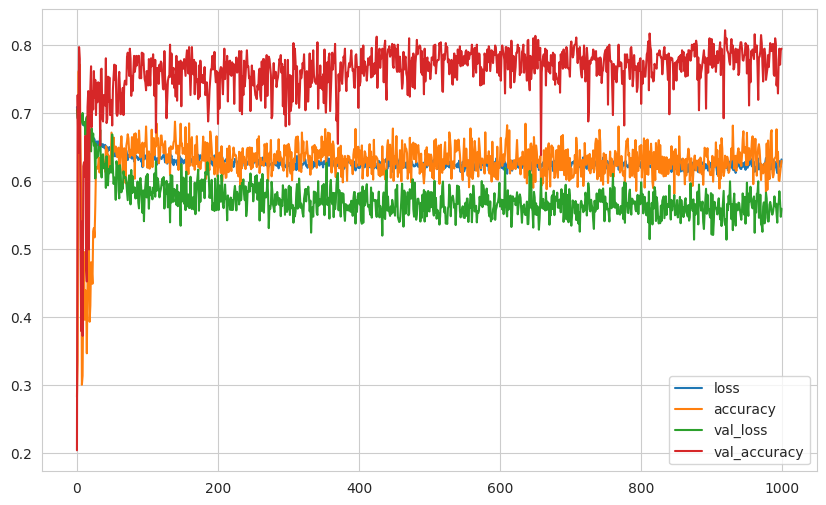

In [216]:
loss_df.plot()
plt.show()

In [217]:
loss, accuracy = model_CW_lr_DO_recallES.evaluate(X_test, y_test, verbose=0)
print("loss: ", loss)
print("accuracy: ", accuracy)

loss:  0.5624711513519287
accuracy:  0.7893333435058594


In [218]:
y_train_pred = model_CW_lr_DO_recallES.predict(X_train) > 0.5
print("Train Result: -------------------------")
print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

240/240 [==============================] - 0s 2ms/step
Train Result: -------------------------
[[5127  965]
 [ 451 1107]]
              precision    recall  f1-score   support

           0       0.92      0.84      0.88      6092
           1       0.53      0.71      0.61      1558

    accuracy                           0.81      7650
   macro avg       0.73      0.78      0.74      7650
weighted avg       0.84      0.81      0.82      7650



In [219]:
y_pred = model_CW_lr_DO_recallES.predict(X_test) > 0.5
print("Test Result: -------------------------")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

47/47 [==============================] - 0s 2ms/step
Test Result: -------------------------
[[974 220]
 [ 96 210]]
              precision    recall  f1-score   support

           0       0.91      0.82      0.86      1194
           1       0.49      0.69      0.57       306

    accuracy                           0.79      1500
   macro avg       0.70      0.75      0.72      1500
weighted avg       0.82      0.79      0.80      1500



47/47 [==============================] - 0s 2ms/step


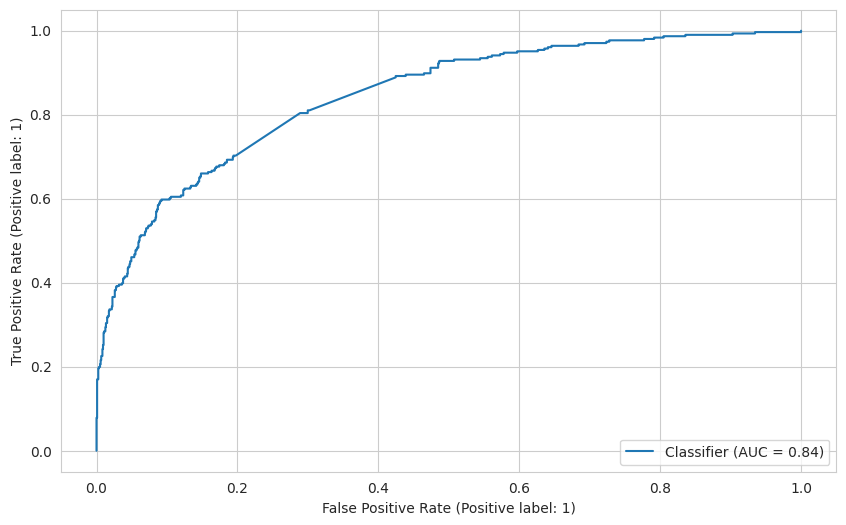

In [220]:
y_pred_proba = model_CW_lr_DO_recallES.predict(X_test)
RocCurveDisplay.from_predictions(y_test, y_pred_proba)

In [221]:
model_CW_lr_DO_recallES.save("model_CW_lr_DO_recallES.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [222]:
model_CW_lr_DO_recallES_auc = roc_auc_score(y_test, y_pred_proba)
model_CW_lr_DO_recallES_acc = accuracy
model_CW_lr_DO_recallES_loss = loss
print("Results of the Model with class weight, increasing the learning rate, dropout layer and early stopping(val_recall):")
print(f"AUC: {model_CW_lr_DO_recallES_auc}, accuracy: {model_CW_lr_DO_recallES_acc}, loss: {model_CW_lr_DO_recallES_loss}")

Results of the Model with class weight, increasing the learning rate, dropout layer and early stopping(val_recall):
AUC: 0.8445399656233235, accuracy: 0.7893333435058594, loss: 0.5624711513519287


## Optuna

In [251]:
batch_size = 128
trial_metric = "accuracy"

def create_model(trial):
    n_units1 = trial.suggest_int("n_units1", 8, 128)
    n_units2 = trial.suggest_int("n_units2", 6, 128)
    n_units3 = trial.suggest_int("n_units3", 4, 128)
    act = trial.suggest_categorical("activation", ["relu", "sigmoid"])
    opt = trial.suggest_categorical("optimizer", [Adam, Adadelta, RMSprop])
    LR = trial.suggest_loguniform("learning_rate", 1e-5, 1.3e-1)

    tf.random.set_seed(SEED)
    model = Sequential()
    model.add(Dense(n_units1, input_dim=X_train.shape[1], activation=act))
    model.add(Dense(n_units2, activation=act))
    model.add(Dense(n_units3, activation=act))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(
        loss="binary_crossentropy",
        optimizer=opt(learning_rate=LR),
        metrics=[trial_metric],
    )
    return model


In [104]:
early_stop = EarlyStopping( monitor="val_loss", mode="min", verbose=1, patience=10, restore_best_weights=True)

In [289]:
def objective(trial):
    model = create_model(trial)
    w0 = trial.suggest_loguniform("w0", 0.01, 5)
    w1 = trial.suggest_loguniform("w1", 0.01, 5)
    model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        epochs=100,
        callbacks=[early_stop],
        class_weight={0: w0, 1: w1},
        verbose=0,
    )
    score = model.evaluate(X_test, y_test, verbose=0)[1]
    return score

In [290]:
optuna_study = optuna.create_study(direction="maximize")
optuna_study.optimize(objective, n_trials=15)

[I 2023-10-30 01:24:08,887] A new study created in memory with name: no-name-f4c70096-8079-4639-82b2-6d5fba8892cb
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'keras.src.optimizers.adam.Adam'> which is of type type.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'keras.src.optimizers.adadelta.Adadelta'> which is of type type.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'keras.src.optimizers.rmsprop.RMSprop'> which is of type type.
  w

Restoring model weights from the end of the best epoch: 20.
Epoch 30: early stopping


[I 2023-10-30 01:24:18,873] Trial 0 finished with value: 0.8006666898727417 and parameters: {'n_units1': 99, 'n_units2': 99, 'n_units3': 83, 'activation': 'sigmoid', 'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'learning_rate': 0.001264866324790512, 'w0': 1.0494658329860214, 'w1': 1.2699629544541033}. Best is trial 0 with value: 0.8006666898727417.


Restoring model weights from the end of the best epoch: 1.
Epoch 11: early stopping


[I 2023-10-30 01:24:22,800] Trial 1 finished with value: 0.7960000038146973 and parameters: {'n_units1': 10, 'n_units2': 122, 'n_units3': 120, 'activation': 'sigmoid', 'optimizer': <class 'keras.src.optimizers.rmsprop.RMSprop'>, 'learning_rate': 7.097418334130647e-05, 'w0': 2.3646713744379326, 'w1': 1.2971714476159442}. Best is trial 0 with value: 0.8006666898727417.


Restoring model weights from the end of the best epoch: 1.
Epoch 11: early stopping


[I 2023-10-30 01:24:26,936] Trial 2 finished with value: 0.7960000038146973 and parameters: {'n_units1': 45, 'n_units2': 125, 'n_units3': 105, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.adadelta.Adadelta'>, 'learning_rate': 2.6586058188827447e-05, 'w0': 0.01867413658326676, 'w1': 0.11290941774520083}. Best is trial 0 with value: 0.8006666898727417.


Restoring model weights from the end of the best epoch: 21.
Epoch 31: early stopping


[I 2023-10-30 01:24:36,655] Trial 3 finished with value: 0.8119999766349792 and parameters: {'n_units1': 109, 'n_units2': 103, 'n_units3': 66, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.rmsprop.RMSprop'>, 'learning_rate': 0.00038335631447757414, 'w0': 4.265193624432994, 'w1': 0.3722596931114789}. Best is trial 3 with value: 0.8119999766349792.


Restoring model weights from the end of the best epoch: 1.
Epoch 11: early stopping


[I 2023-10-30 01:24:42,689] Trial 4 finished with value: 0.7960000038146973 and parameters: {'n_units1': 102, 'n_units2': 9, 'n_units3': 59, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.rmsprop.RMSprop'>, 'learning_rate': 0.009868323626700433, 'w0': 0.1970262624093019, 'w1': 0.02033758928857251}. Best is trial 3 with value: 0.8119999766349792.


Restoring model weights from the end of the best epoch: 50.
Epoch 60: early stopping


[I 2023-10-30 01:24:59,799] Trial 5 finished with value: 0.8166666626930237 and parameters: {'n_units1': 96, 'n_units2': 42, 'n_units3': 93, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'learning_rate': 0.001406110272351531, 'w0': 4.7162769152614885, 'w1': 0.01971819129130197}. Best is trial 5 with value: 0.8166666626930237.


Restoring model weights from the end of the best epoch: 27.
Epoch 37: early stopping


[I 2023-10-30 01:25:21,281] Trial 6 finished with value: 0.8379999995231628 and parameters: {'n_units1': 66, 'n_units2': 66, 'n_units3': 53, 'activation': 'sigmoid', 'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'learning_rate': 0.016405267266698272, 'w0': 0.4031921142861951, 'w1': 0.06318026776807376}. Best is trial 6 with value: 0.8379999995231628.


Restoring model weights from the end of the best epoch: 42.
Epoch 52: early stopping


[I 2023-10-30 01:25:37,650] Trial 7 finished with value: 0.7846666574478149 and parameters: {'n_units1': 55, 'n_units2': 83, 'n_units3': 58, 'activation': 'sigmoid', 'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'learning_rate': 0.0007325790119229211, 'w0': 0.030806480409669313, 'w1': 0.09001057499407027}. Best is trial 6 with value: 0.8379999995231628.


Restoring model weights from the end of the best epoch: 8.
Epoch 18: early stopping


[I 2023-10-30 01:25:46,374] Trial 8 finished with value: 0.7960000038146973 and parameters: {'n_units1': 116, 'n_units2': 71, 'n_units3': 32, 'activation': 'sigmoid', 'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'learning_rate': 0.09799140769386624, 'w0': 0.23952958268783606, 'w1': 1.3092346747436505}. Best is trial 6 with value: 0.8379999995231628.


Restoring model weights from the end of the best epoch: 6.
Epoch 16: early stopping


[I 2023-10-30 01:25:57,661] Trial 9 finished with value: 0.8199999928474426 and parameters: {'n_units1': 80, 'n_units2': 60, 'n_units3': 123, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'learning_rate': 0.05391183459408942, 'w0': 0.2552499978181608, 'w1': 0.07224475852300269}. Best is trial 6 with value: 0.8379999995231628.
[I 2023-10-30 01:26:26,885] Trial 10 finished with value: 0.7960000038146973 and parameters: {'n_units1': 39, 'n_units2': 36, 'n_units3': 4, 'activation': 'sigmoid', 'optimizer': <class 'keras.src.optimizers.adadelta.Adadelta'>, 'learning_rate': 0.011614535689264273, 'w0': 0.06785205462183952, 'w1': 0.011396228933267536}. Best is trial 6 with value: 0.8379999995231628.


Restoring model weights from the end of the best epoch: 14.
Epoch 24: early stopping


[I 2023-10-30 01:26:38,161] Trial 11 finished with value: 0.7960000038146973 and parameters: {'n_units1': 80, 'n_units2': 49, 'n_units3': 35, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'learning_rate': 0.08220246283557592, 'w0': 0.5225305915341788, 'w1': 0.05862922422013492}. Best is trial 6 with value: 0.8379999995231628.


Restoring model weights from the end of the best epoch: 16.
Epoch 26: early stopping


[I 2023-10-30 01:26:49,402] Trial 12 finished with value: 0.846666693687439 and parameters: {'n_units1': 73, 'n_units2': 61, 'n_units3': 124, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'learning_rate': 0.019745594055152176, 'w0': 0.14477768557846568, 'w1': 0.26819196792311456}. Best is trial 12 with value: 0.846666693687439.


Restoring model weights from the end of the best epoch: 24.
Epoch 34: early stopping


[I 2023-10-30 01:26:59,409] Trial 13 finished with value: 0.8159999847412109 and parameters: {'n_units1': 67, 'n_units2': 26, 'n_units3': 39, 'activation': 'sigmoid', 'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'learning_rate': 0.01010295389399159, 'w0': 0.08137022631960308, 'w1': 0.32389531297951263}. Best is trial 12 with value: 0.846666693687439.


Restoring model weights from the end of the best epoch: 18.
Epoch 28: early stopping


[I 2023-10-30 01:27:08,361] Trial 14 finished with value: 0.812666654586792 and parameters: {'n_units1': 28, 'n_units2': 76, 'n_units3': 83, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'learning_rate': 0.023737206194855965, 'w0': 0.8555848427354209, 'w1': 3.731912841174362}. Best is trial 12 with value: 0.846666693687439.


In [291]:
optuna_study.best_params

{'n_units1': 73,
 'n_units2': 61,
 'n_units3': 124,
 'activation': 'relu',
 'optimizer': keras.src.optimizers.adam.Adam,
 'learning_rate': 0.019745594055152176,
 'w0': 0.14477768557846568,
 'w1': 0.26819196792311456}

In [292]:
# add optuna parameters
unit1, unit2, unit3, activation, optimizer, lr, w0, w1 = (
    optuna_study.best_params["n_units1"],
    optuna_study.best_params["n_units2"],
    optuna_study.best_params["n_units3"],
    optuna_study.best_params["activation"],
    optuna_study.best_params["optimizer"],
    optuna_study.best_params["learning_rate"],
    optuna_study.best_params["w0"],
    optuna_study.best_params["w1"],
  )

In [102]:
tf.random.set_seed(SEED)
optuna_model = Sequential()
optuna_model.add(Dense(unit1, activation=activation))
optuna_model.add(Dense(unit2, activation=activation ))
optuna_model.add(Dense(unit3, activation=activation ))
optuna_model.add(Dense(1, activation="sigmoid"))
opt = optimizer(learning_rate=lr)
optuna_model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

In [105]:
# training the model
optuna_model.fit(
                  X_train,
                  y_train,
                  validation_data=(X_val, y_val),
                  batch_size=batch_size,
                  epochs=100,
                  callbacks=[early_stop],
                  verbose=1,
                  class_weight={0: w0, 1: w1},
                  )

Epoch 1/100
60/60 [==============================] - 1s 6ms/step - loss: 0.0988 - accuracy: 0.7719 - val_loss: 0.4431 - val_accuracy: 0.8024
Epoch 2/100
60/60 [==============================] - 0s 3ms/step - loss: 0.0884 - accuracy: 0.8038 - val_loss: 0.4005 - val_accuracy: 0.8459
Epoch 3/100
60/60 [==============================] - 0s 3ms/step - loss: 0.0804 - accuracy: 0.8269 - val_loss: 0.3762 - val_accuracy: 0.8388
Epoch 4/100
60/60 [==============================] - 0s 3ms/step - loss: 0.0767 - accuracy: 0.8397 - val_loss: 0.3991 - val_accuracy: 0.8388
Epoch 5/100
60/60 [==============================] - 0s 3ms/step - loss: 0.0753 - accuracy: 0.8378 - val_loss: 0.3864 - val_accuracy: 0.8471
Epoch 6/100
60/60 [==============================] - 0s 3ms/step - loss: 0.0739 - accuracy: 0.8431 - val_loss: 0.3712 - val_accuracy: 0.8494
Epoch 7/100
60/60 [==============================] - 0s 3ms/step - loss: 0.0741 - accuracy: 0.8455 - val_loss: 0.4217 - val_accuracy: 0.8271
Epoch 8/100
6

### Evaluate The Model

- Plot the model history to observe the changing of metrics
- Make prediction to see "confusion matrix" and "classification report"
- Check ROC (Receiver Operating Curve) and AUC (Area Under Curve) for the model

In [106]:
optuna_history = optuna_model.history.history

In [107]:
loss_df = pd.DataFrame(optuna_history)
loss_df.head()

loss  accuracy  val_loss  val_accuracy
0 0.099     0.772     0.443         0.802
1 0.088     0.804     0.400         0.846
2 0.080     0.827     0.376         0.839
3 0.077     0.840     0.399         0.839
4 0.075     0.838     0.386         0.847

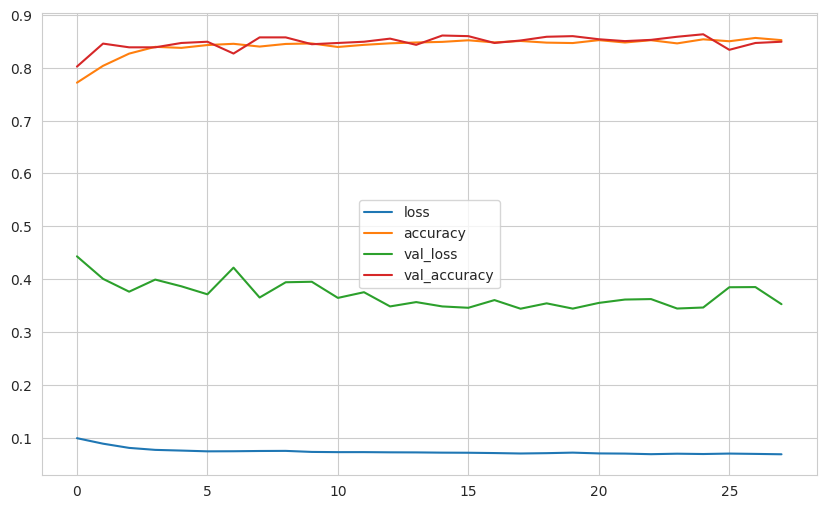

In [108]:
loss_df.plot()
plt.show()

In [75]:
loss, accuracy = optuna_model.evaluate(X_test, y_test, verbose=0)
print("loss: ", loss)
print("accuracy: ", accuracy)

loss:  0.3615928590297699
accuracy:  0.8600000143051147


In [76]:
y_train_pred = (optuna_model.predict(X_train) > 0.5).astype("int32")
print("Train Result:----------------------------")
print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

240/240 [==============================] - 0s 1ms/step
Train Result:----------------------------
[[5745  347]
 [ 702  856]]
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      6092
           1       0.71      0.55      0.62      1558

    accuracy                           0.86      7650
   macro avg       0.80      0.75      0.77      7650
weighted avg       0.85      0.86      0.86      7650



In [77]:
y_pred = (optuna_model.predict(X_test) > 0.5).astype("int32")
print("Test Result:----------------------------")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

47/47 [==============================] - 0s 1ms/step
Test Result:----------------------------
[[1126   68]
 [ 142  164]]
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      1194
           1       0.71      0.54      0.61       306

    accuracy                           0.86      1500
   macro avg       0.80      0.74      0.76      1500
weighted avg       0.85      0.86      0.85      1500



47/47 [==============================] - 0s 2ms/step


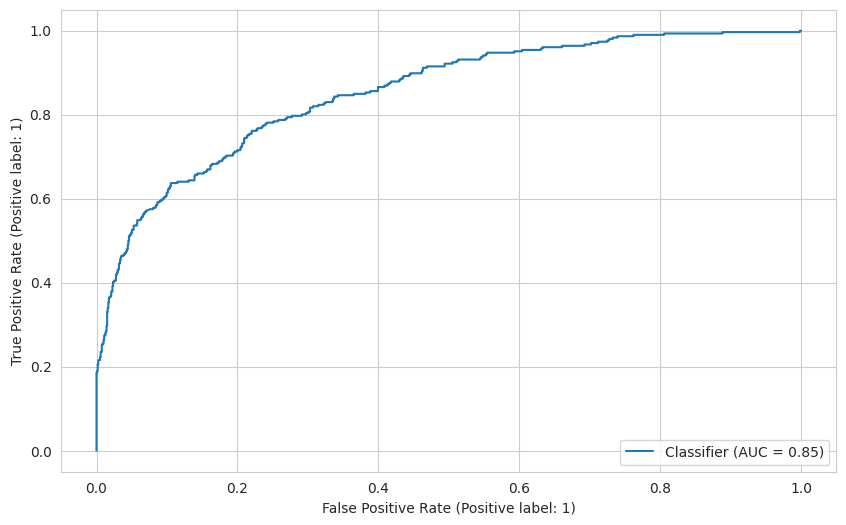

In [78]:
y_pred_proba = optuna_model.predict(X_test)
RocCurveDisplay.from_predictions(y_test, y_pred_proba)

In [79]:
optuna_model.save("optuna_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [80]:
optuna_auc = roc_auc_score(y_test, y_pred_proba)
optuna_acc = accuracy
optuna_loss = loss
print("Results of the Optuna Model:")
print(f"AUC: {optuna_auc}, accuracy: {optuna_acc}, loss: {optuna_loss}")

Results of the Optuna Model:
AUC: 0.8523623017046014, accuracy: 0.8600000143051147, loss: 0.3615928590297699


# Final Model and Model Deployment

## Comparing Models

In [304]:
compare = pd.DataFrame({"Model":
                                ["Without Class Weight",
                                "With Class Weight",
                                "With Class Weight & increasing LR",
                                "With Class Weight & increasing LR & Dropout",
                                "With Class Weight & increasing LR & Dropout & Loss Early Stopping",
                                "With Class Weight & increasing LR & Dropout & Recall Early Stopping",
                                "Optuna"],

                       "Accuracy":
                                  [model_noCW_acc, model_CW_acc, model_CW_lr_acc,
                                   model_CW_lr_DO_acc, model_CW_lr_DO_lossES_acc,
                                   model_CW_lr_DO_recallES_acc, optuna_acc],

                        "Loss":
                                 [model_noCW_loss, model_CW_loss, model_CW_lr_loss,
                                 model_CW_lr_DO_loss, model_CW_lr_DO_lossES_loss,
                                  model_CW_lr_DO_recallES_loss, optuna_loss],

                         "AUC":
                                [model_noCW_auc, model_CW_auc, model_CW_lr_auc,
                                model_CW_lr_DO_auc, model_CW_lr_DO_lossES_auc,
                                 model_CW_lr_DO_recallES_auc, optuna_auc],}
                       )

In [82]:
csv_file_path = '/content/CompareModels.csv'

In [83]:
# Save the DataFrame to a CSV file
compare.to_csv(csv_file_path, index=False)

In [86]:
# Load the DataFrame from CSV file
compare = pd.read_csv(csv_file_path)
compare

Model  Accuracy  Loss   AUC
0                               Without Class Weight     0.851 0.386 0.843
1                                  With Class Weight     0.785 0.458 0.846
2                  With Class Weight & increasing LR     0.785 0.458 0.846
3        With Class Weight & increasing LR & Dropout     0.699 0.584 0.808
4  With Class Weight & increasing LR & Dropout & ...     0.791 0.548 0.823
5  With Class Weight & increasing LR & Dropout & ...     0.789 0.562 0.845
6                                             Optuna     0.860 0.362 0.852

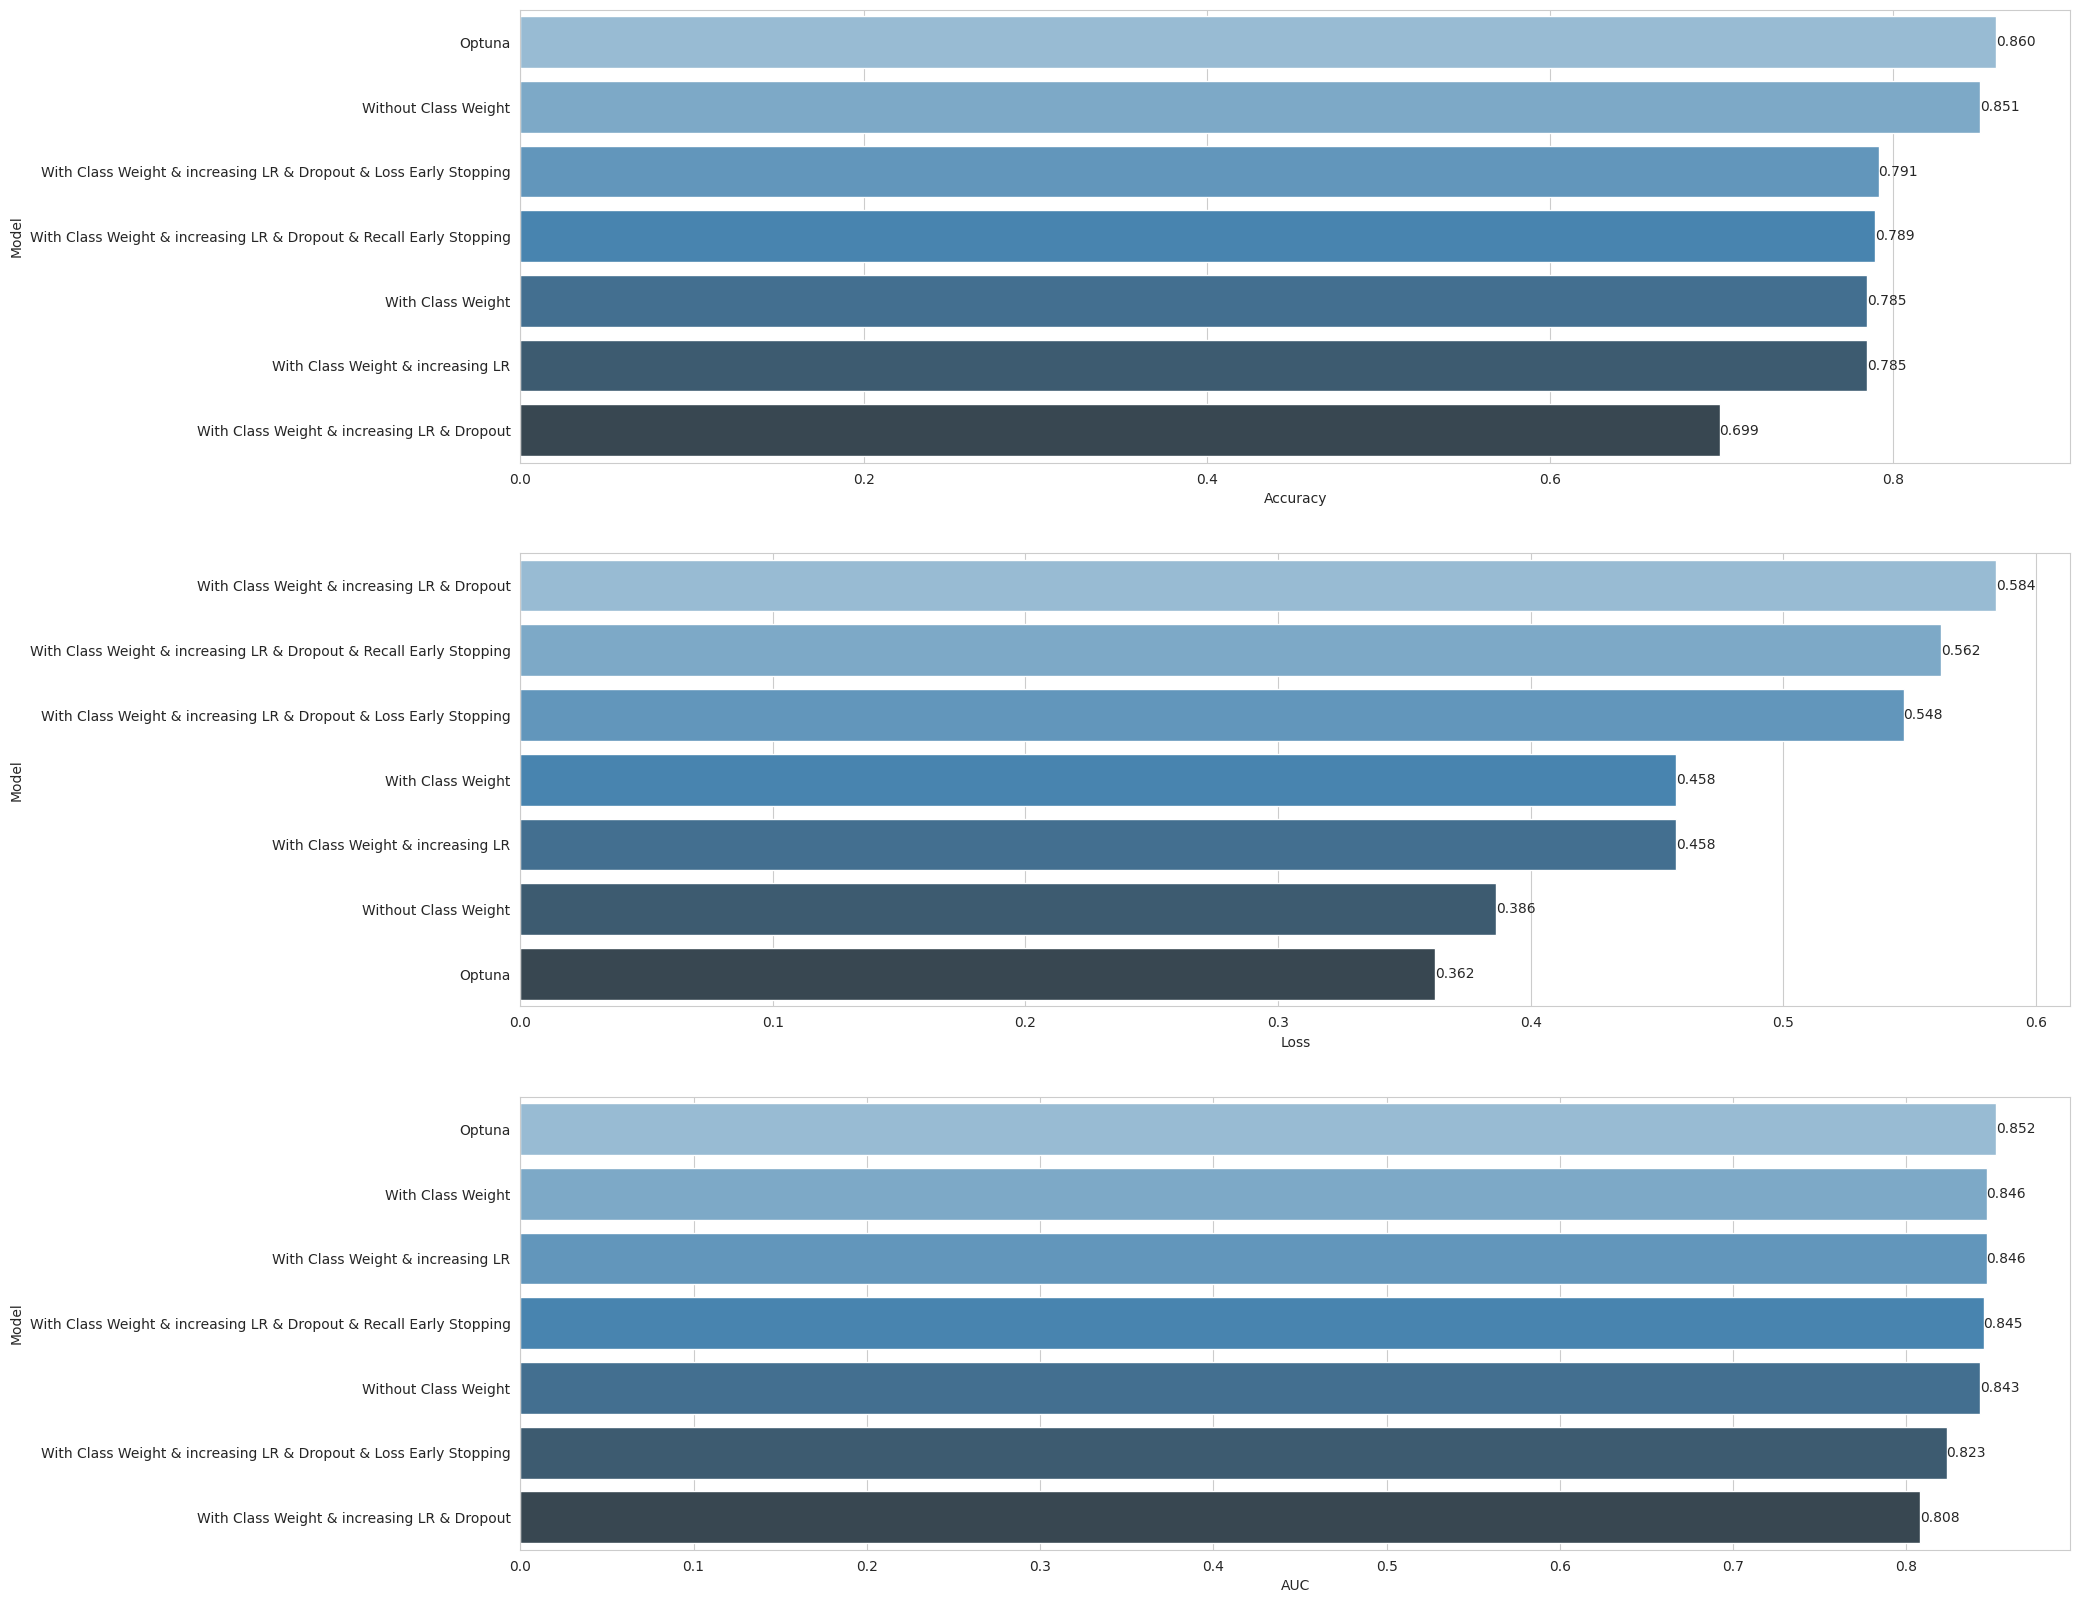

In [94]:
def labels(ax):   
    for p in ax.patches:
        width = p.get_width()                       
        ax.text(width,                              
                p.get_y() + p.get_height() / 2,     
                '{:1.3f}'.format(width),            
                ha = 'left',                        
                va = 'center')                      

plt.figure(figsize=(20,20))
plt.subplot(311)
compare = compare.sort_values(by="Accuracy", ascending=False)
ax=sns.barplot(x="Accuracy", y="Model", data=compare, palette="Blues_d") # f1 score
labels(ax)

plt.subplot(312)
compare = compare.sort_values(by="Loss", ascending=False)
ax=sns.barplot(x="Loss", y="Model", data=compare, palette="Blues_d") # recall score
labels(ax)

plt.subplot(313)
compare = compare.sort_values(by="AUC", ascending=False)
ax=sns.barplot(x="AUC", y="Model", data=compare, palette="Blues_d") # average precision score
labels(ax)

plt.show()

## Saving Best Model, Encoder and Scaler

In [95]:
pickle.dump(scaler, open("scaler_ChurnPrediction", "wb"))

In [126]:
pickle.dump(column_trans, open("Encoding_ChurnPrediction", "wb"))

In [109]:
loss_df = pd.DataFrame(optuna_history)
loss_df.head()

loss  accuracy  val_loss  val_accuracy
0 0.099     0.772     0.443         0.802
1 0.088     0.804     0.400         0.846
2 0.080     0.827     0.376         0.839
3 0.077     0.840     0.399         0.839
4 0.075     0.838     0.386         0.847

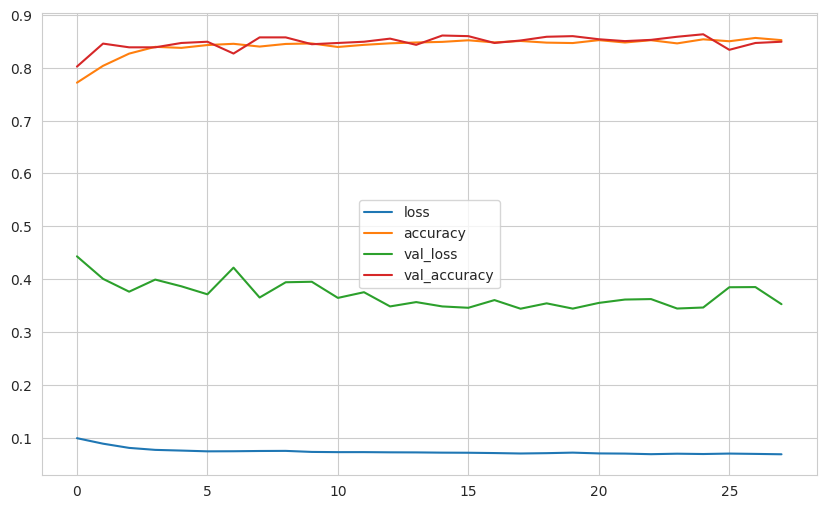

In [110]:
loss_df.plot()
plt.show()

In [111]:
loss, recall = optuna_model.evaluate(X_test, y_test, verbose=0)
print("loss: ", loss)
print("recall: ", recall)

loss:  0.3617419898509979
recall:  0.859333336353302


In [112]:
y_pred = optuna_model.predict(X_test) > 0.5
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

47/47 [==============================] - 0s 5ms/step
[[1126   68]
 [ 143  163]]
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      1194
           1       0.71      0.53      0.61       306

    accuracy                           0.86      1500
   macro avg       0.80      0.74      0.76      1500
weighted avg       0.85      0.86      0.85      1500



In [113]:
optuna_model.save("model_ChurnPrediction.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Loading Model, Encoder and Scaler

In [127]:
model_ChurnPrediction = load_model("model_ChurnPrediction.h5")
encoding_ChurnPrediction = pickle.load(open("Encoding_ChurnPrediction", "rb"))
scaler_ChurnPrediction = pickle.load(open("scaler_ChurnPrediction", "rb"))

## Prediction

In [116]:
df.head()

CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42       2      0.000              1   
1          608     Spain  Female   41       1  83807.860              1   
2          502    France  Female   42       8 159660.800              3   
3          699    France  Female   39       1      0.000              2   
4          850     Spain  Female   43       2 125510.820              1   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0          1               1       101348.880       1  
1          0               1       112542.580       0  
2          1               0       113931.570       1  
3          0               0        93826.630       0  
4          1               1        79084.100       0

In [136]:
single_customer1 = df.drop("Exited", axis=1).iloc[2:3, :]
single_customer1

CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
2          502    France  Female   42       8 159660.800              3   

   HasCrCard  IsActiveMember  EstimatedSalary  
2          1               0       113931.570

In [138]:
single_customer1 = encoding_ChurnPrediction.transform(single_customer1)
single_customer1

array([[1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00,
        0.0000000e+00, 5.0200000e+02, 4.2000000e+01, 8.0000000e+00,
        1.5966080e+05, 3.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        1.1393157e+05]])

In [140]:
single_customer1 = scaler_ChurnPrediction.transform(single_customer1)
single_customer1

array([[1.        , 0.        , 0.        , 1.        , 0.        ,
        0.304     , 0.32432432, 0.8       , 0.66975307, 0.66666667,
        1.        , 0.        , 0.56954732]])

In [142]:
(model_ChurnPrediction.predict(single_customer1) > 0.5).astype("int32")

1/1 [==============================] - 0s 28ms/step


array([[1]], dtype=int32)

In [143]:
df["Exited"].iloc[2]

1

In [137]:
single_customer2 = df.drop("Exited", axis=1).iloc[4:5, :]
single_customer2

CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
4          850     Spain  Female   43       2 125510.820              1   

   HasCrCard  IsActiveMember  EstimatedSalary  
4          1               1        79084.100

In [139]:
single_customer2 = encoding_ChurnPrediction.transform(single_customer2)
single_customer2

array([[0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 1.0000000e+00,
        0.0000000e+00, 8.5000000e+02, 4.3000000e+01, 2.0000000e+00,
        1.2551082e+05, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
        7.9084100e+04]])

In [141]:
single_customer2 = scaler_ChurnPrediction.transform(single_customer2)
single_customer2

array([[0.        , 0.        , 1.        , 1.        , 0.        ,
        1.        , 0.33783784, 0.2       , 0.52649903, 0.        ,
        1.        , 1.        , 0.39520595]])

In [144]:
(model_ChurnPrediction.predict(single_customer2) > 0.5).astype("int32")

1/1 [==============================] - 0s 41ms/step


array([[0]], dtype=int32)

In [145]:
df["Exited"].iloc[4]

0

# ___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___